### Initial environment setup
Version control is critical
https://stackoverflow.com/questions/47586421/jupyter-notebook-library-versions-check

In [22]:
import numpy as np
import datetime
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Set plot appearance
# See here for more options: https://matplotlib.org/users/customizing.html
%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")
# sns.set_context("poster", font_scale=1.0)

In [23]:
# Ignore warnings (for seaborn's kdeplot)
import warnings
warnings.filterwarnings('ignore')

---
# Human Resources Strategy
## Training a predictive model for employee attrition

Managing employee voluntary attrition is a crucial compoentn of Workforce Planning, as managing retention of exisiting staff enables a company to maintain control over high direct recruiting costs for replacements, as well as all other human resource factors. Attrition affects employee morale and performance, which can have measurable in-direct consequence to the business. 

What follows will be a Supervised Learning problem, building a binary Classification model that predicts whether a person will leave the company (voluntary attrition/termination).

---

In [5]:
%%bash
head hr_data.csv

satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,is_smoker,department,salary
0.38,0.53,2,157,3,0,yes,0,,sales,low
0.8,0.86,5,262,6,0,yes,0,yes,sales,medium
0.11,0.88,7,272,4,0,yes,0,,sales,medium
0.72,0.87,5,223,5,0,yes,0,,sales,low
0.37,0.52,2,,,0,yes,0,no,sales,low
0.41,0.5,2,,,0,yes,0,,sales,low
0.1,0.77,6,247,4,0,yes,0,,sales,low
0.92,0.85,5,259,5,0,yes,0,,sales,low
0.89,1,5,224,5,0,yes,0,,sales,low


In [24]:
import pandas as pd

# Read in the data
hr = pd.read_csv('hr_data.csv')

In [25]:
hr.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'quit',
       'promotion_last_5years', 'is_smoker', 'department', 'salary'],
      dtype='object')

In [26]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,is_smoker,department,salary
0,0.38,0.53,2,157.0,3.0,0,yes,0,NaN,sales,low
1,0.80,0.86,5,262.0,6.0,0,yes,0,yes,sales,medium
2,0.11,0.88,7,272.0,4.0,0,yes,0,NaN,sales,medium
3,0.72,0.87,5,223.0,5.0,0,yes,0,NaN,sales,low
4,0.37,0.52,2,NaN,NaN,0,yes,0,no,sales,low


In [27]:
hr.tail()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,is_smoker,department,salary
14995,0.37,0.48,2,160.0,3.0,0,yes,0,NaN,support,low
14996,0.37,0.53,2,143.0,3.0,0,yes,0,NaN,support,low
14997,0.11,0.96,6,280.0,4.0,0,yes,0,NaN,support,low
14998,0.37,0.52,2,158.0,3.0,0,yes,0,NaN,support,low
14999,0.90,0.75,6,228.0,4.0,0,yes,0,yes,management,high


In [28]:
# How many lines in the original CSV (including the header row)
with open('hr_data.csv') as f:
    print(len(f.read().splitlines()))

15001


In [29]:
# ... yet how many lines in the dataset
len(hr)

15000

Model objective will be the categorical variable `quit` as our response. Let's explore it further. 

In [30]:
# How much missing data in the response target vaiable?
hr.quit.isnull().sum()

0

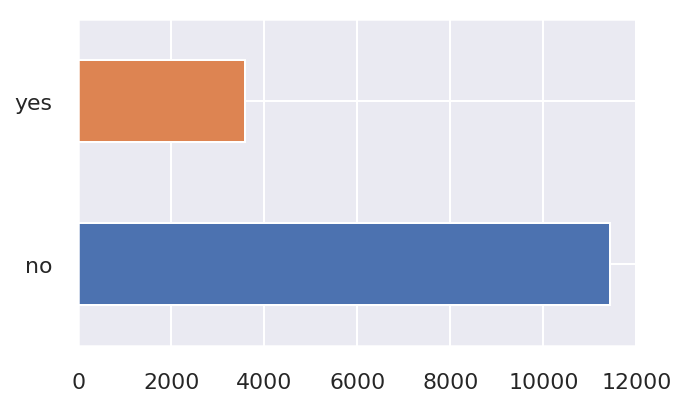

In [31]:
# Assess how this response variable `quit` is distributed, visually
fig, ax = plt.subplots(figsize=(5, 3))
hr.quit.value_counts().plot('barh');

In [32]:
# Dataset column types
hr.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours    float64
time_spend_company       float64
work_accident              int64
quit                      object
promotion_last_5years      int64
is_smoker                 object
department                object
salary                    object
dtype: object

In [33]:
hr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,15000.0,0.612853,0.248633,0.09,0.44,0.64,0.82,1.0
last_evaluation,15000.0,0.716104,0.171164,0.36,0.56,0.72,0.87,1.0
number_project,15000.0,3.803200,1.232682,2.00,3.00,4.00,5.00,7.0
average_monthly_hours,14632.0,200.960224,50.001098,96.00,156.00,200.00,245.00,310.0
time_spend_company,14849.0,3.494175,1.458933,2.00,3.00,3.00,4.00,10.0
work_accident,15000.0,0.144600,0.351709,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,15000.0,0.021267,0.144277,0.00,0.00,0.00,0.00,1.0


In [34]:
# This is important. Modify the data to convert Categorical variables as such.
hr.quit = pd.Categorical(hr.quit)
hr.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_monthly_hours     float64
time_spend_company        float64
work_accident               int64
quit                     category
promotion_last_5years       int64
is_smoker                  object
department                 object
salary                     object
dtype: object

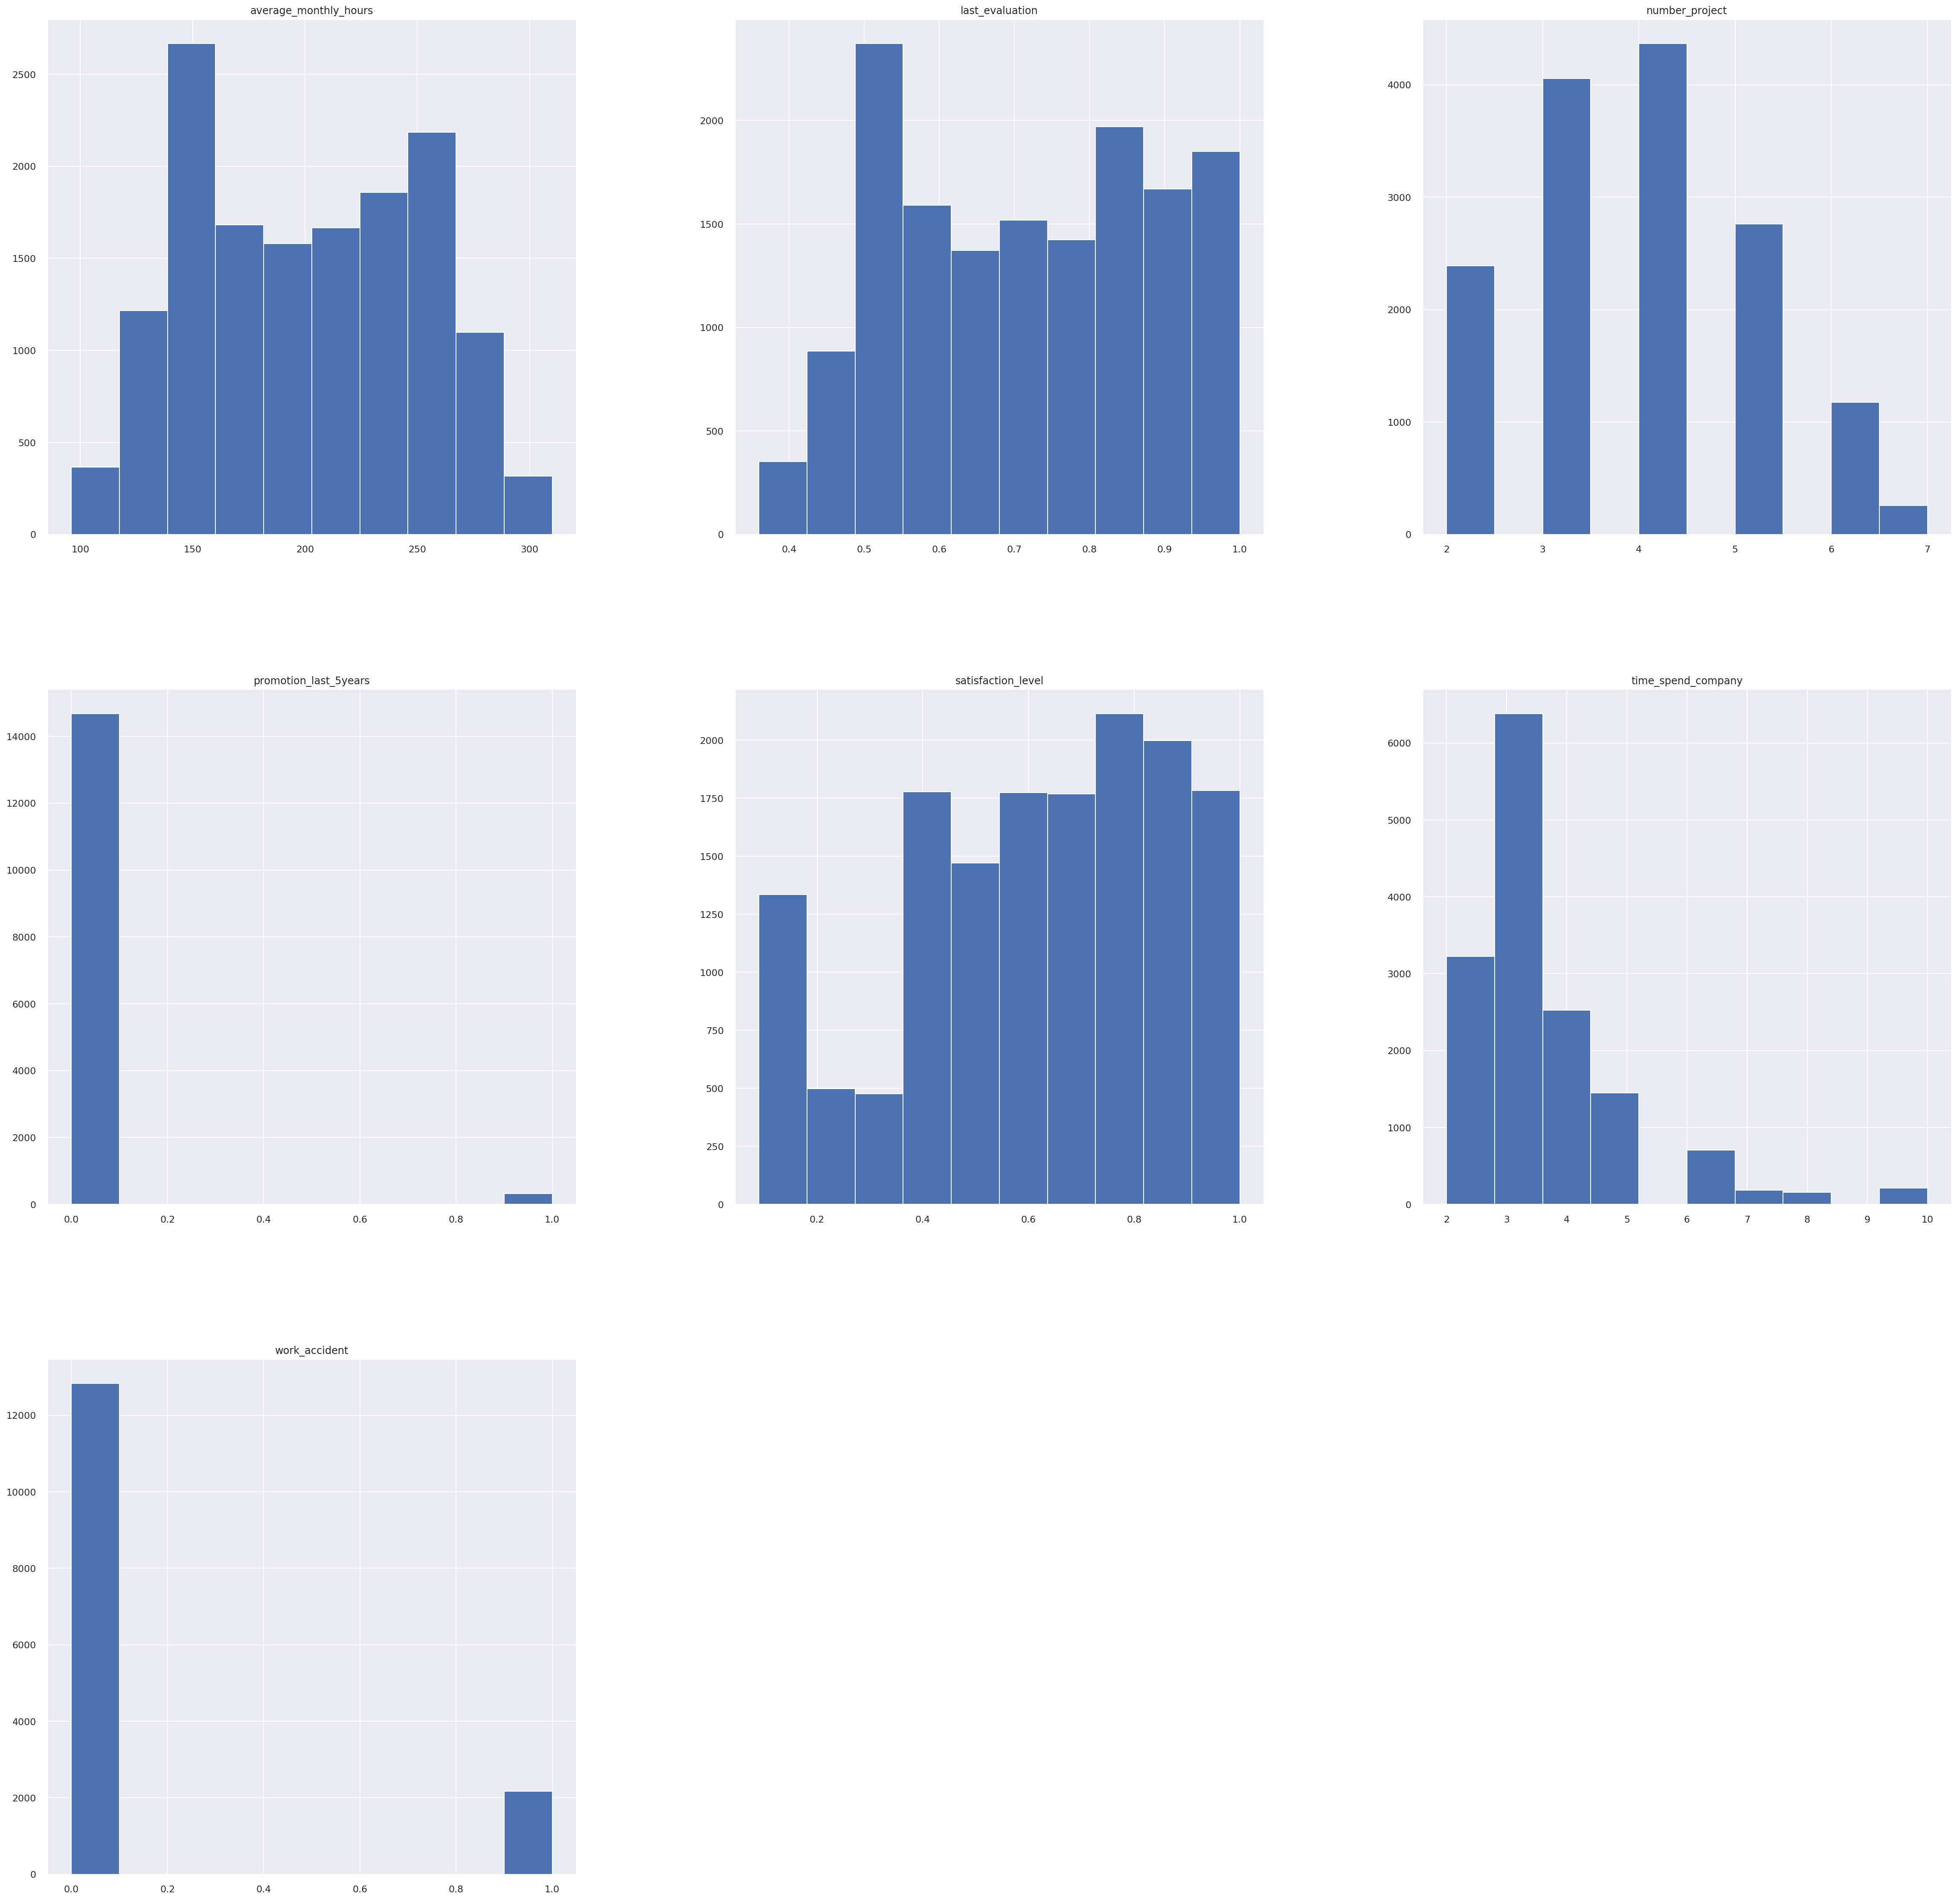

In [35]:
# Plot histograms for each variable
hr.hist(figsize = (40, 40))
plt.show()

## If necessary, toggle the scroll window in the main menu of the notebook: 
## Cell -> Current Outputs -> Toggle Scrolling

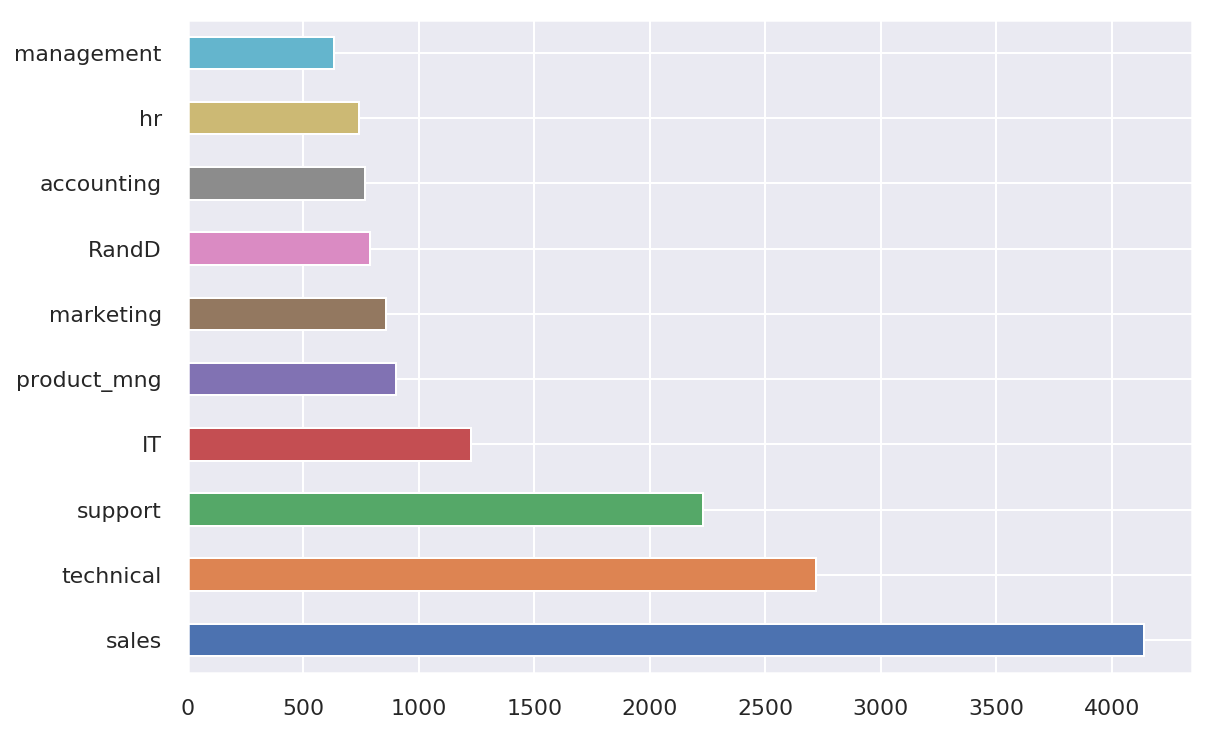

In [36]:
hr.department.value_counts().plot('barh');

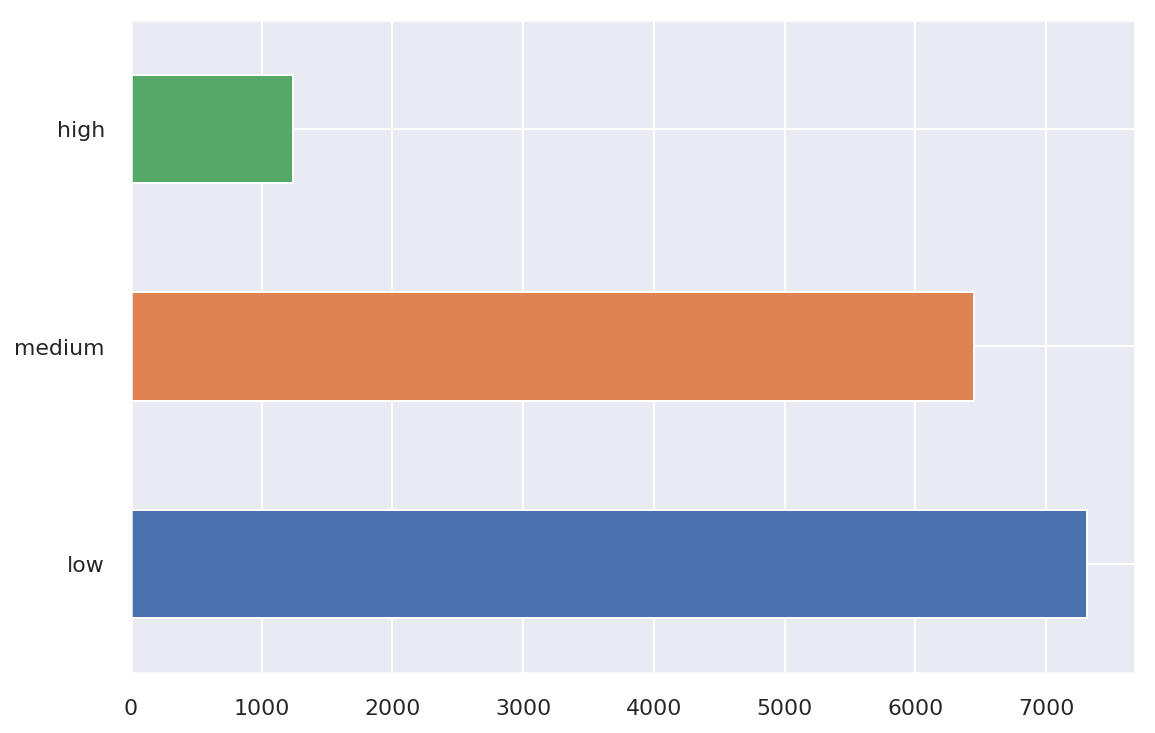

In [37]:
hr.salary.value_counts().plot('barh');

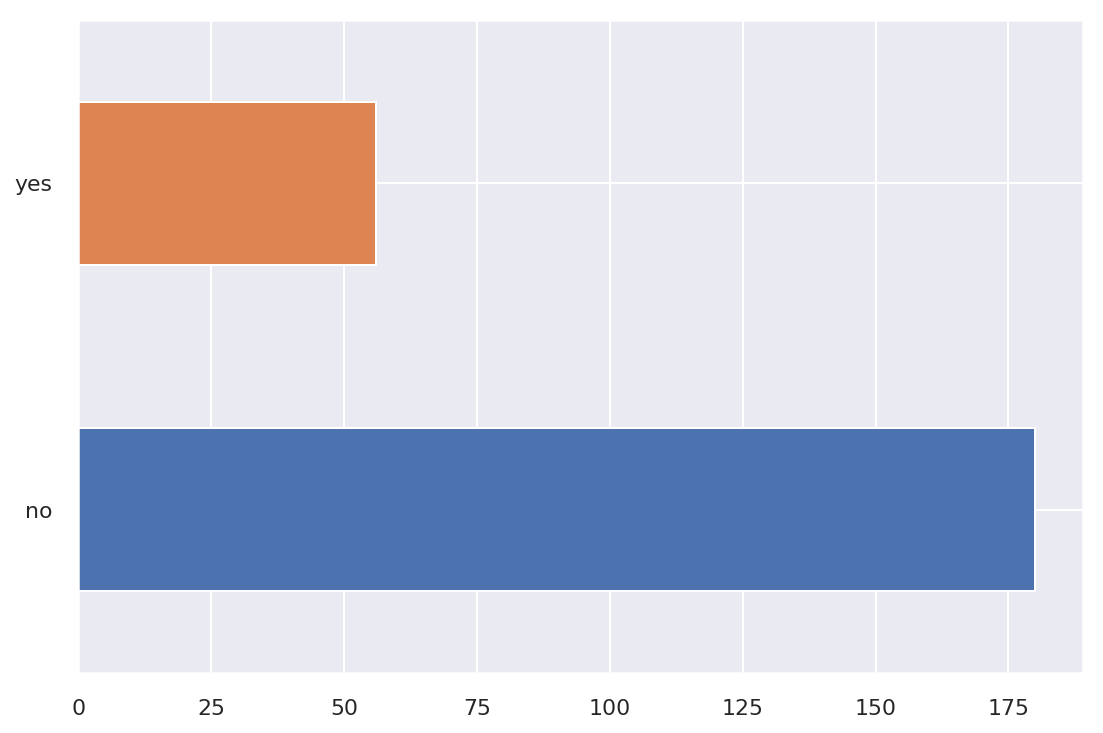

In [38]:
hr.is_smoker.value_counts().plot('barh');

Seeing few `is_smoker` counts, there must clearly be a lot of missing values. 

In [39]:
import pandas_profiling

pandas_profiling.ProfileReport(hr)

Number of variables,11
Number of observations,15000
Total Missing (%),9.3%
Total size in memory,1.2 MiB
Average record size in memory,81.0 B
Numeric,5
Categorical,4
Boolean,2
Date,0
Text (Unique),0
Rejected,0


---

## Feature engineering

#1 `is_smoker`

In [40]:
# Confirm is_smoker has far too many NaN's compared to the other features
hr.isnull().sum() / len(hr) * 100

satisfaction_level        0.000000
last_evaluation           0.000000
number_project            0.000000
average_monthly_hours     2.453333
time_spend_company        1.006667
work_accident             0.000000
quit                      0.000000
promotion_last_5years     0.000000
is_smoker                98.426667
department                0.000000
salary                    0.000000
dtype: float64

In [41]:
# Remove is_smoker feature
del hr['is_smoker']

#2 `time_spend_company` has 1% missing values. Let's assume that a reasonable method for "fixing" these missing values is to replace it with the median of its other values. 

In [42]:
fill_value = hr.time_spend_company.median()
hr.time_spend_company = hr.time_spend_company.fillna(fill_value)

In [43]:
hr.isnull().sum() / len(hr) * 100

satisfaction_level       0.000000
last_evaluation          0.000000
number_project           0.000000
average_monthly_hours    2.453333
time_spend_company       0.000000
work_accident            0.000000
quit                     0.000000
promotion_last_5years    0.000000
department               0.000000
salary                   0.000000
dtype: float64

#3 finally, we can make a smarter adjustment to resolve the missing vales in `average_monthly_hours`

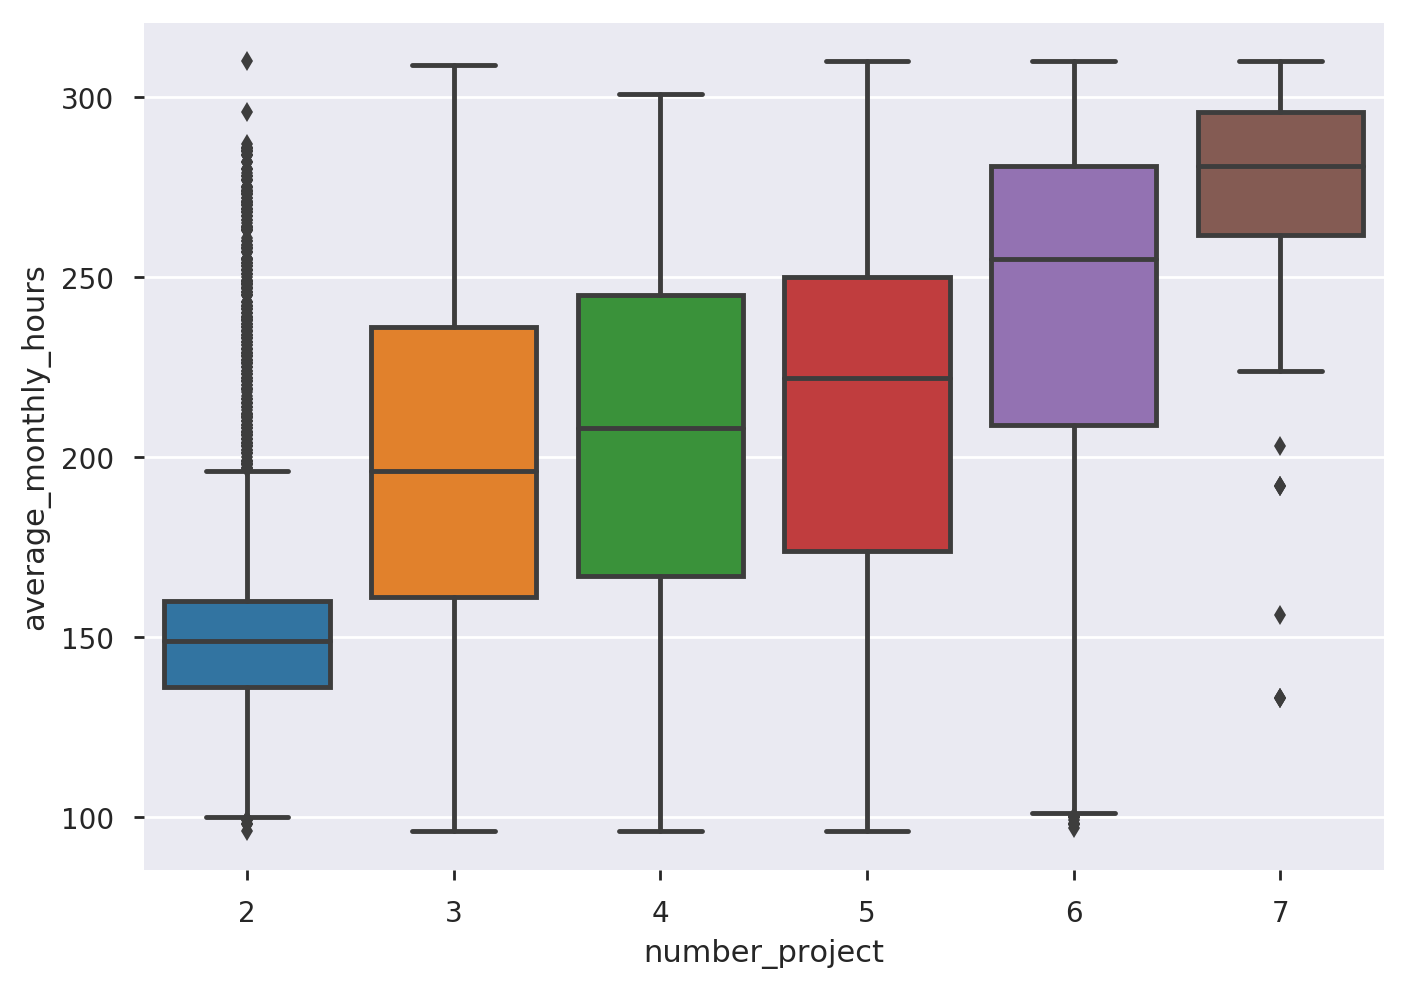

In [44]:
# How does average_monthly_hours depend on number_project?

sns.boxplot(x='number_project', y='average_monthly_hours', data=hr)

In [45]:
# Calculate fill values for average_monthly_hours

mean_per_project = hr.groupby('number_project').average_monthly_hours.mean()  # notice Python object & functions 
mean_per_project = dict(mean_per_project)
mean_per_project

{2: 160.16353543979506,
 3: 197.47882323104236,
 4: 205.07858315740089,
 5: 211.99962839093274,
 6: 238.73006134969324,
 7: 276.015873015873}

In [46]:
# Fill average_monthly_hours with the appropriate values
fill_values_hours = hr.number_project.map(mean_per_project)

In [47]:
fill_values_hours.describe()

count    15000.000000
mean       200.994268
std         22.439560
min        160.163535
25%        197.478823
50%        205.078583
75%        211.999628
max        276.015873
Name: number_project, dtype: float64

In [48]:
hr.average_monthly_hours = hr.average_monthly_hours.fillna(fill_values_hours)

In [49]:
hr.average_monthly_hours.describe()

count    15000.000000
mean       200.994268
std         49.491248
min         96.000000
25%        156.000000
50%        200.000000
75%        244.000000
max        310.000000
Name: average_monthly_hours, dtype: float64

In [50]:
# Confirm that we are all clear of NaN's -- if True, `assert` should not give an error 
assert hr.isnull().sum().sum() == 0

In [52]:
# Convert categorical features of the response variable `quit` to a binary integer representation
hr.quit = hr.quit.map({'no': 0, 'yes': 1})

In [54]:
hr.quit.value_counts()

0    11428
1     3572
Name: quit, dtype: int64

This next step involving one-hot encoding is especially important for Deep Learning, as neural network activation functions require numeric values. 

In [55]:
# One-hot encoding --> convert the other categorical features `department` & `salary` into binary integers matrices  
hr = pd.get_dummies(hr)

In [56]:
hr.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'quit',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

In [57]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,department_IT,department_RandD,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157.000000,3.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262.000000,6.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272.000000,4.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223.000000,5.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,160.163535,3.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [58]:
# Save to file
hr.to_csv('hr_data_processed.csv', index=False)

---
## Building simple Classification models with select features

In [59]:
# Set default figure size
plt.rcParams['figure.figsize'] = (8, 8)

### Bivariate plots to see interactions between select feature variables (using Seaborn plots)

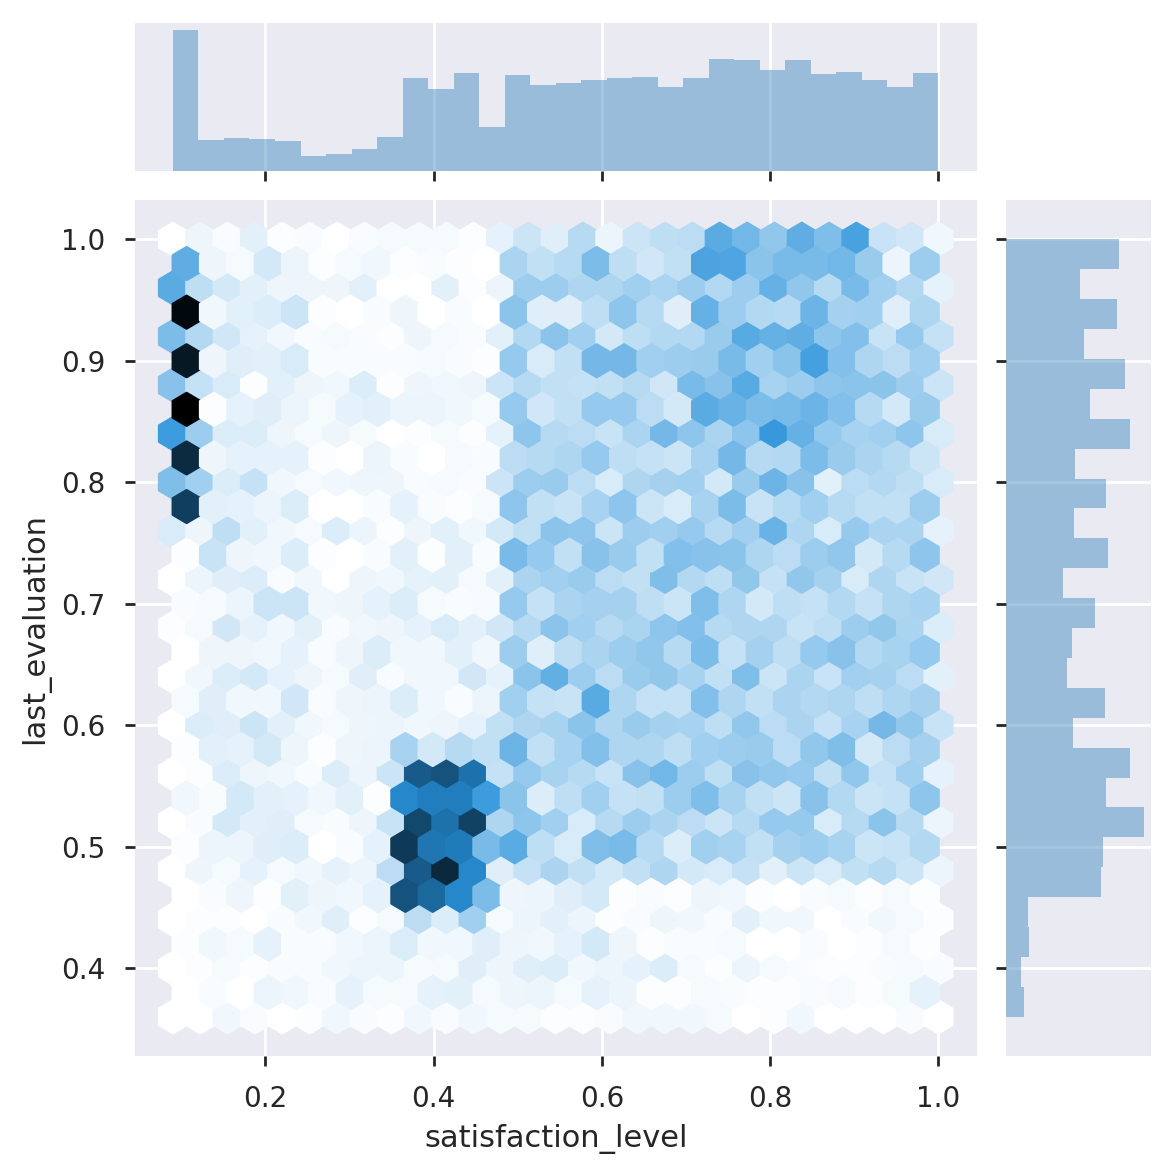

In [73]:
# The two features we'll use for training in this simple model building section
sns.jointplot('satisfaction_level', 'last_evaluation', data=hr, kind='hex')

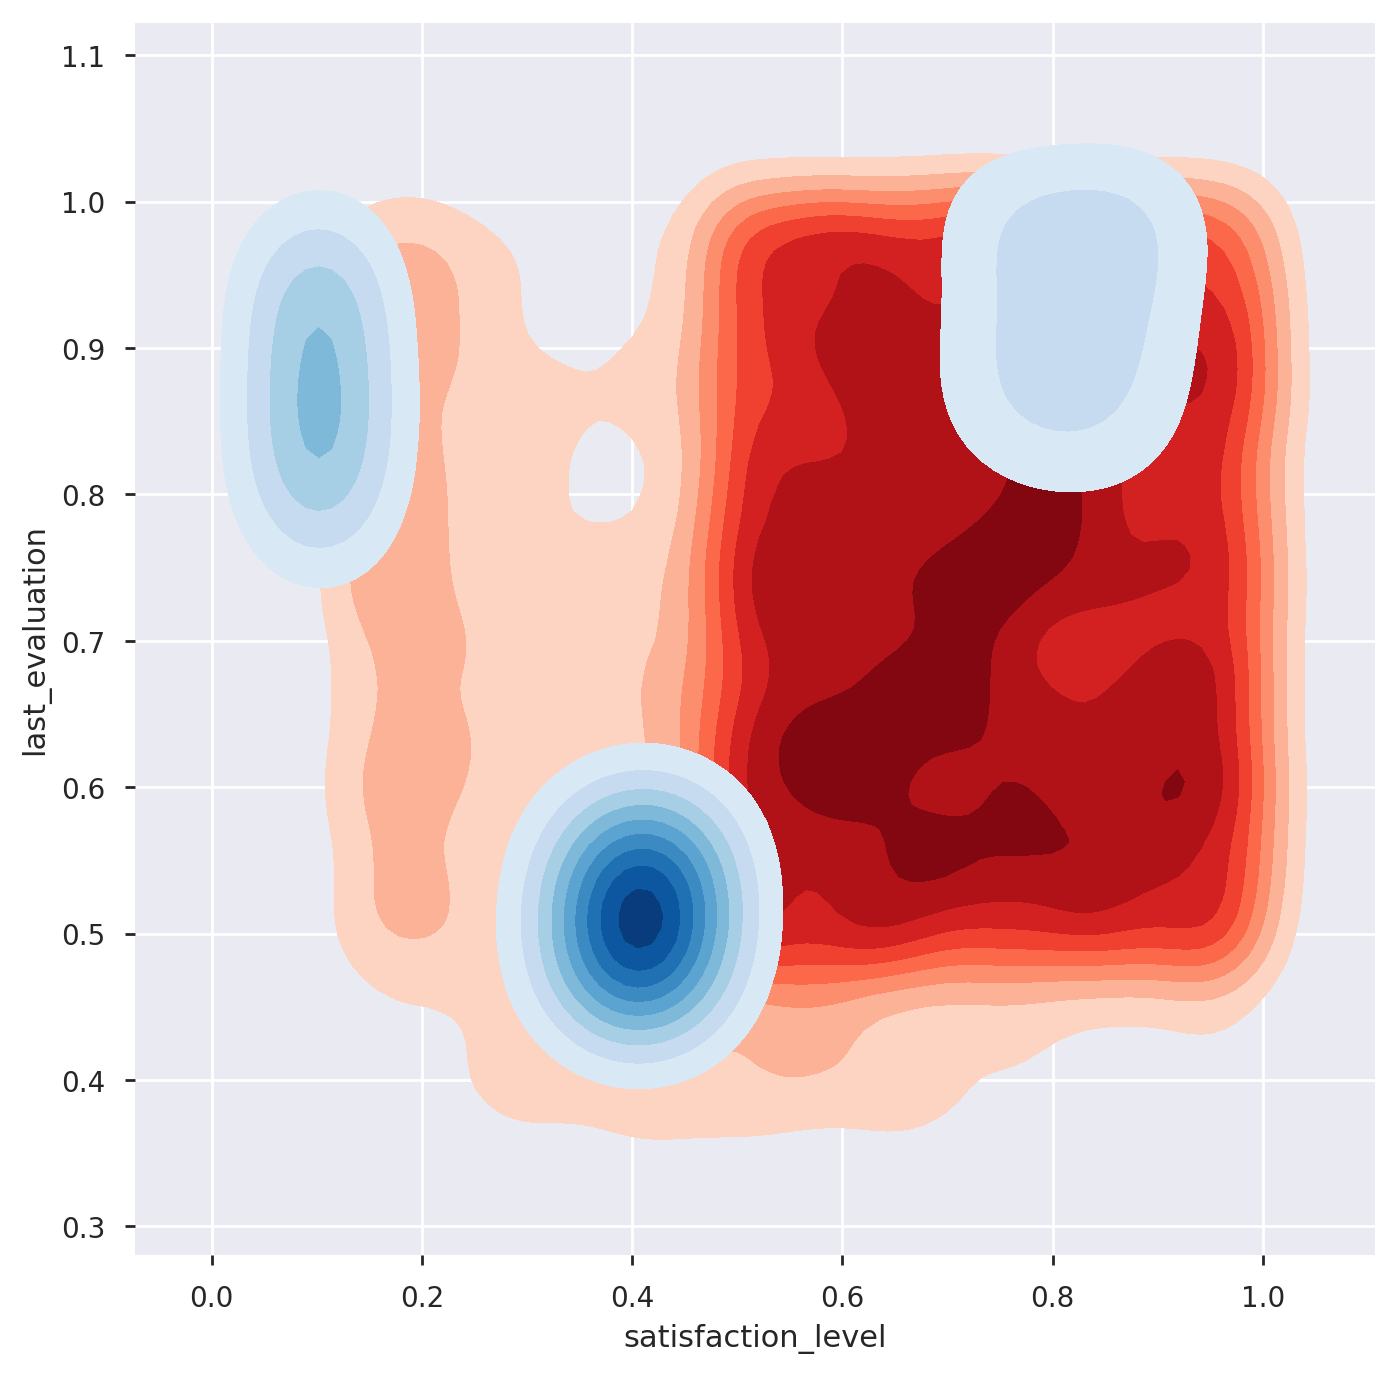

In [68]:
# segment the above plot with the response variable `quit`
fig, ax = plt.subplots()
plot_args = dict(shade=True, shade_lowest=False)
for i, c in zip((0, 1), ('Reds', 'Blues')):
    sns.kdeplot(hr.loc[hr.quit==i, 'satisfaction_level'],
                hr.loc[hr.quit==i, 'last_evaluation'],
                cmap=c, **plot_args)
#ax.text(0.05, 1.05, 'quit = 0', size=16, color=sns.color_palette('Reds')[-2])
#ax.text(0.25, 1.05, 'quit = 1', size=16, color=sns.color_palette('Blues')[-2])

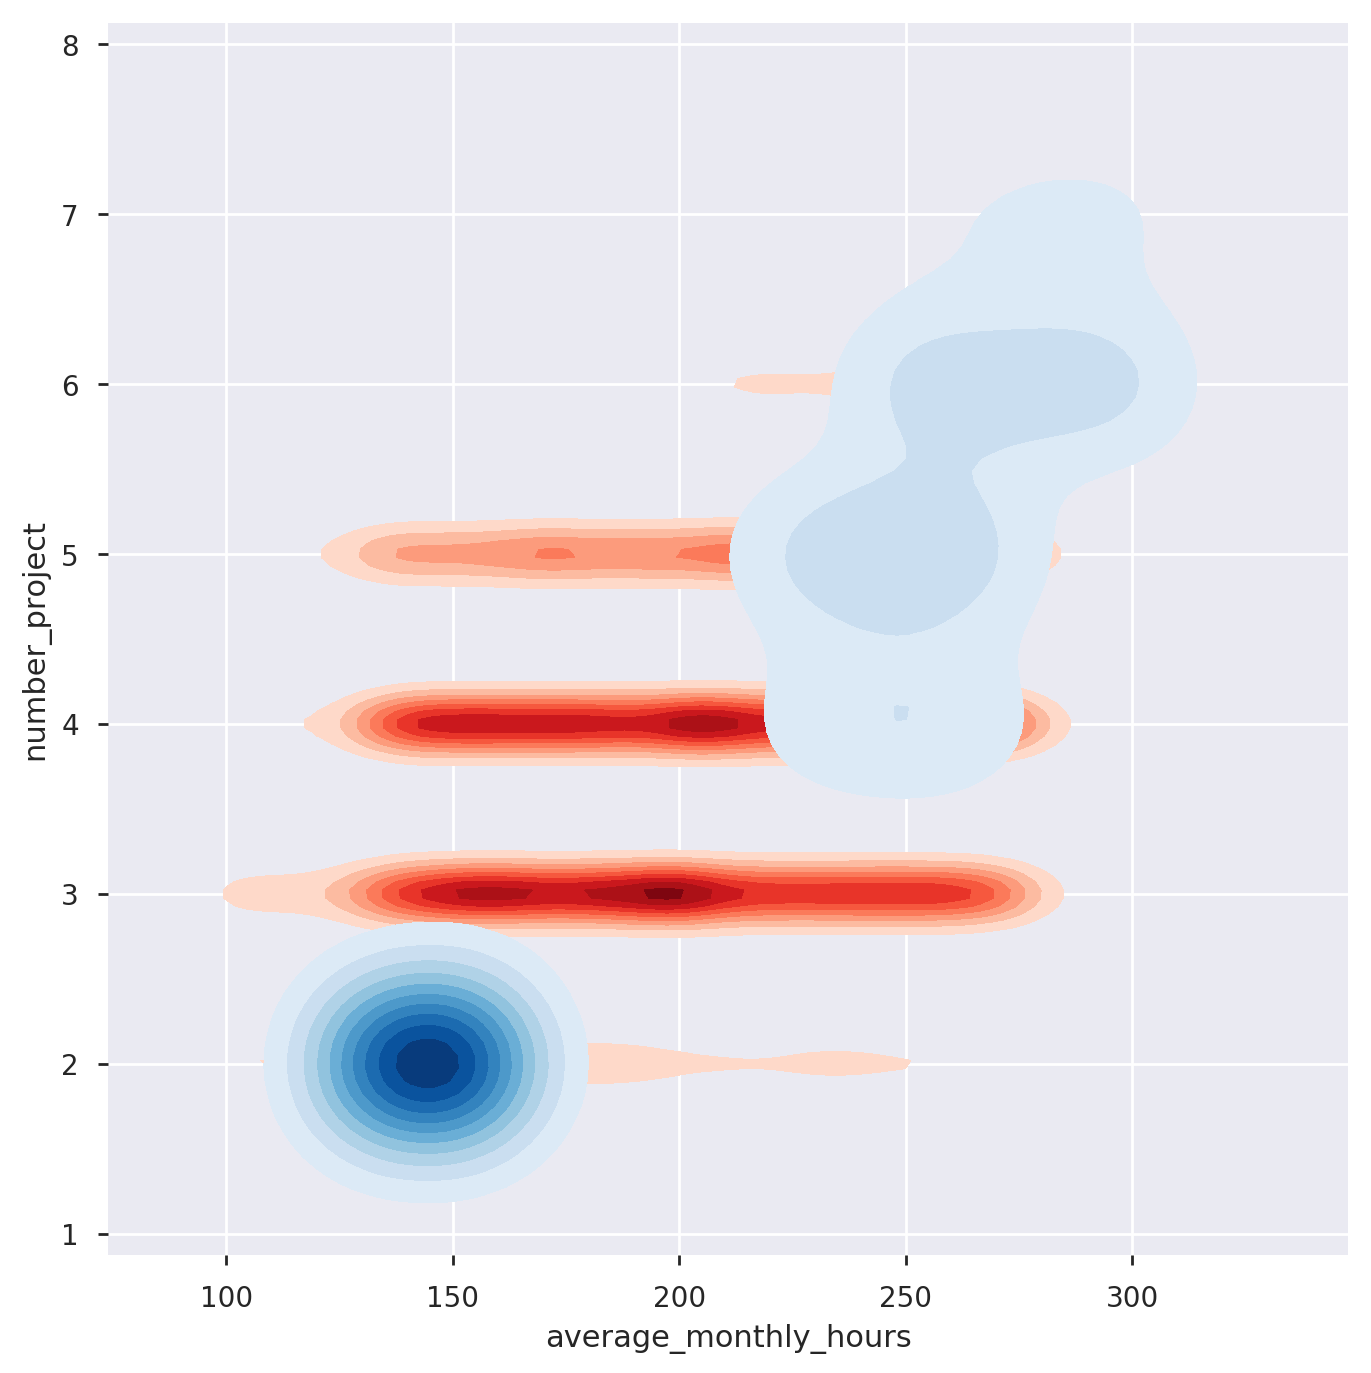

In [67]:
# segment the above plot with the response variable `quit`
fig, ax = plt.subplots()
plot_args = dict(shade=True, shade_lowest=False)
for i, c in zip((0, 1), ('Reds', 'Blues')):
    sns.kdeplot(hr.loc[hr.quit==i, 'average_monthly_hours'],
                hr.loc[hr.quit==i, 'number_project'],
                cmap=c, **plot_args)
#ax.text(0.05, 1.05, 'quit = 0', size=16, color=sns.color_palette('Reds')[-2])
#ax.text(0.25, 1.05, 'quit = 1', size=16, color=sns.color_palette('Blues')[-2])

These bivariate distribution plots show how the selected features are related to the target variable `left`.

In [74]:
# Split the data into training and testing sets, using only the selected two feature dependent variables 

from sklearn.model_selection import train_test_split

features = ['satisfaction_level', 'last_evaluation']
X_train, X_test, y_train, y_test = train_test_split(
    hr[features].values, hr['quit'].values,
    test_size=0.15, random_state=42)

In [75]:
# Scale the data for SVMs and K-Nearest Neighbors

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [76]:
# Train a support vector machine classifier (SVC)

from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train_std, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [77]:
# What is this SVC's classification accuracy?

from sklearn.metrics import accuracy_score

y_pred = svm.predict(X_test_std)
acc = accuracy_score(y_test, y_pred)
print('accuracy = {:.1f}%'.format(acc*100))

accuracy = 76.8%


We predict the targets for our test samples and then use scikit-learn's accuracy_score function to determine the accuracy. 

The result looks promising at ~76%! Not bad for our first model and using only two feature variables no less. Recall, though, the target variable is imbalanced between `quit` = 0 & 1. Let's see how accurate the predictions are for each class.

In [78]:
# What is this SVC's accuracy by class, i.e., by `left` categories? While this metric sounds simple, it is a statistically questionable concept. 

from sklearn.metrics import confusion_matrix

print('percent accuracy score per class:')
cmat = confusion_matrix(y_test, y_pred)
scores = cmat.diagonal() / cmat.sum(axis=1) * 100
print('quit = 0 : {:.2f}%'.format(scores[0]))
print('quit = 1 : {:.2f}%'.format(scores[1]))

percent accuracy score per class:
quit = 0 : 100.00%
quit = 1 : 0.00%


Terrible - it looks like the model is simply classifying every sample as 0, which is clearly not helpful at all. 

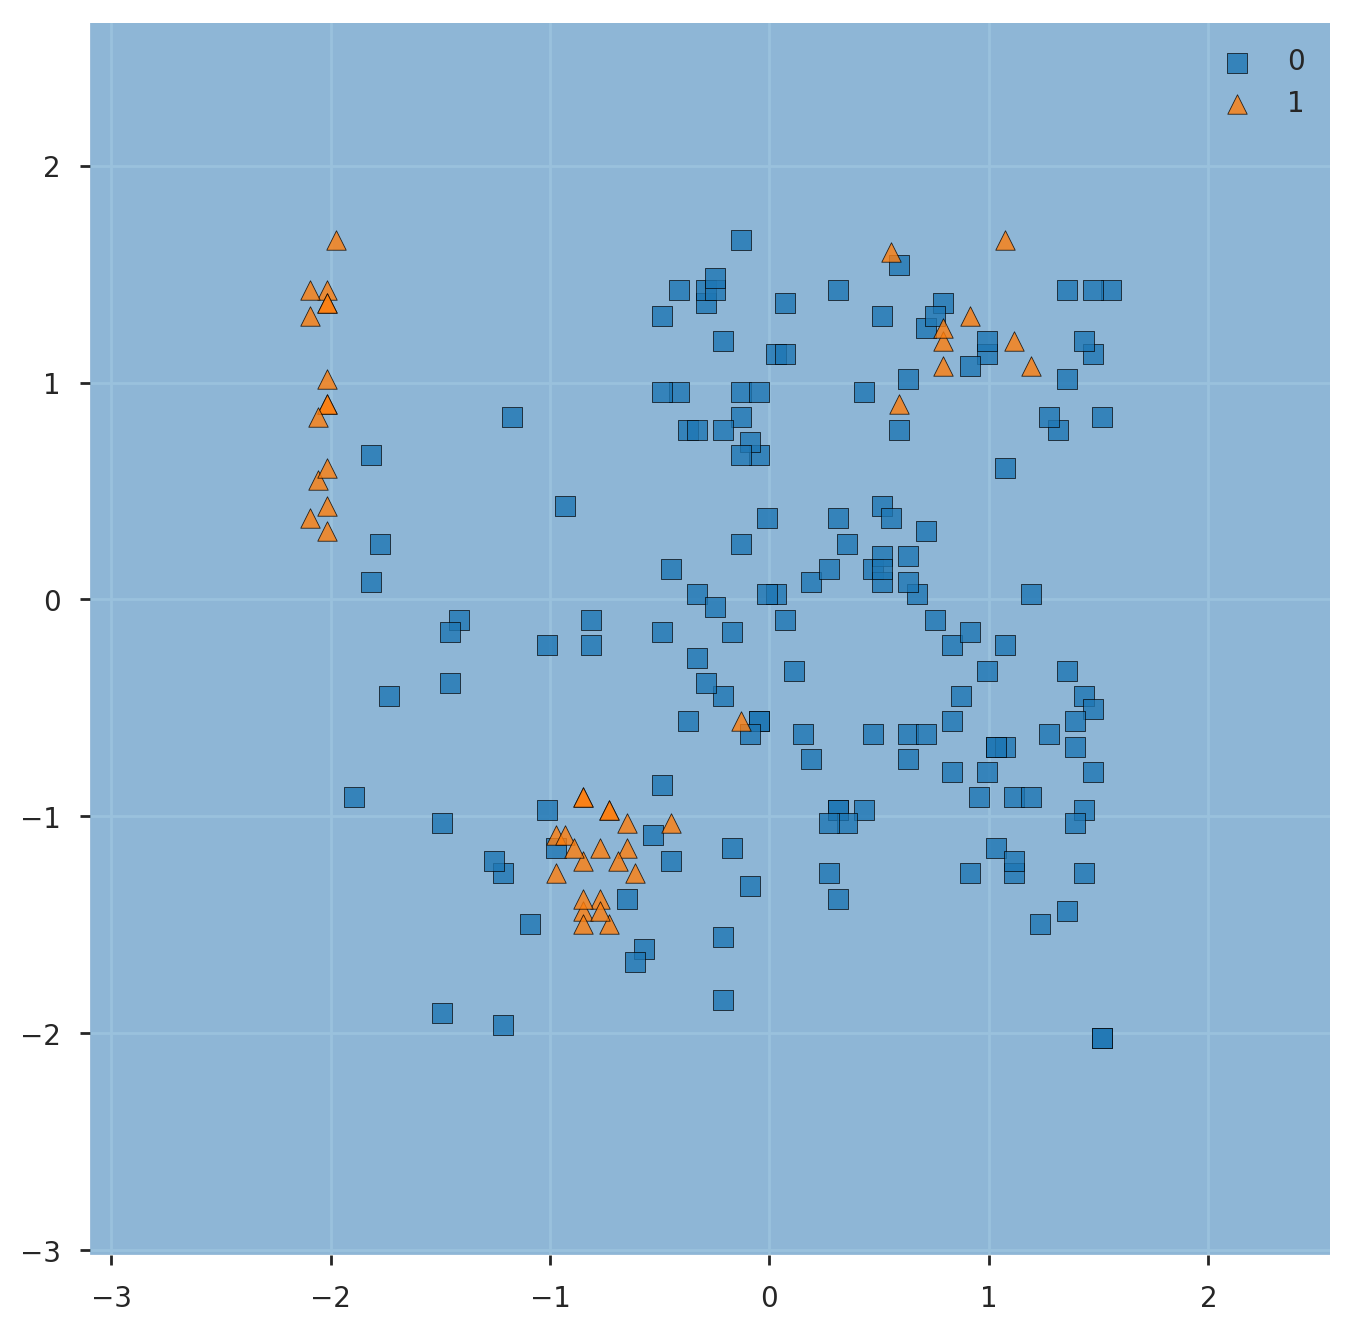

In [79]:
# Plot the resulting decision regions

from mlxtend.plotting import plot_decision_regions

N_samples = 200
X, y = X_train_std[:N_samples], y_train[:N_samples]
plot_decision_regions(X, y, clf=svm);

The `mlxtend` package plots decision regions along with a set of samples passed as arguments. In order to see the decision regions properly without too many samples obstructing our view, we pass only a 200-sample subset of the test data to its `plot_decision_regions` function. 

<p>In this case, of course, it does not matter. We see the resulting shaded region is <i>entirely</i> blue, indicating every point in the feature space would be classified as 0.

It shouldn't be surprising that a linear model can't do a good job of describing these nonlinear patterns. So let's re-run the SVC with `kernel = 'rbf'`, <i>i.e.</i>, we are running the support vector classifier (SVC) using its  radial basis function kernel (RBF). 

In [80]:
# Train a kernel SVM

svm = SVC(kernel='rbf', C=1, random_state=1)
svm.fit(X_train_std, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False)

In [81]:
# What is this kernel SVM's classification accuracy? Compare with SVC accuracy score above. 

from sklearn.metrics import accuracy_score

y_pred = svm.predict(X_test_std)
acc = accuracy_score(y_test, y_pred)
print('accuracy = {:.1f}%'.format(acc*100))

accuracy = 90.4%


As expected, the nonlinear parameter performs much better than linear for our data. Keep in mind that `rbf` is often called a kernel trick with SVCs to get better model performance. Now let's plot the results visually.

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import display
from mlxtend.plotting import plot_decision_regions

def check_model_fit(clf, X_test, y_test):
    # Print overall test-set accuracy
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred, normalize=True) * 100
    print('total accuracy = {:.1f}%'.format(acc))
    
    # Print confusion matrix
    cmat = confusion_matrix(y_test, y_pred)
    cols = pd.MultiIndex.from_tuples([('predictions', 0), ('predictions', 1)])
    indx = pd.MultiIndex.from_tuples([('actual', 0), ('actual', 1)])
    display(pd.DataFrame(cmat, columns=cols, index=indx))
    print()
    
    # Print test-set accuracy grouped by the target variable 
    print('percent accuracy score per class:')
    cmat = confusion_matrix(y_test, y_pred)
    scores = cmat.diagonal() / cmat.sum(axis=1) * 100
    print('left = 0 : {:.2f}%'.format(scores[0]))
    print('left = 1 : {:.2f}%'.format(scores[1]))
    print()
    
    # Plot decision regions
    fig = plt.figure(figsize=(8, 8))
    N_samples = 200
    X, y = X_test[:N_samples], y_test[:N_samples]
    plot_decision_regions(X, y, clf=clf)
    
    plt.xlabel('satisfaction_level')
    plt.ylabel('last_evaluation')
    plt.legend(loc='upper left')

total accuracy = 90.4%


predictions     
                   0    1
actual 0        1683   46
       1         169  352


percent accuracy score per class:
left = 0 : 97.34%
left = 1 : 67.56%



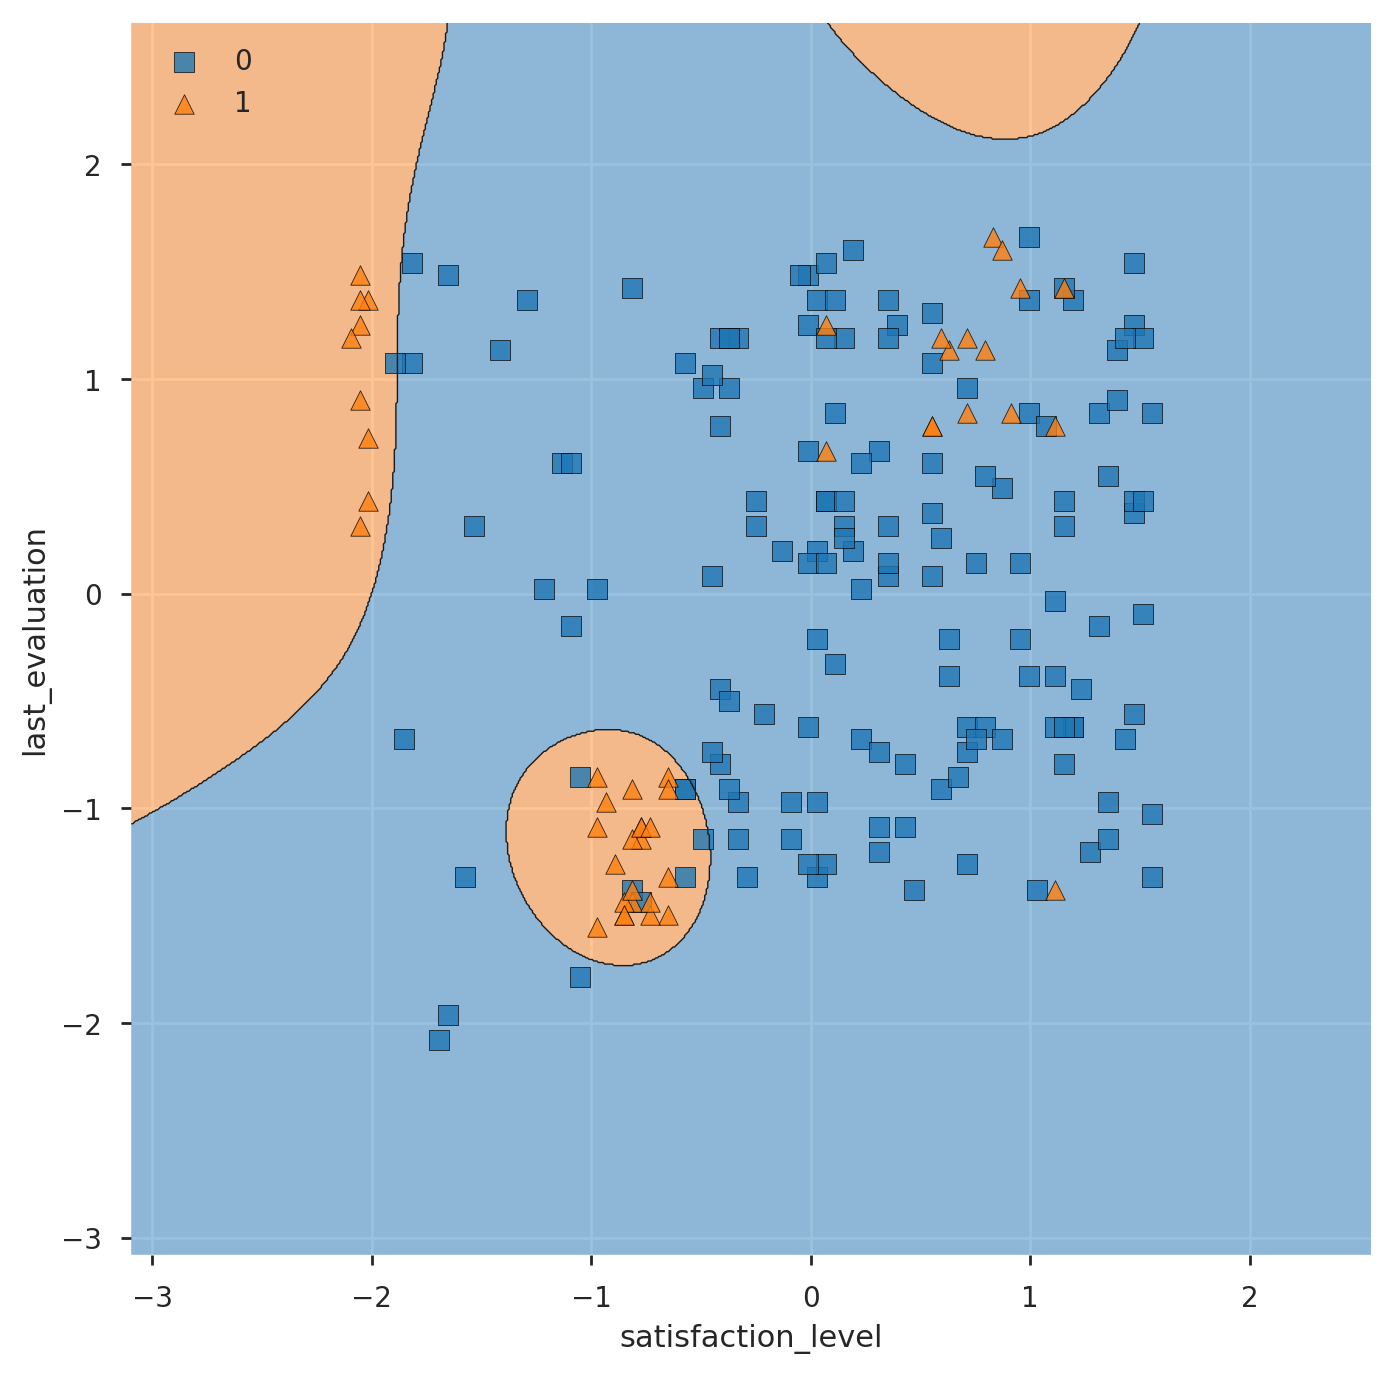

In [83]:
check_model_fit(svm, X_test_std, y_test)

### Building a K-Nearest Neighbors (KNN) Classifier

total accuracy = 90.6%


predictions     
                   0    1
actual 0        1622   98
       1         113  417


percent accuracy score per class:
left = 0 : 94.30%
left = 1 : 78.68%



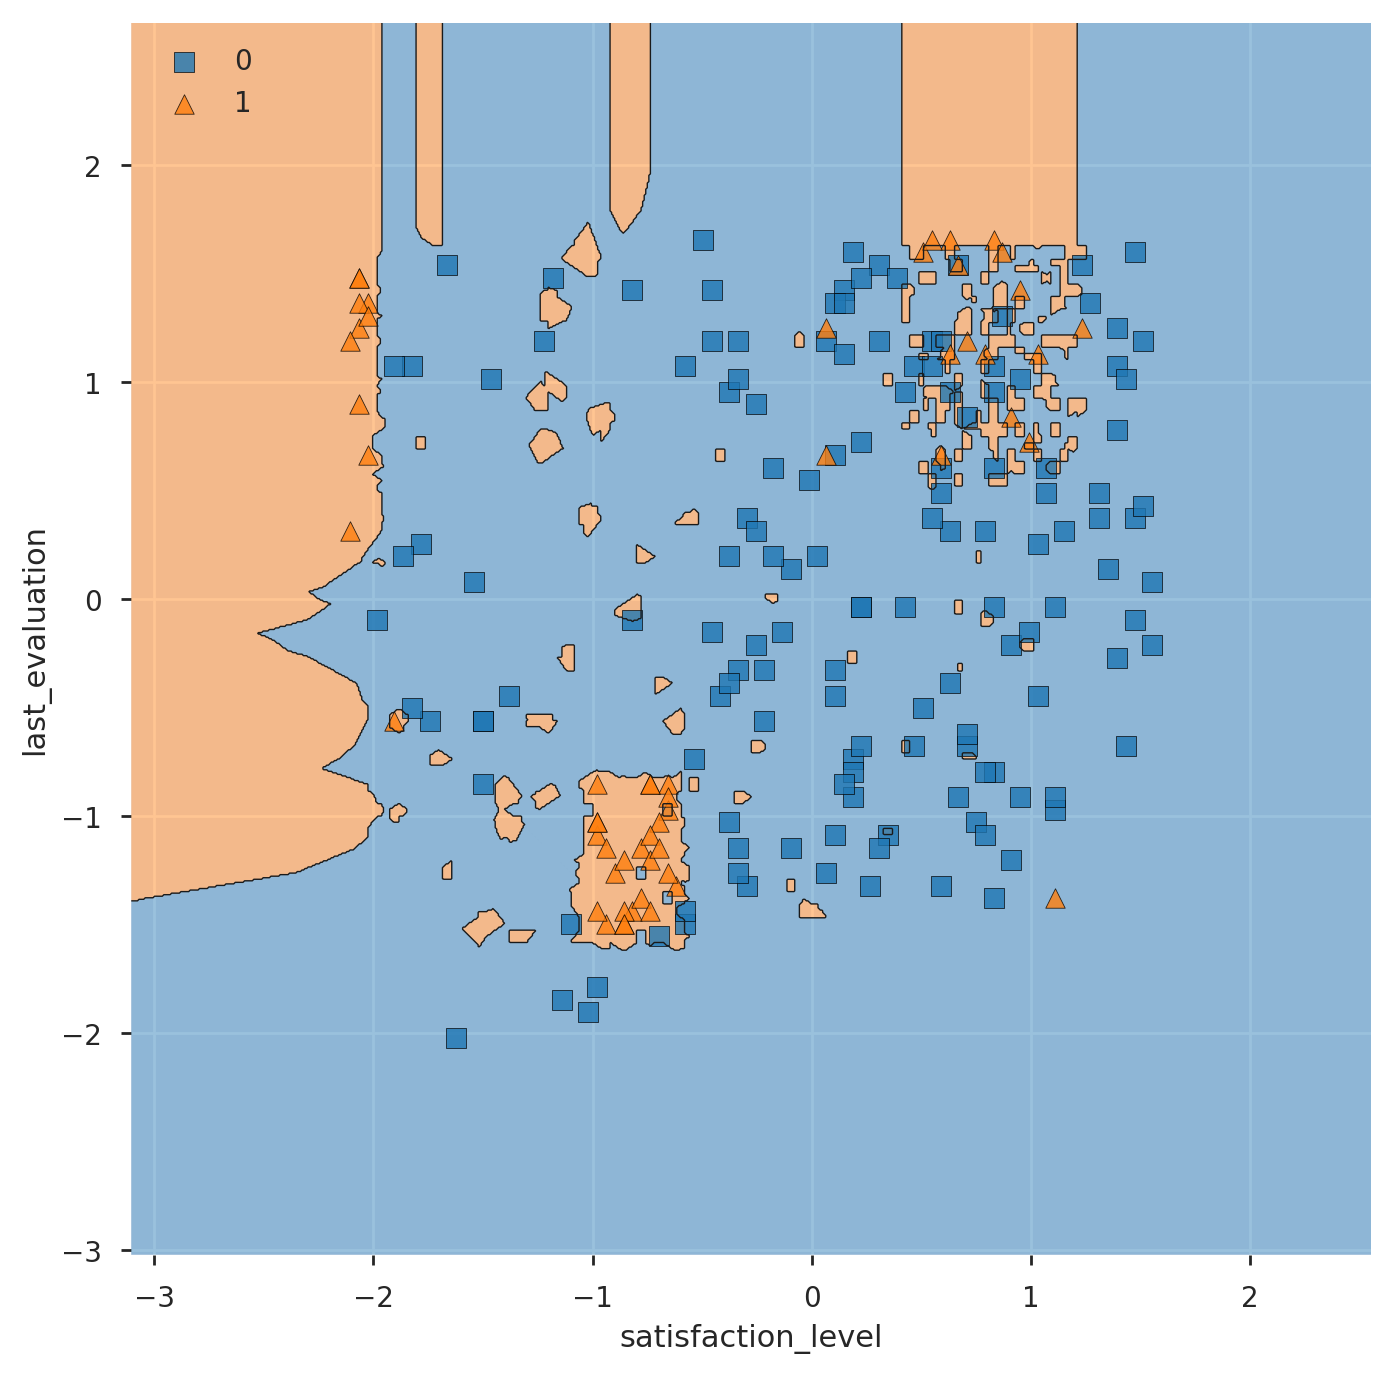

In [51]:
from sklearn.neighbors import KNeighborsClassifier

# Train a K-Nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_std, y_train)

check_model_fit(knn, X_test_std, y_test)

total accuracy = 91.2%


predictions     
                   0    1
actual 0        1657   63
       1         134  396


percent accuracy score per class:
left = 0 : 96.34%
left = 1 : 74.72%



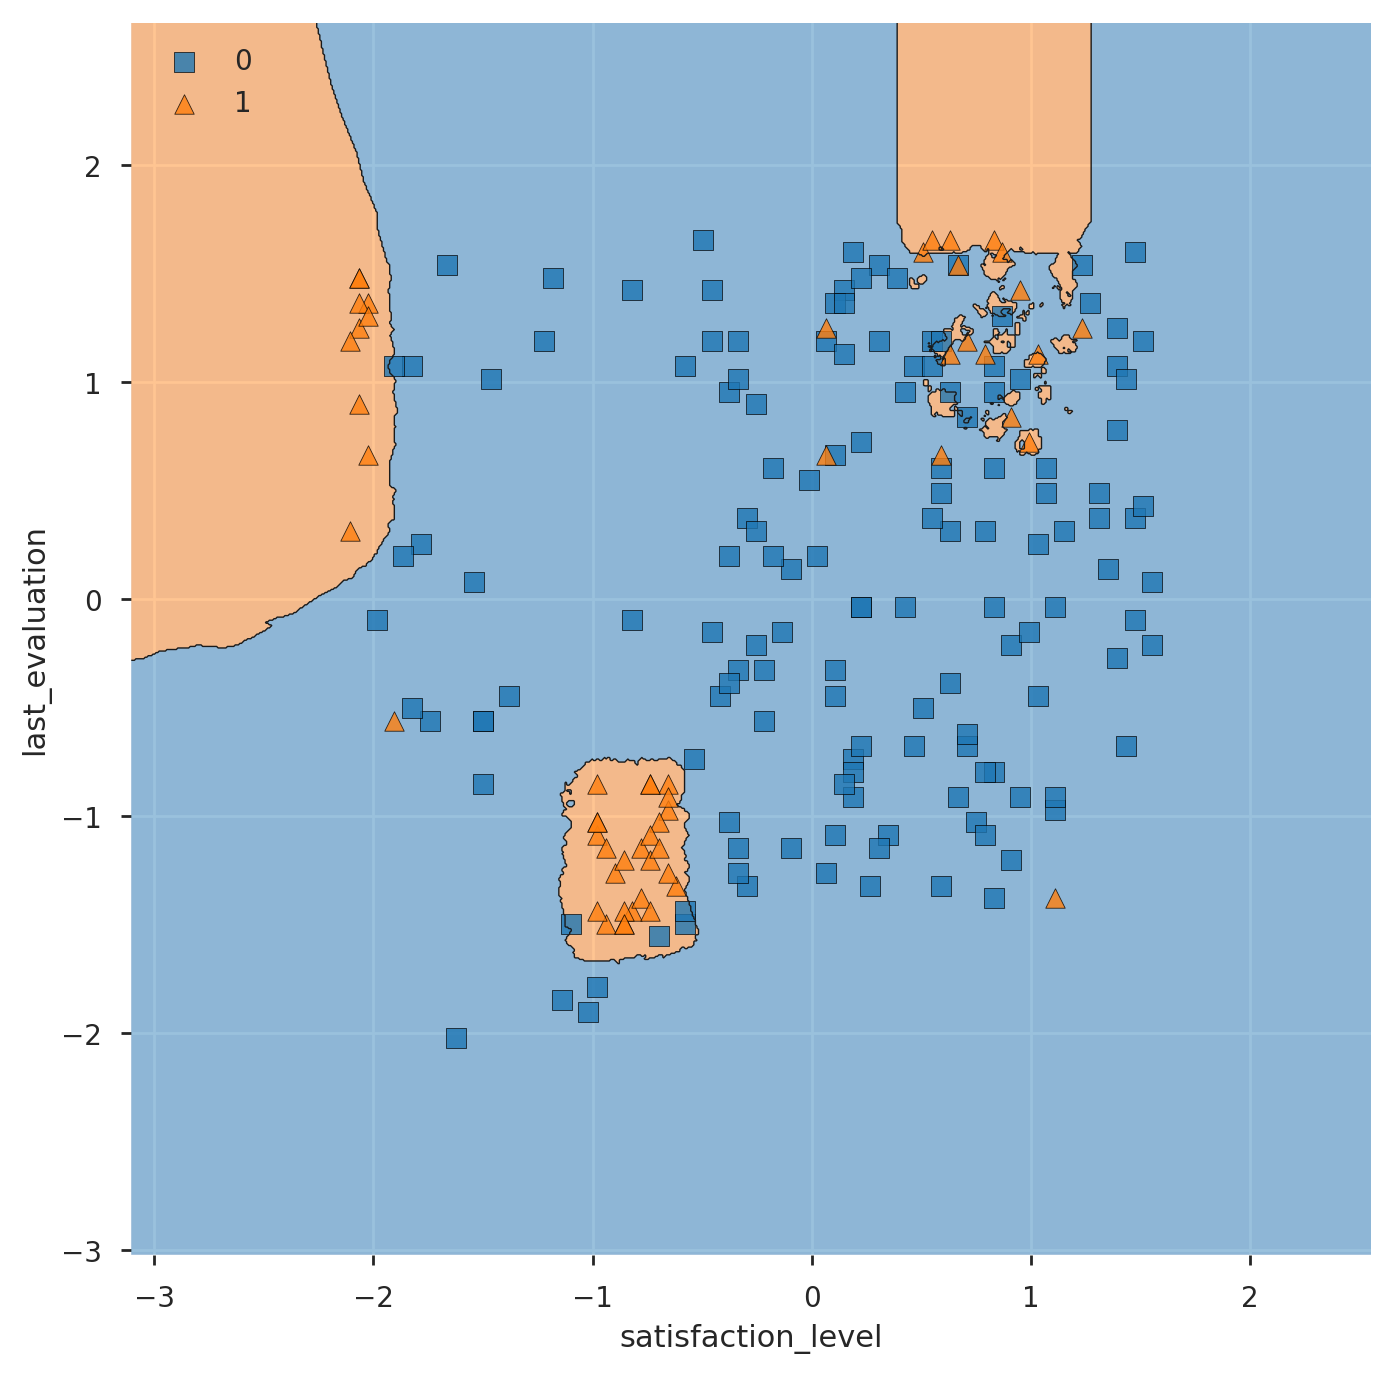

In [52]:
# Increase the number of "nearest neighbors" to reduce overfitting

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_std, y_train)

check_model_fit(knn, X_test_std, y_test)

### Training a Random Forest

total accuracy = 91.6%


predictions     
                   0    1
actual 0        1694   26
       1         163  367


percent accuracy score per class:
left = 0 : 98.49%
left = 1 : 69.25%



(0.2, 1.2)

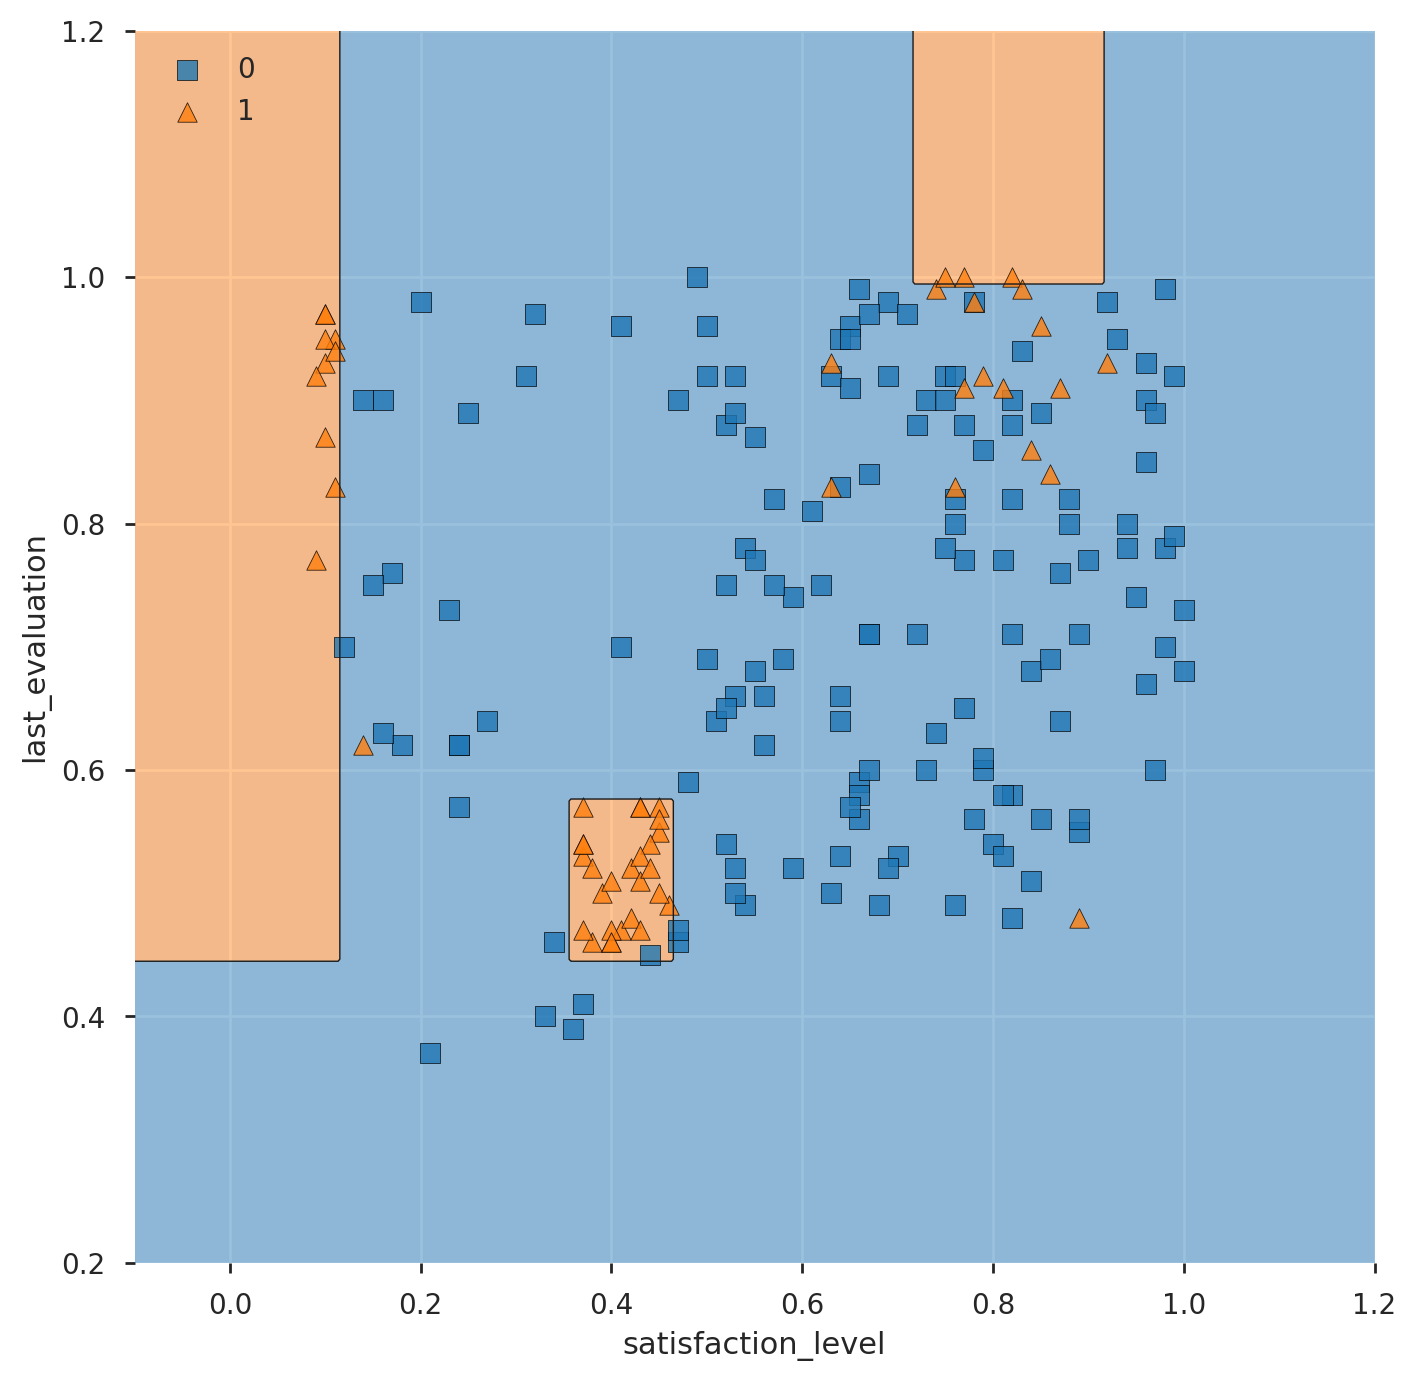

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=50, max_depth=5,
                                random_state=1)
forest.fit(X_train, y_train)

check_model_fit(forest, X_test, y_test)
plt.xlim(-0.1, 1.2)
plt.ylim(0.2, 1.2)

Note the distinctive axes-parallel decision boundaries produced by decision tree machine learning algorithms.

In [ ]:
# DO NOT RUN THIS CELL -- `graphviz` package just cannot be installed on OS X Mojave
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image, display
import graphviz

dot_data = export_graphviz(
                forest.estimators_[0],
                out_file=None, 
                feature_names=features,  
                class_names=['no', 'yes'],  
                filled=True, rounded=True,  
                special_characters=True)
graph = graphviz.Source(dot_data)
graph

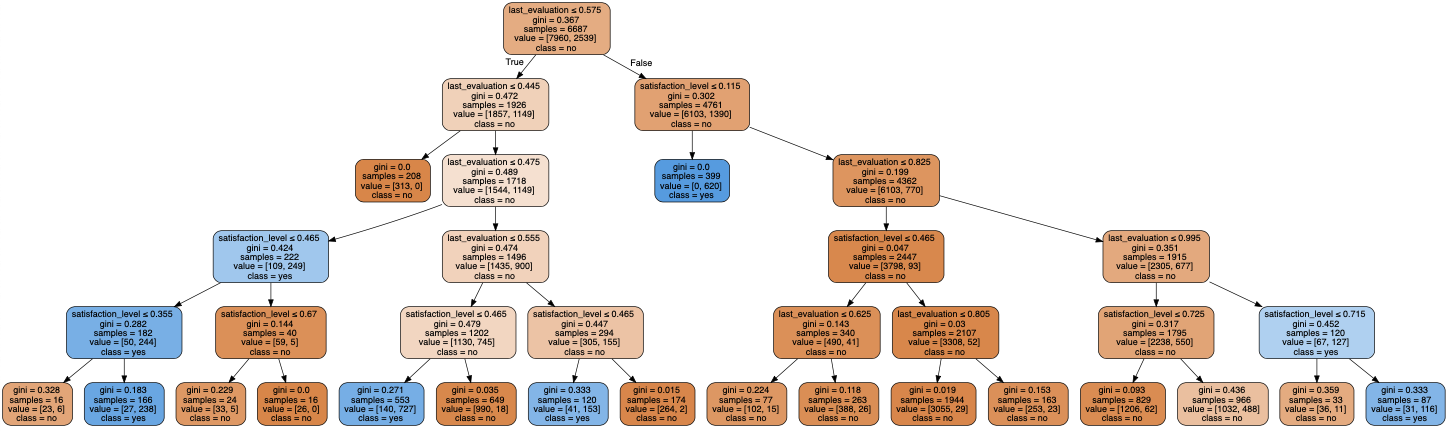

In [157]:
from IPython.display import Image
Image("Graphviz_hr_image051.png")

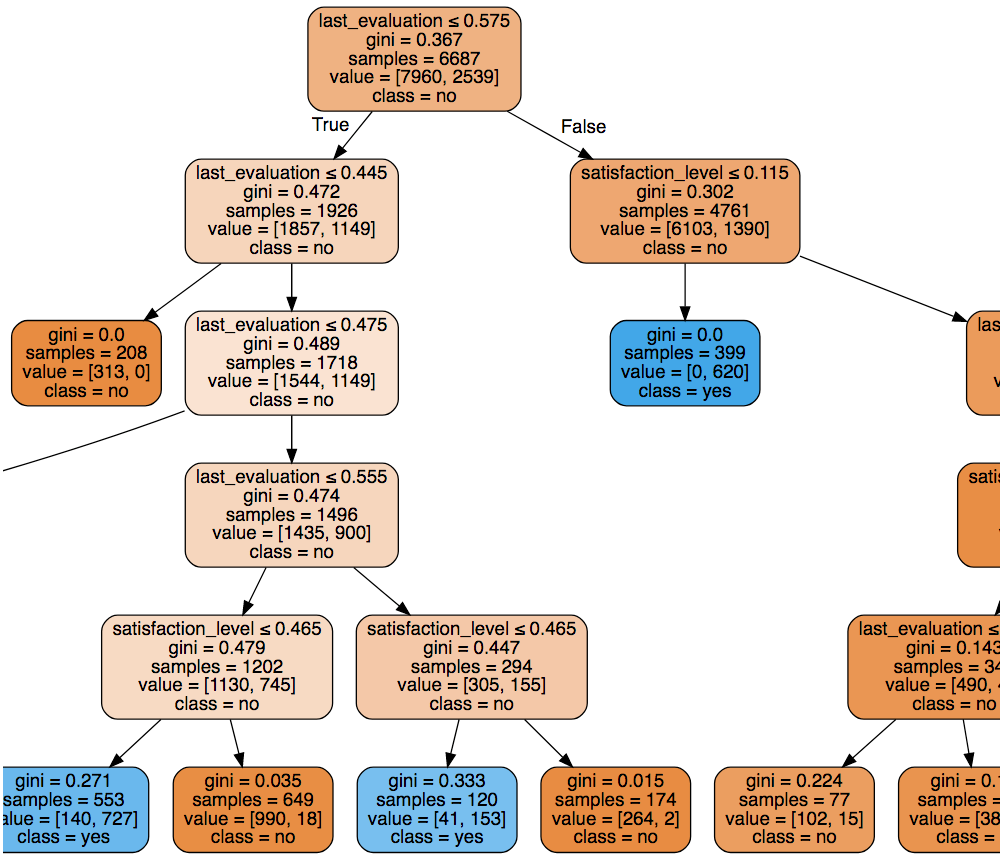

In [158]:
Image("Graphviz_hr_image050.png")

---

## Training and Testing the Classification Algorithms

Now that we have preprocessed the data and built our training and testing datasets, we can start to deploy different classification algorithms. It's relatively easy to test multiple models; as a result, we will compare and contrast the performance of ten different algorithms.

In [84]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 21 columns):
satisfaction_level        15000 non-null float64
last_evaluation           15000 non-null float64
number_project            15000 non-null int64
average_monthly_hours     15000 non-null float64
time_spend_company        15000 non-null float64
work_accident             15000 non-null int64
quit                      15000 non-null int64
promotion_last_5years     15000 non-null int64
department_IT             15000 non-null uint8
department_RandD          15000 non-null uint8
department_accounting     15000 non-null uint8
department_hr             15000 non-null uint8
department_management     15000 non-null uint8
department_marketing      15000 non-null uint8
department_product_mng    15000 non-null uint8
department_sales          15000 non-null uint8
department_support        15000 non-null uint8
department_technical      15000 non-null uint8
salary_high               15000 non-n

In [86]:
# Create X and Y datasets for training
# Select training/validation set

features = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium']

X = hr[features].values
y = hr.quit.values

In [160]:
# Simpler code to split the training test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [87]:
# Use the model_selection module to separate training and testing datasets
from sklearn import model_selection


# define seed for reproducibility
seed = 42

# split data into training and testing datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.15, random_state=seed)

<i>Cell below is self-contained. Discuss live using saved output, because running it takes 8 minutes due to neural network! 

In [88]:
# Now that we have our dataset, we can start building algorithms! We'll need to import each algorithm we plan on using
# from sklearn.  We also need to import some performance metrics, such as accuracy_score and classification_report.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier

# define scoring method
scoring = 'accuracy'

# Define models to train
#names = ["Nearest Neighbors", "Gaussian Process",
#         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
#         "Naive Bayes", "SVM Linear", "SVM RBF", "SVM Sigmoid"]

names = ["Nearest Neighbors",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "XGBoost"]

#classifiers = [
#    KNeighborsClassifier(n_neighbors = 8),
#    GaussianProcessClassifier(1.0 * RBF(1.0)),
#    DecisionTreeClassifier(max_depth=9),
#    RandomForestClassifier(max_depth=9, n_estimators=10, max_features=1),
#    MLPClassifier(alpha=10, solver='lbfgs', hidden_layer_sizes=[100], max_iter=2000, activation='logistic'),
#    AdaBoostClassifier(),
#    GaussianNB(),
#    SVC(kernel = 'linear', gamma='auto'), 
#    SVC(kernel = 'rbf', gamma='auto'),
#    SVC(kernel = 'sigmoid', gamma='auto')
#]

classifiers = [
    KNeighborsClassifier(n_neighbors = 8),
    DecisionTreeClassifier(max_depth=9),
    RandomForestClassifier(max_depth=9, n_estimators=10, max_features=1),
    MLPClassifier(alpha=10, solver='lbfgs', hidden_layer_sizes=[100], max_iter=2000, activation='logistic'),
    AdaBoostClassifier(),
    GaussianNB(),
    XGBClassifier()
]


models = list(zip(names, classifiers))

# evaluate each model in turn
results = []
names = []

print("Accuracy cross-validation average (with standard deviation) for each model -")
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Accuracy cross-validation average (with standard deviation) for each model -
Nearest Neighbors: 0.938510 (0.010161)
Decision Tree: 0.977176 (0.004067)
Random Forest: 0.924627 (0.005704)
Neural Net: 0.925961 (0.010100)
AdaBoost: 0.956941 (0.005015)
Naive Bayes: 0.634980 (0.013125)
XGBoost: 0.974353 (0.005010)


In [89]:
names

['Nearest Neighbors',
 'Decision Tree',
 'Random Forest',
 'Neural Net',
 'AdaBoost',
 'Naive Bayes',
 'XGBoost']

In [90]:
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot

# Remember, performance on the training data is not that important. We want to know how well our algorithms
# can generalize to new data.  To test this, let's make predictions on the validation dataset.

for name, model in list(models):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name)
    print('Accuracy on test split: %.5f' % accuracy_score(y_test, predictions))
    score = roc_auc_score(y_test, predictions)
    print('AUC: %.4f' % score)
    print(classification_report(y_test, predictions))

# Accuracy - ratio of correctly predicted observation to the total observations. 

# Precision - (false positives) ratio of correctly predicted positive observations to the total predicted 
# positive observations

# Recall (Sensitivity) - (false negatives) ratio of correctly predicted positive observations to the all 
# observations in actual class - yes.

# F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both 
# false positives and false 

Nearest Neighbors
Accuracy on test split: 0.94667
AUC: 0.9291
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1729
           1       0.88      0.90      0.89       521

   micro avg       0.95      0.95      0.95      2250
   macro avg       0.92      0.93      0.93      2250
weighted avg       0.95      0.95      0.95      2250

Decision Tree
Accuracy on test split: 0.97644
AUC: 0.9579
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1729
           1       0.97      0.92      0.95       521

   micro avg       0.98      0.98      0.98      2250
   macro avg       0.98      0.96      0.97      2250
weighted avg       0.98      0.98      0.98      2250

Random Forest
Accuracy on test split: 0.93111
AUC: 0.8580
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1729
           1       0.97      0.72      0.83       521

   m

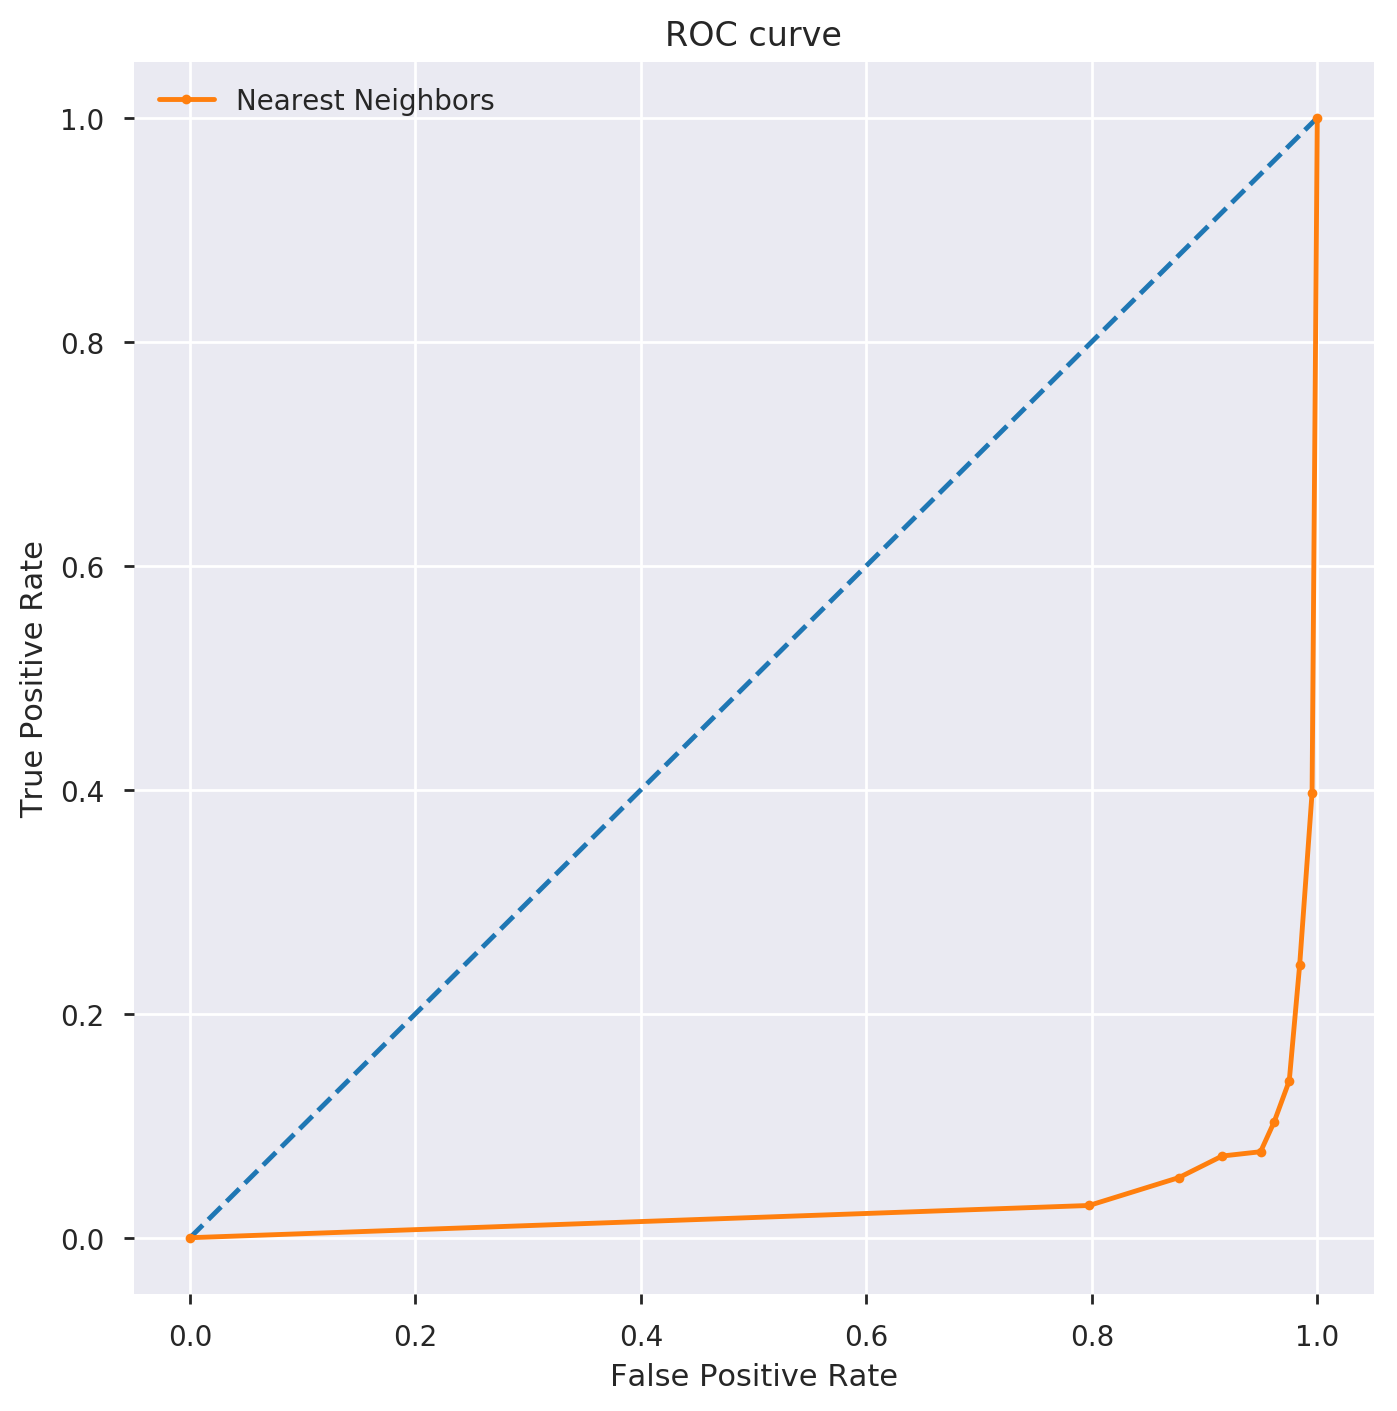

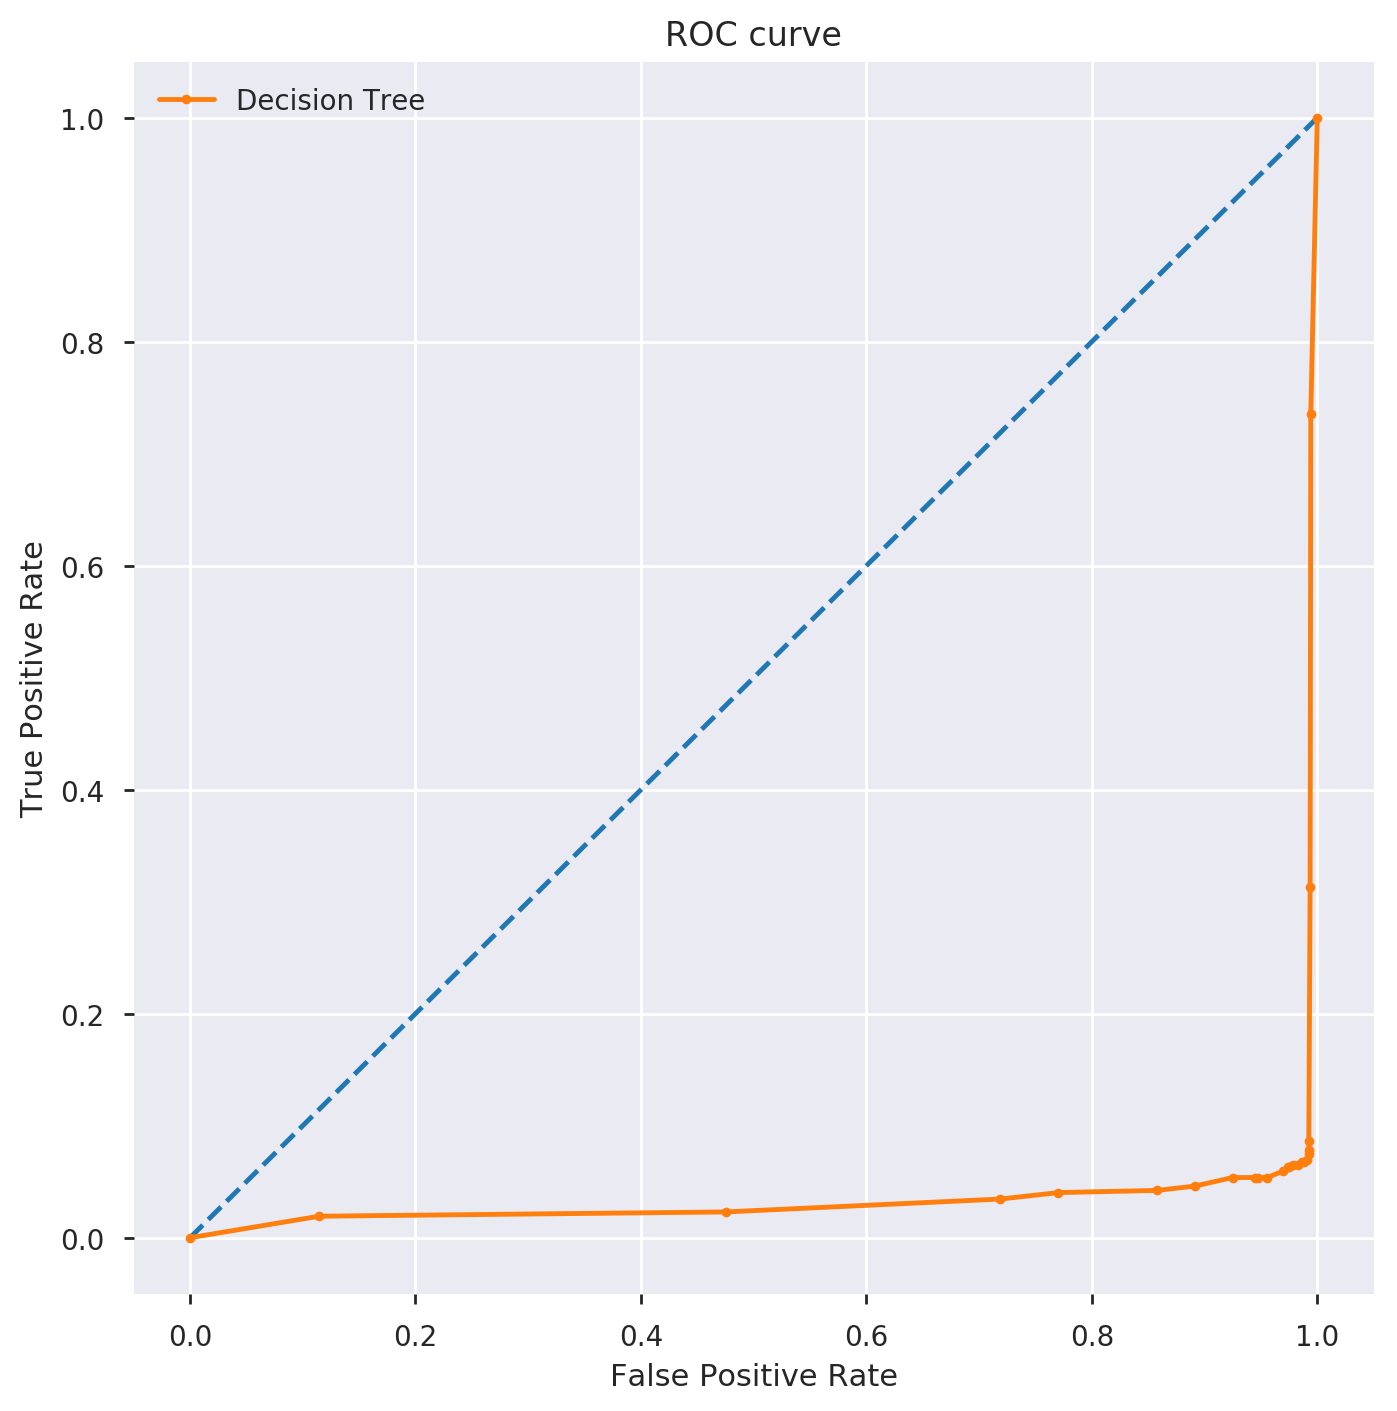

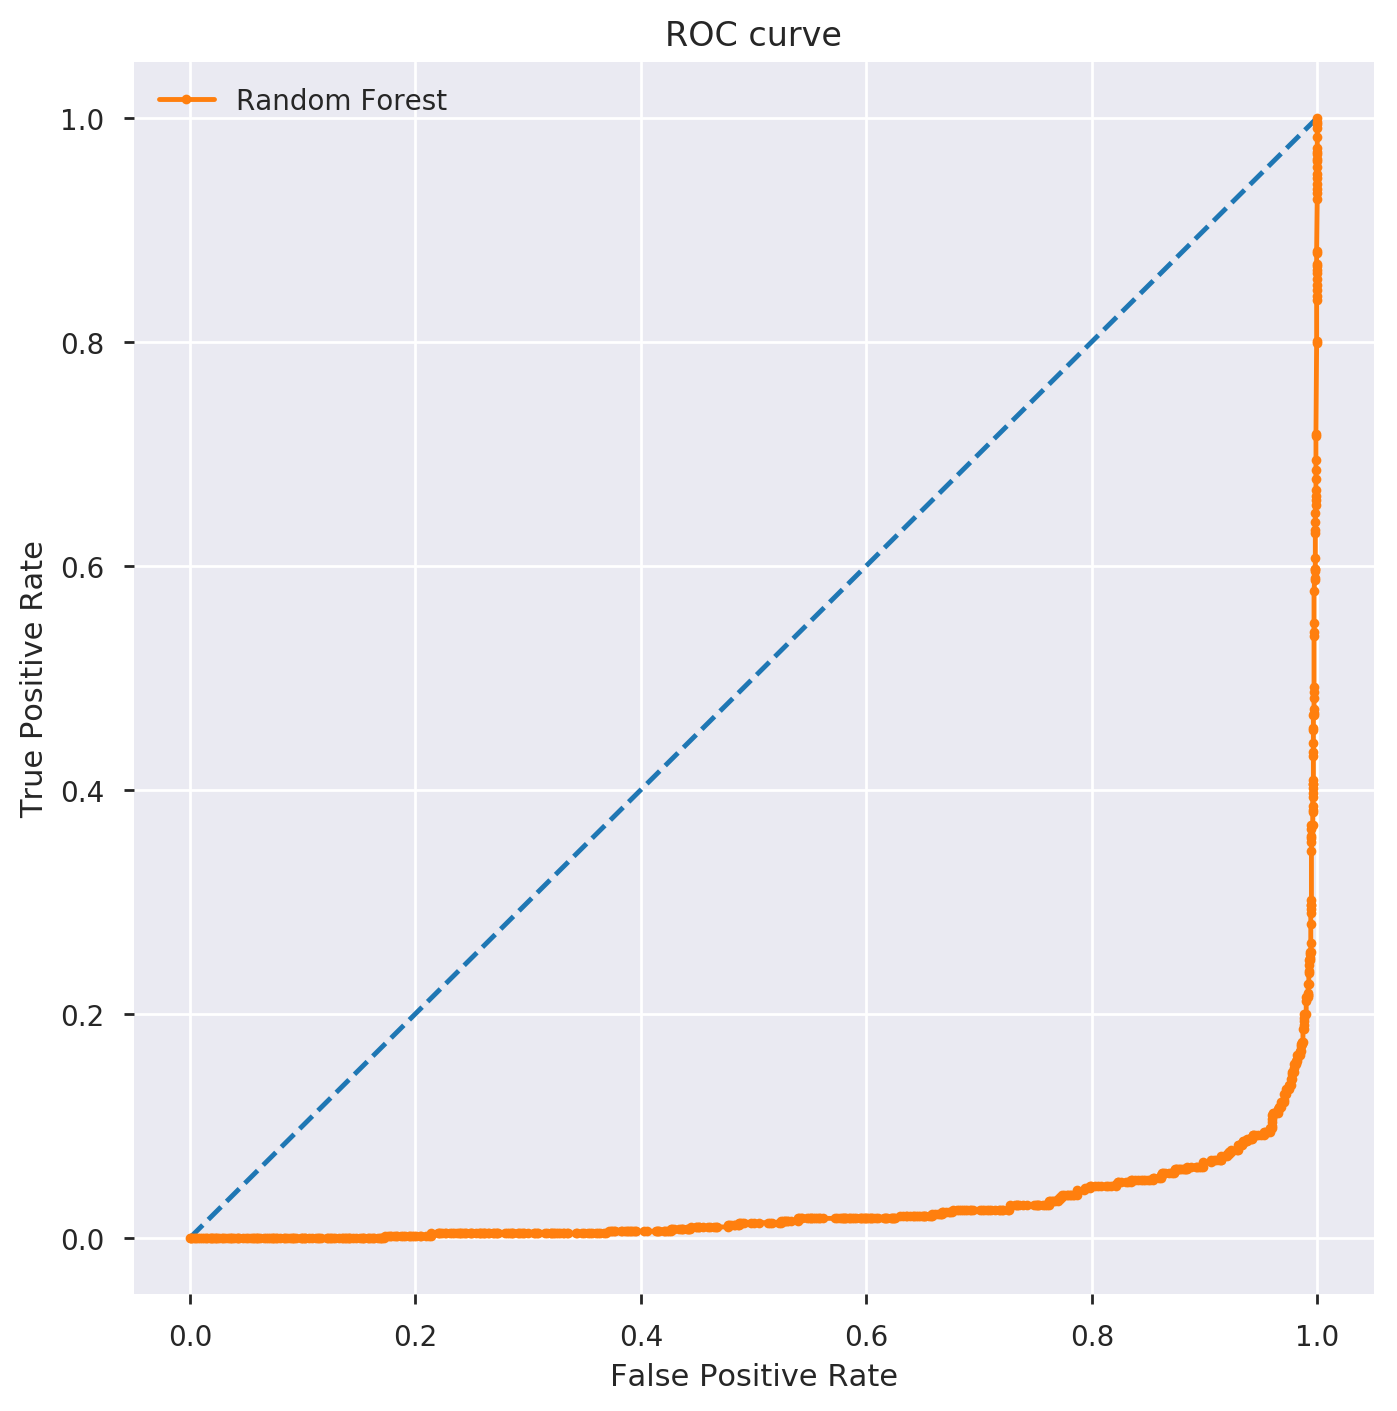

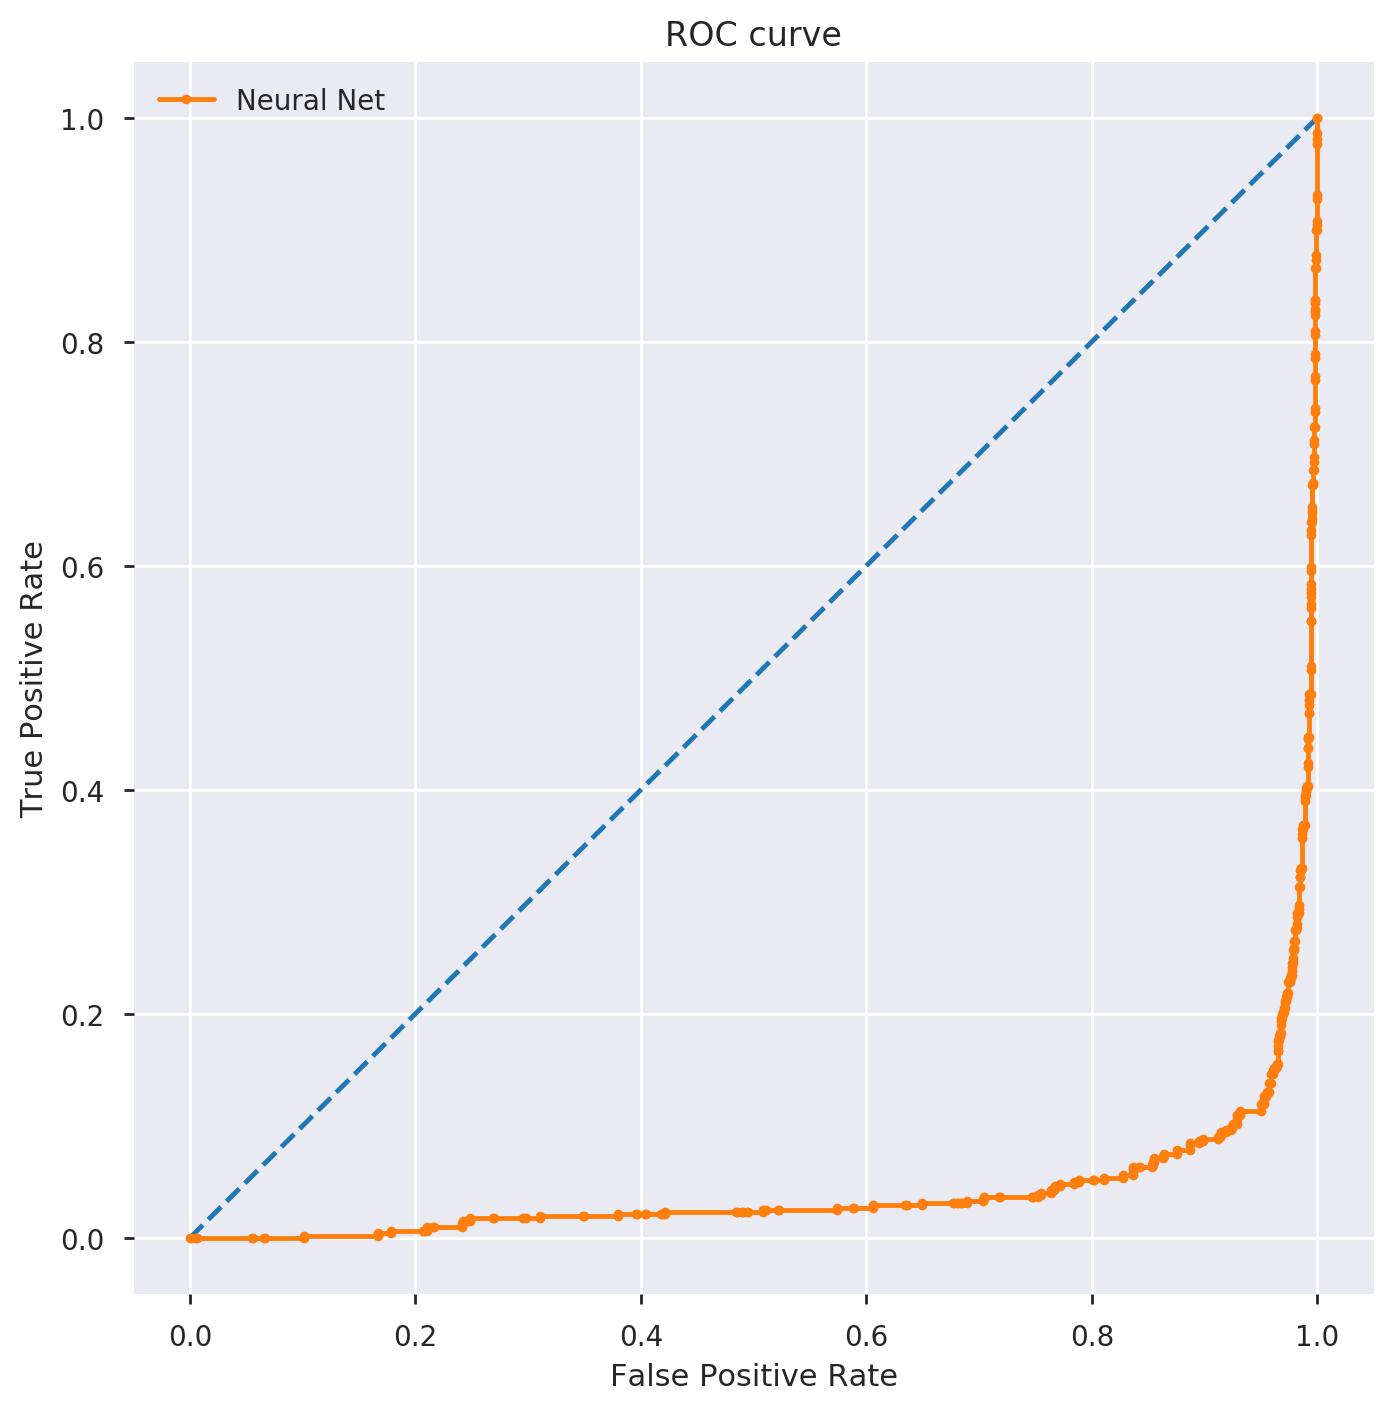

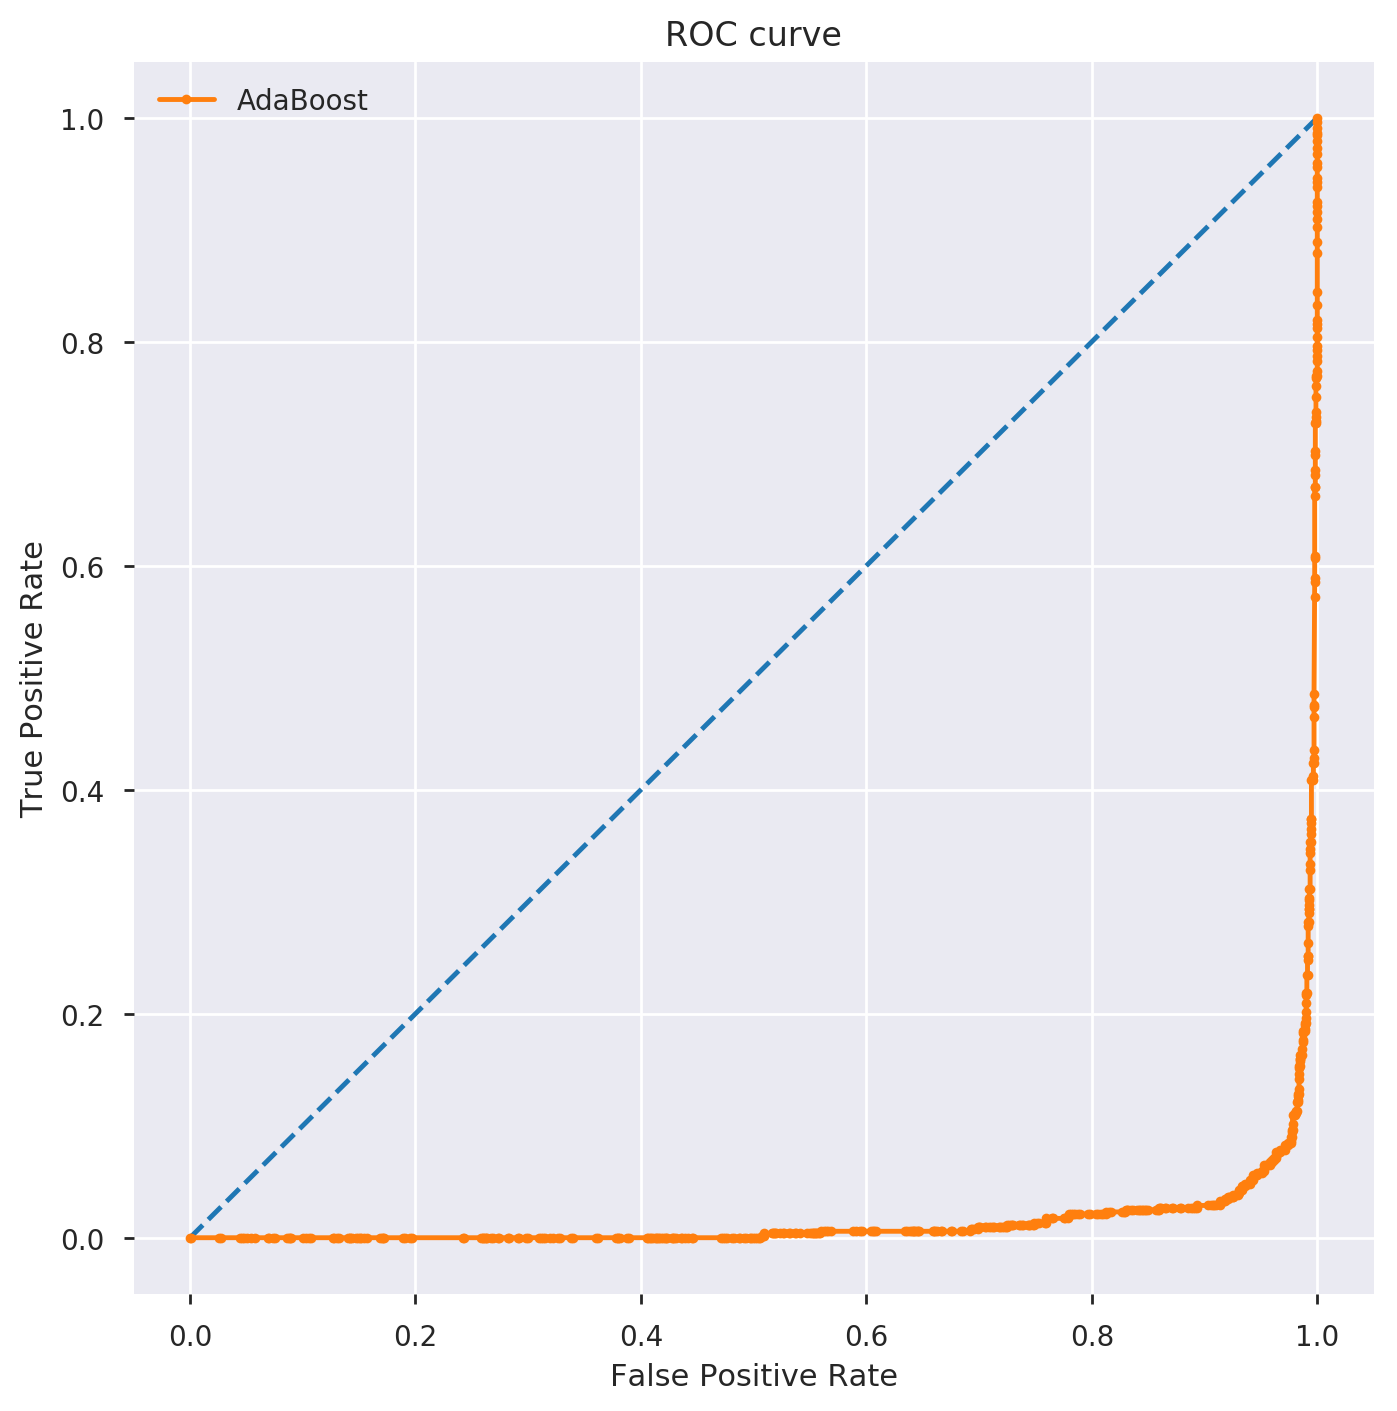

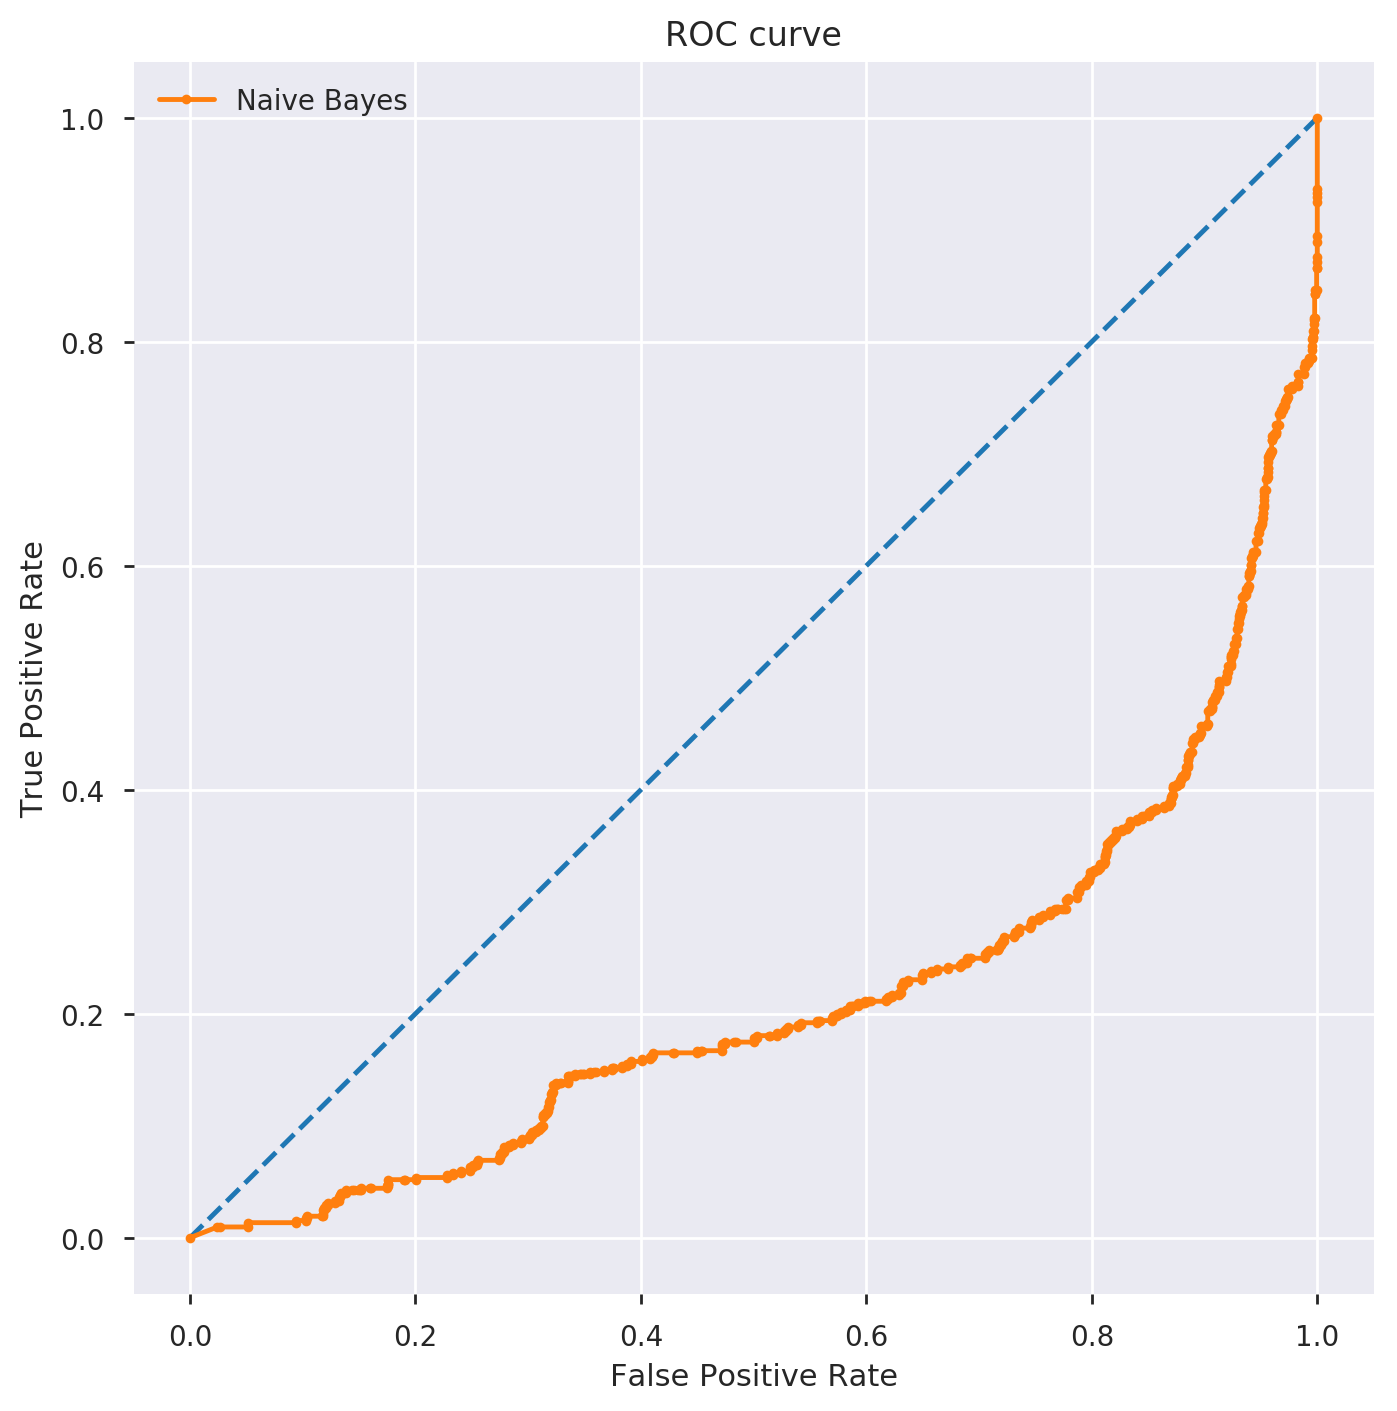

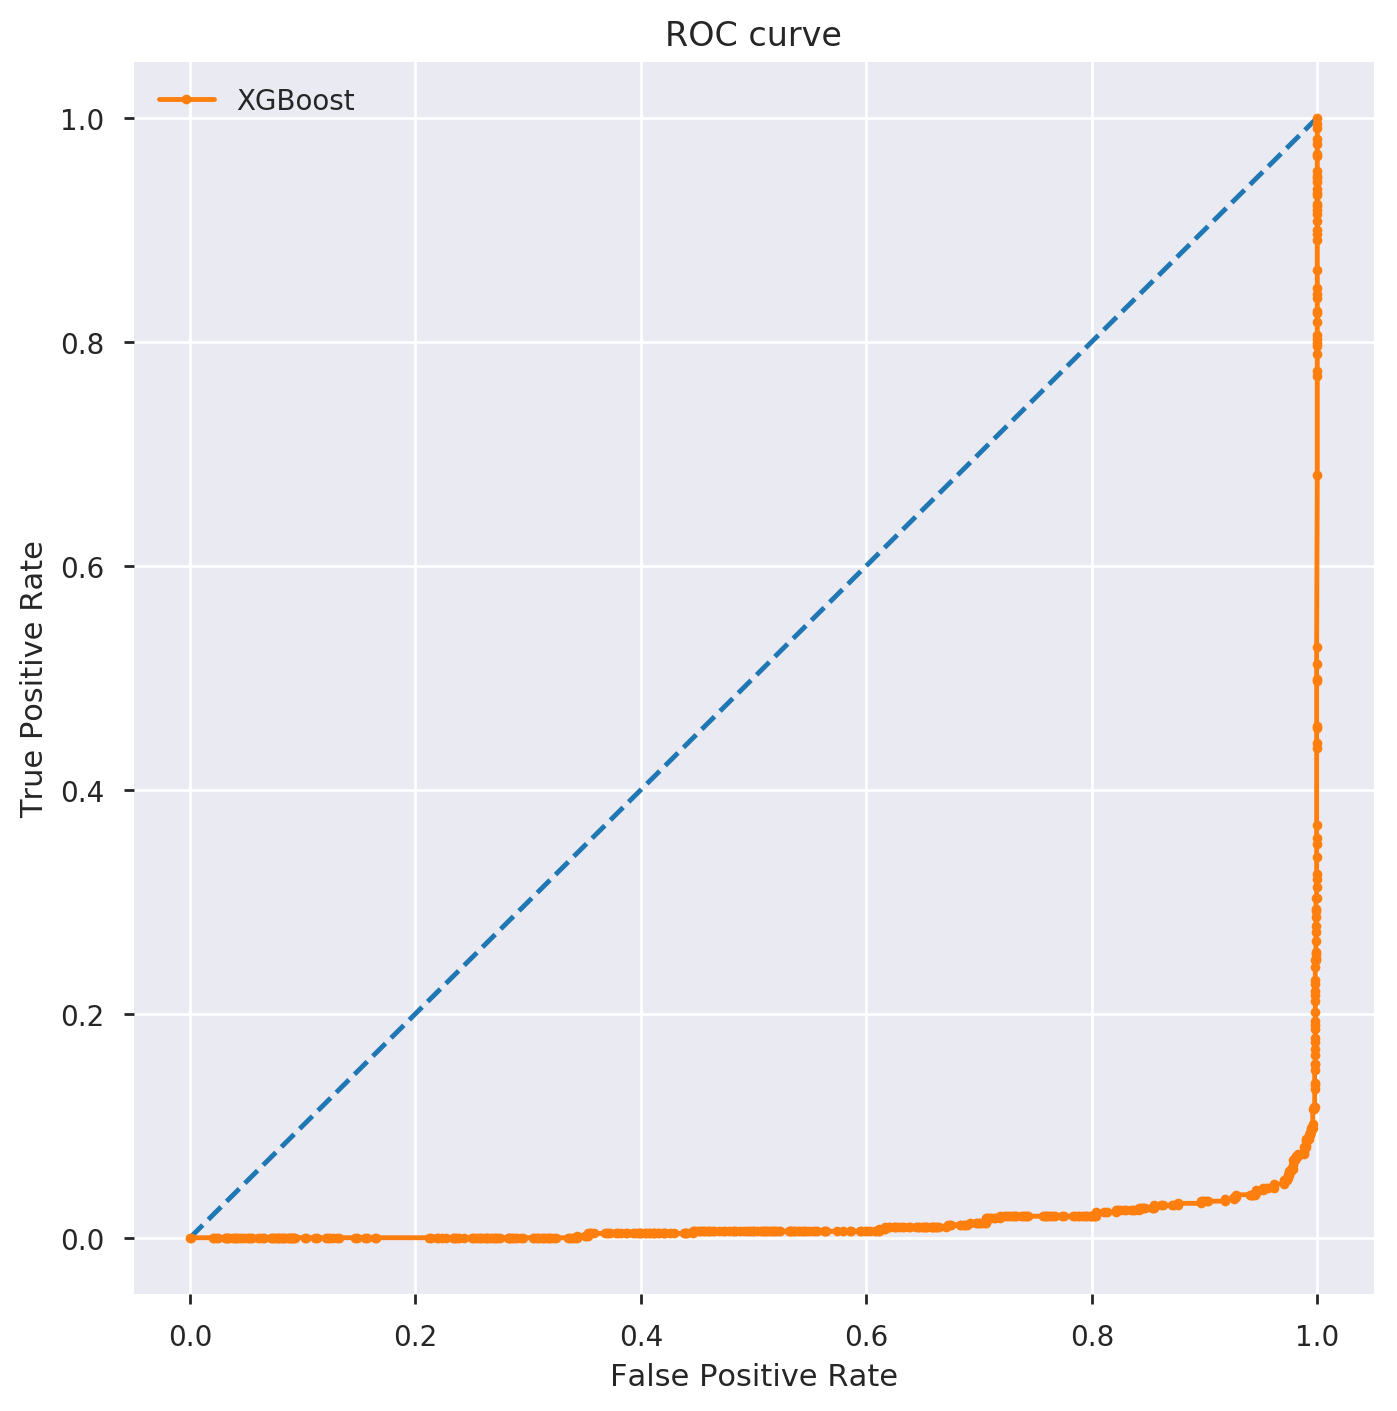

In [91]:
for name, model in list(models):
    prob_score = []
    # predict probabilities
    prob_score = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    prob_score = prob_score[:, 1]
    fpr,tpr,thresholds = roc_curve(y_test,1-prob_score)
    # Plot the roc curve for this model
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.', label = name)
    plt.xlim([-.05, 1.05])
    plt.ylim([-.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    pyplot.show()

--- 
## Building a full model

### Commentary
This is classic p-value hacking! Picking models this way makes it very easy to increase accuracy on a training dataset by overfitting a model, which can result in poorer performance on unseen data.

Furthermore, using only one training/test split to compare models can introduce bias towards certain models and contribute to overfitting.

<b>K-fold cross validation</b> offers a solution to this problem and allows the variance to be accounted for by way of an error estimate on each accuracy calculation. This, in turn, naturally leads to the use of validation curves for tuning model parameters.

In [95]:
# Function to draw the validation curve

def plot_validation_curve(train_scores, test_scores,
                          param_range, xlabel='', log=False):
    '''
    This code is from scikit-learn docs:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    
    Also here:
    https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch06/ch06.ipynb
    '''
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    return fig

In [96]:
# Custom function for class accuracies

from sklearn.model_selection import StratifiedKFold

def cross_val_class_score(clf, X, y, cv=10):
    kfold = StratifiedKFold(n_splits=cv)\
                .split(X, y)

    class_accuracy = []
    for k, (train, test) in enumerate(kfold):
        clf.fit(X[train], y[train])
        y_test = y[test]
        y_pred = clf.predict(X[test])
        cmat = confusion_matrix(y_test, y_pred)
        class_acc = cmat.diagonal()/cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print('fold: {:d} accuracy: {:s}'.format(k+1, str(class_acc)))
        
    return np.array(class_accuracy)

In [98]:
# Select training/validation set

features = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium']

X = hr[features].values
y = hr.quit.values

Random Forests are an attractive algorithm. For one thing, they're compatible with feature sets composed of both continuous and categorical data.

A Random Forest builds multiple decision trees and merges them together to get a more accurate and stable prediction. Very simplistically, random forests are a collection of decision tress (but with notable algorithmic  differences).  

In [102]:
%%time
# Calculate a validation curve for max_depth
# using a Random Forest classifier

np.random.seed(42)
from sklearn.model_selection import validation_curve

clf = RandomForestClassifier(n_estimators=20)
max_depths = [3, 4, 5, 6, 7,
              9, 12, 15, 18, 21, 23, 25, 27, 29, 30]
print('Training {} models ...'.format(len(max_depths)))
train_scores, test_scores = validation_curve(
            estimator=clf,
            X=X,
            y=y,
            param_name='max_depth',
            param_range=max_depths,
            cv=5);

Training 15 models ...
CPU times: user 8.89 s, sys: 28.7 ms, total: 8.92 s
Wall time: 8.94 s


<b>Validation curves</b> are plots of a training and validation metric as a function of some model parameter. They plot the accuracy as a function of a hyperparameter, such as the number of decision trees used in a Random Forest or the max depth.

(3, 31)

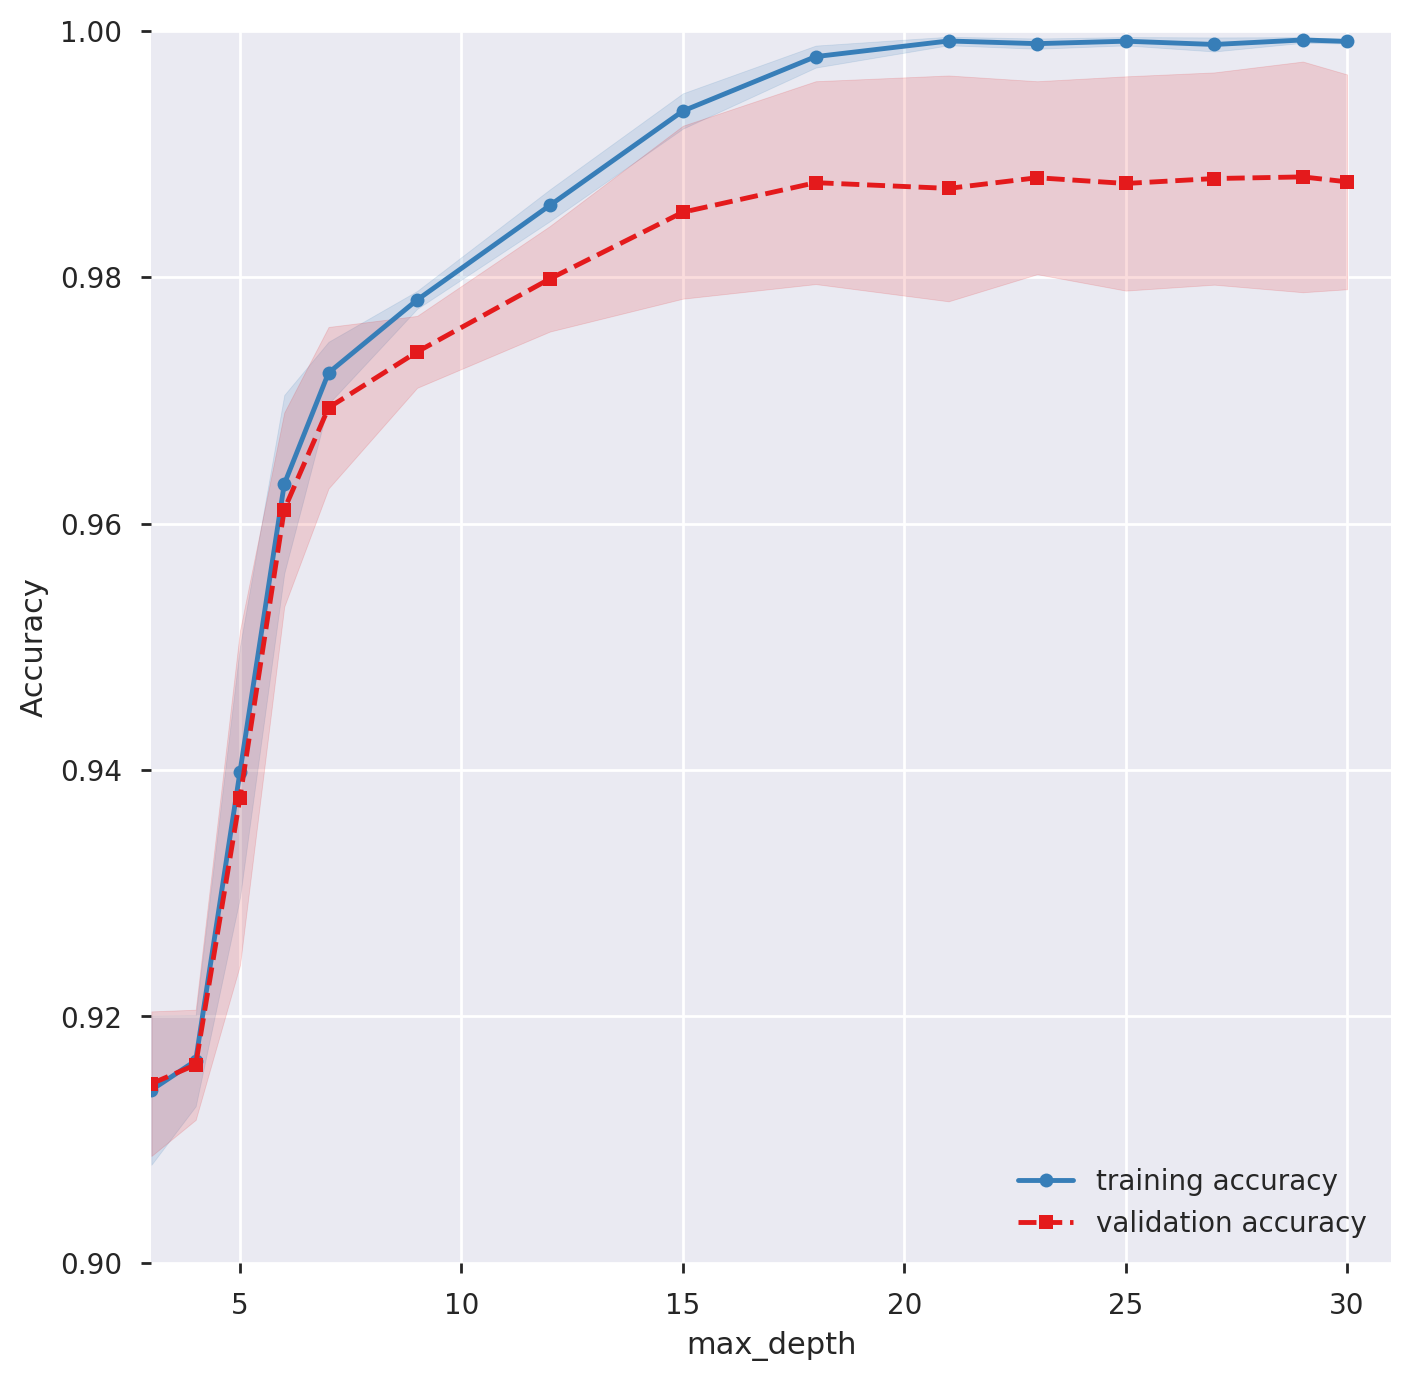

In [103]:
# Draw the validation curve

plot_validation_curve(train_scores, test_scores,
                      max_depths, xlabel='max_depth')
plt.xlim(3, 31)

#### Interpreting the validation curve
Starting on the left side of the plot, we see that both training & validation results <i>generally</i> align on the accuracy score, which is good. 

Taking max-depth to 6 or push up to 30, we can see a point/region where the error bars of these two accuracy lines no longer overlap. The optimal value for the max_depth parameter (<i>i.e.</i>, hyperparameter) can be found by looking for a high validation score with overlapping error bars on the two lines.

In [104]:
# Stratified k-fold cross validation
from sklearn.model_selection import cross_val_score

# Show k-fold results for the selected model:
# a random forest with max_depth = 6 or 9 and n_estimators = 200

np.random.seed(42)
clf = RandomForestClassifier(n_estimators=200, max_depth=6)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(scores.mean(axis=0), scores.std(axis=0)))

fold: 1 accuracy: [0.99825022 0.87709497]
fold: 2 accuracy: [0.99825022 0.81284916]
fold: 3 accuracy: [0.99300087 0.83473389]
fold: 4 accuracy: [0.99300087 0.85434174]
fold: 5 accuracy: [0.99562555 0.80672269]
fold: 6 accuracy: [0.99387577 0.87955182]
fold: 7 accuracy: [0.99650044 0.88235294]
fold: 8 accuracy: [0.99650044 0.86554622]
fold: 9 accuracy: [0.99562172 0.8767507 ]
fold: 10 accuracy: [0.99737303 0.86834734]
accuracy = [0.99579991 0.85582915] +/- [0.0018681  0.02667076]


Text(0, 0.5, 'Accuracy')

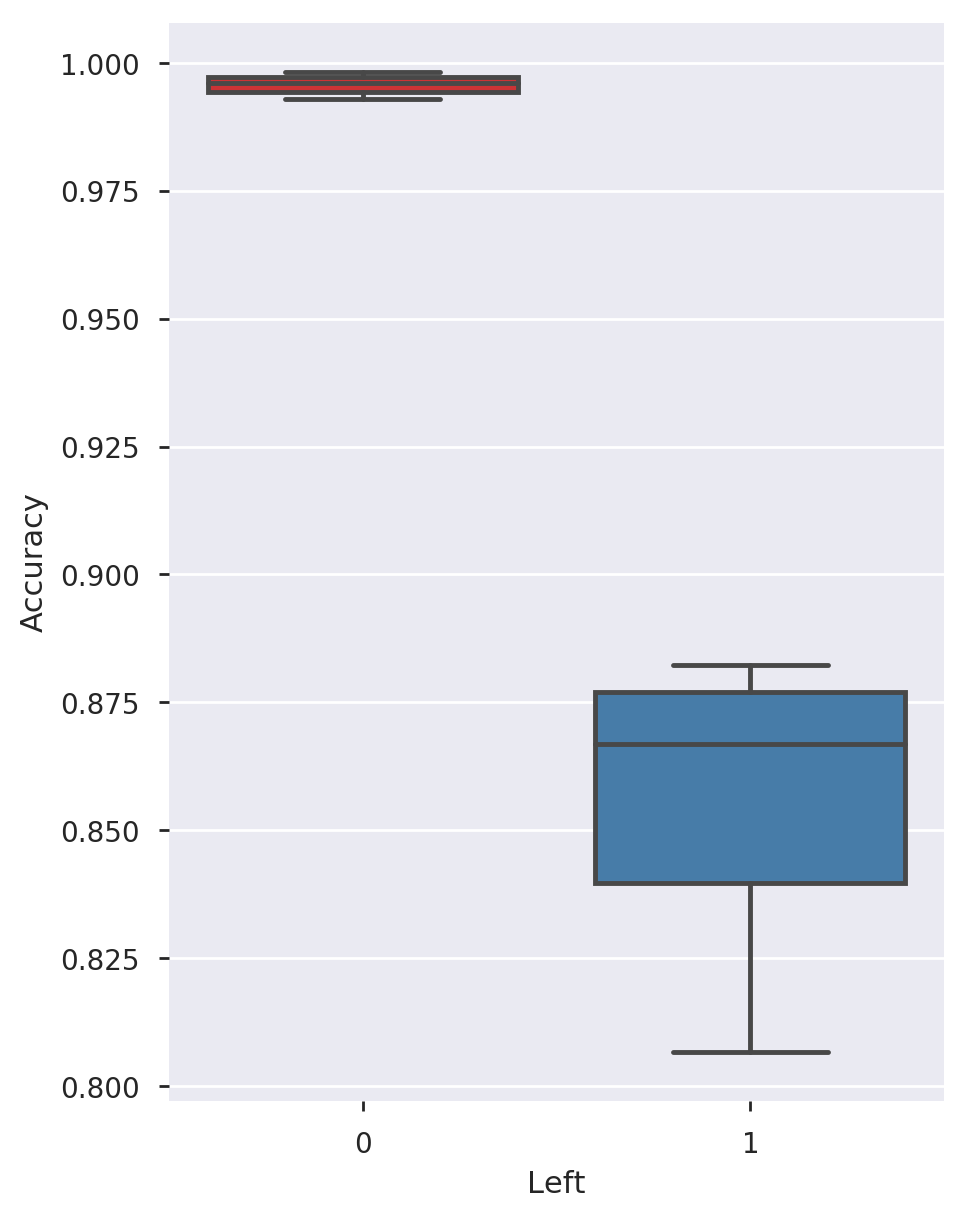

In [105]:
# Box plot of result

fig = plt.figure(figsize=(5, 7))
sns.boxplot(data=pd.DataFrame(scores, columns=[0, 1]),
            palette=sns.color_palette('Set1'))
plt.xlabel('Left')
plt.ylabel('Accuracy')

In [106]:
# Access feature importances

d = (clf.feature_importances_, hr.columns)
list(zip(*d))

[(0.32213488390328027, 'satisfaction_level'),
 (0.10514297294062544, 'last_evaluation'),
 (0.21758971752604384, 'number_project'),
 (0.14484688609093158, 'average_monthly_hours'),
 (0.18033879397612965, 'time_spend_company'),
 (0.012458004435125833, 'work_accident'),
 (0.000681103008816004, 'quit'),
 (0.00019756813726411155, 'promotion_last_5years'),
 (0.0007645055085948864, 'department_IT'),
 (0.00021575372154869924, 'department_RandD'),
 (0.0003843792192358308, 'department_accounting'),
 (0.00024918997323697504, 'department_hr'),
 (0.0001014412114071043, 'department_management'),
 (0.00019133432687861633, 'department_marketing'),
 (0.0003795071536771426, 'department_product_mng'),
 (0.00038027280043460084, 'department_sales'),
 (0.0004360567821841482, 'department_support'),
 (0.0051598585693346695, 'department_technical'),
 (0.00596492197105455, 'salary_high'),
 (0.0023828487441961647, 'salary_low')]

Text(0.5, 0, 'Feature importance')

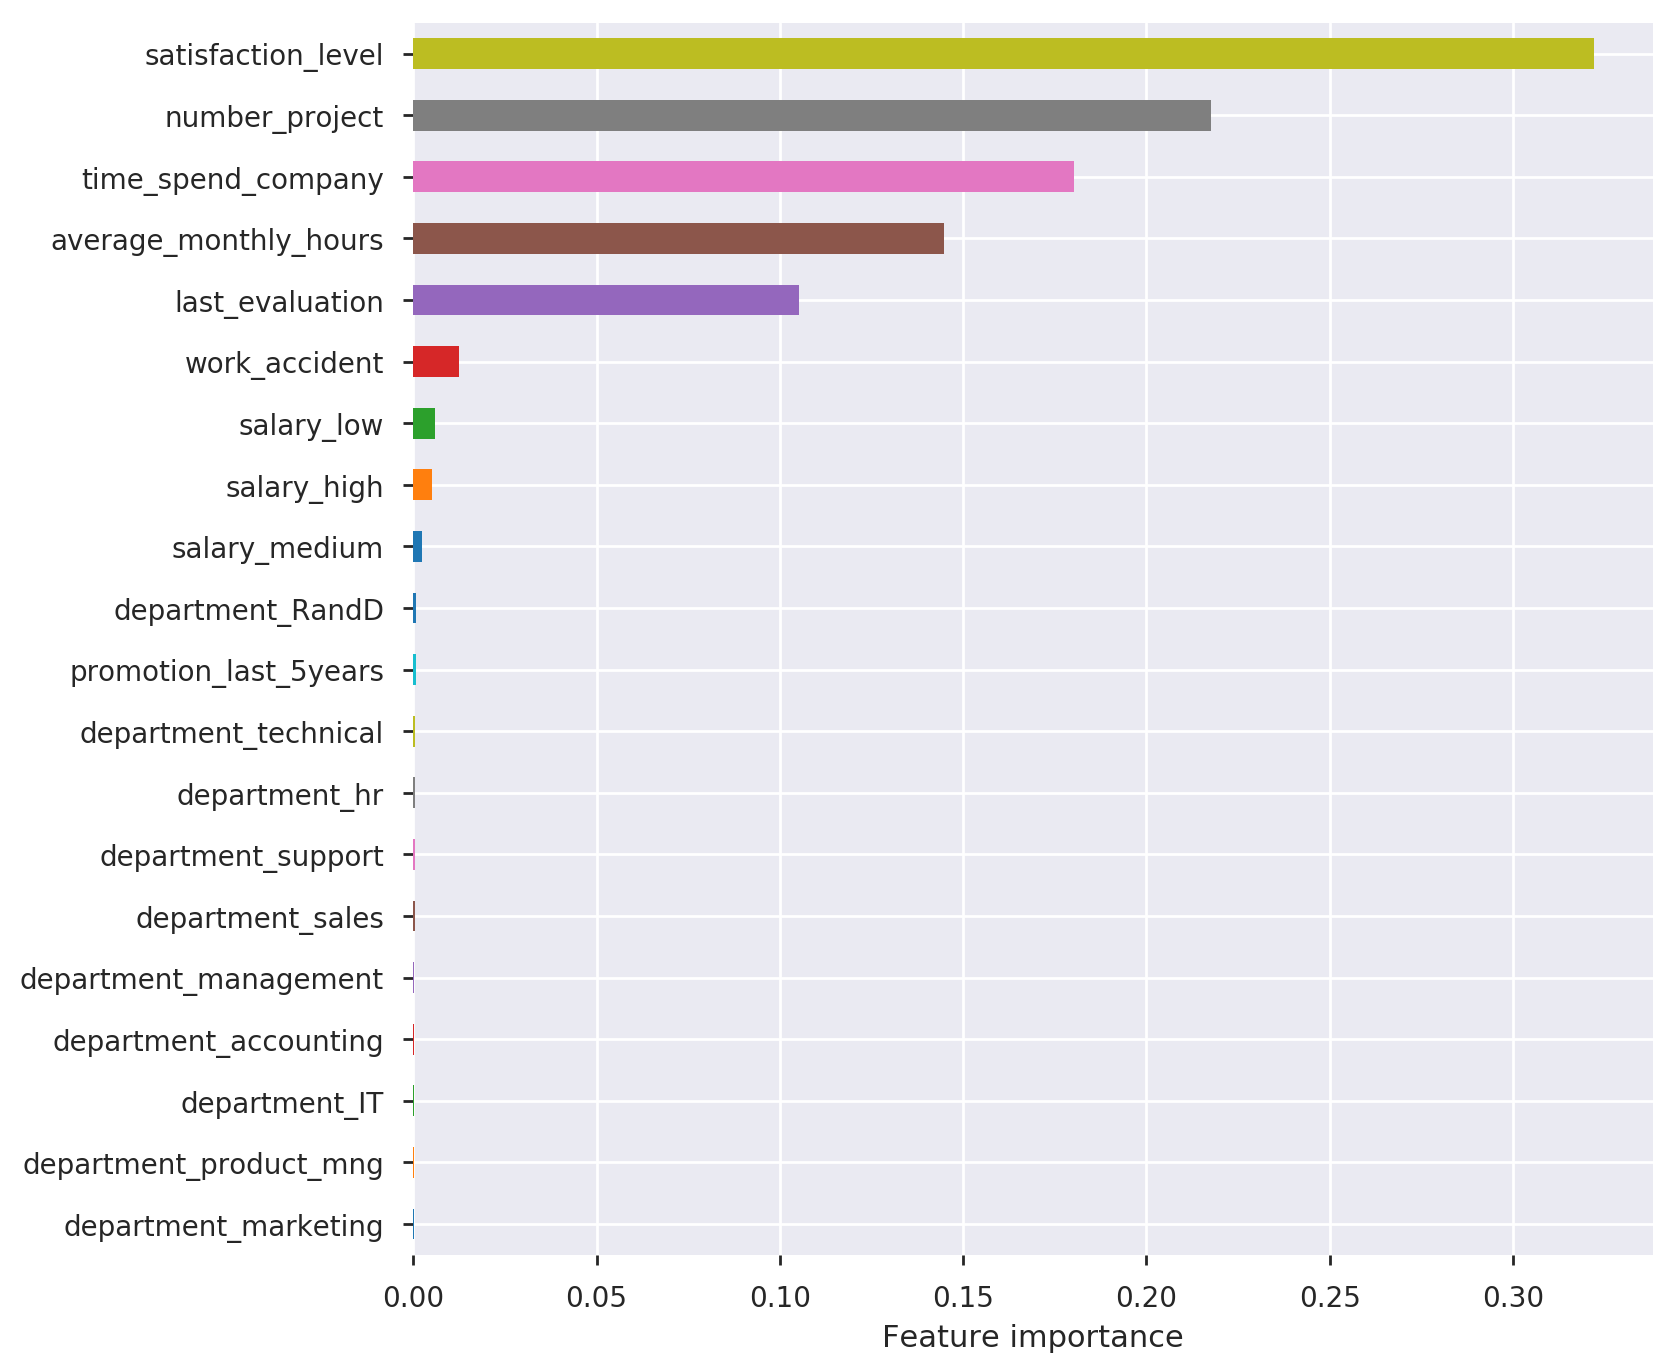

In [107]:
# Visualize the feature importances

pd.Series(clf.feature_importances_, name='Feature importance',
            index=hr[features].columns)\
    .sort_values()\
    .plot.barh()
plt.xlabel('Feature importance')

## Dimensionality Reduction techniques

Dimensionality reduction can simply involve removing unimportant features from the training data, but more exotic methods exist, such as Principal Component Analysis (PCA). 

This technique transforms the data by projecting it into a new subspace of orthogonal "principal components," where the components with the highest eigenvalues encode the most information for training the model. Then, we can simply select a few of these principal components in place of the original high-dimensional dataset.

Our purpose here is to use PCA to improve our Random Forest.

In [108]:
# Print all the features with low importance

importances = list(pd.Series(clf.feature_importances_, index=hr[features].columns)\
        .sort_values(ascending=False).index)

np.array(importances[5:])

array(['work_accident', 'salary_low', 'salary_high', 'salary_medium',
       'department_RandD', 'promotion_last_5years',
       'department_technical', 'department_hr', 'department_support',
       'department_sales', 'department_management',
       'department_accounting', 'department_IT', 'department_product_mng',
       'department_marketing'], dtype='<U22')

In [109]:
# Reduce the one-hot-encoded features with PCA

from sklearn.decomposition import PCA

pca_features = ['work_accident', 'salary_low', 'salary_high', 'salary_medium',
       'promotion_last_5years', 'department_RandD', 'department_hr',
       'department_technical', 'department_support',
       'department_management', 'department_sales',
       'department_accounting', 'department_IT', 'department_product_mng',
       'department_marketing']

X_reduce = hr[pca_features]

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_reduce)

In [110]:
X_pca

array([[-0.67733999,  0.75839278, -0.10494344],
       [ 0.73615606,  0.77158969, -0.11047796],
       [ 0.73615606,  0.77158969, -0.11047796],
       ...,
       [-0.67157626, -0.33372944,  0.70970475],
       [-0.67157626, -0.33372944,  0.70970475],
       [ 0.07052404, -0.18786538,  0.09591488]])

In [111]:
# Add principal components to our `hr` dataframe

hr['first_principle_component'] = X_pca.T[0]
hr['second_principle_component'] = X_pca.T[1]
hr['third_principle_component'] = X_pca.T[2]

In [114]:
# Select reduced-dimension feature set

features = ['satisfaction_level', 'number_project', 'time_spend_company',
            'average_monthly_hours', 'last_evaluation',
            'first_principle_component',
            'second_principle_component',
            'third_principle_component']

X = hr[features].values
y = hr.quit.values

In [115]:
# Show k-fold results for the selected model with reduced dimensionality:
# a random forest with max_depth = 6 or 9, and n_estimators = 200

np.random.seed(42)
clf = RandomForestClassifier(n_estimators=200, max_depth=6)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(scores.mean(axis=0), scores.std(axis=0)))

fold: 1 accuracy: [0.99825022 0.91620112]
fold: 2 accuracy: [0.99825022 0.88547486]
fold: 3 accuracy: [0.99650044 0.89635854]
fold: 4 accuracy: [0.99300087 0.91596639]
fold: 5 accuracy: [0.99387577 0.88795518]
fold: 6 accuracy: [0.99475066 0.90756303]
fold: 7 accuracy: [0.99737533 0.92436975]
fold: 8 accuracy: [0.99475066 0.89635854]
fold: 9 accuracy: [0.99562172 0.91596639]
fold: 10 accuracy: [0.99474606 0.91036415]
accuracy = [0.99571219 0.90565779] +/- [0.00172583 0.01262259]


Text(0, 0.5, 'Accuracy')

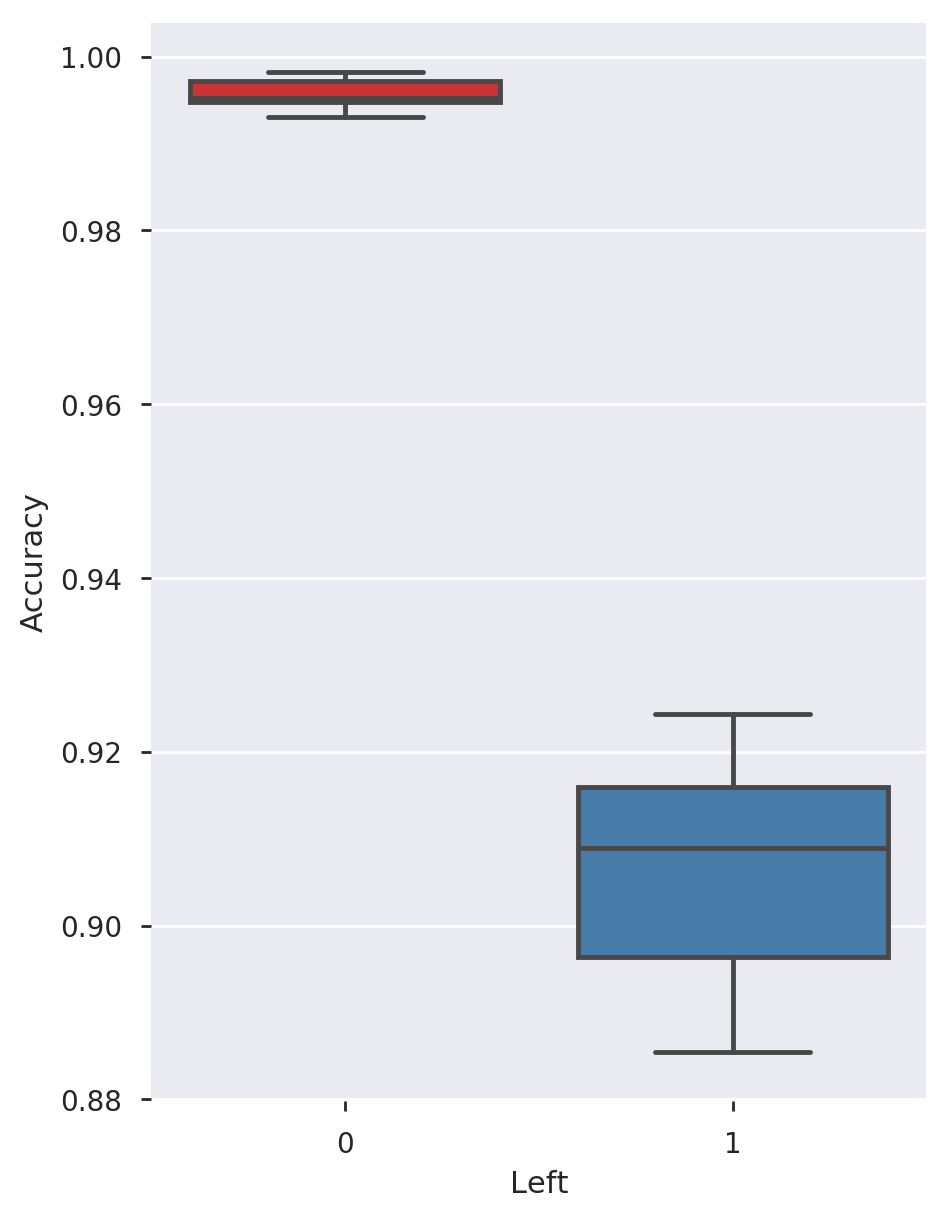

In [116]:
# Box plot of result

fig = plt.figure(figsize=(5, 7))
sns.boxplot(data=pd.DataFrame(scores, columns=[0, 1]),
            palette=sns.color_palette('Set1'))
plt.xlabel('Left')
plt.ylabel('Accuracy')

Comparing this to the previous boxplot before dimensionality reduction, we find an improvement in the class 1 accuracy! Now, the majority of the validation sets return an accuracy greater than 90%. The average accuracy of 90.6% can be compared to the accuracy of 85.6% prior to dimensionality reduction!

---

## Operationalizing this model

Train the final model on all the samples

In [117]:
operational_model = RandomForestClassifier(n_estimators=200, max_depth=6)
operational_model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Save this model offline

In [118]:
from sklearn.externals import joblib
joblib.dump(operational_model, 'random-forest-trained.pkl')

['random-forest-trained.pkl']

Confirm that this *.pkl file has been saved in the working directory

In [119]:
!ls *.pkl

random-forest-trained.pkl


Re-load the model from the *pkl file

In [120]:
working_model = joblib.load('random-forest-trained.pkl')
working_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Creating a whole new person with unseen feature values.  

In [128]:
StephenMiller = pd.Series([0.8,0.65,9,288,6,0,'no',0,'no','sales','low', 0.341423, -0.831704, -.787979],
                          ['satisfaction_level','last_evaluation','number_project','average_monthly_hours',
                           'time_spend_company','work_accident','left','promotion_last_5years',
                           'is_smoker','department','salary', 'first_principle_component', 
                           'second_principle_component', 'third_principle_component'])

In [122]:
type(StephenMiller)

pandas.core.series.Series

In [130]:
StephenMiller[features]

satisfaction_level                 0.8
number_project                       9
time_spend_company                   6
average_monthly_hours              288
last_evaluation                   0.65
first_principle_component     0.341423
second_principle_component   -0.831704
third_principle_component    -0.787979
dtype: object

In [131]:
featuresStephenMiller = StephenMiller[features]

In [132]:
working_model.predict_proba([featuresStephenMiller])

array([[0.46183155, 0.53816845]])

In [144]:
StephenMiller_intervene = pd.Series([0.8,0.9,5,160,6,0,'no',0,'no','sales','low', 0.341423, -0.831704, -.787979],
                          ['satisfaction_level','last_evaluation','number_project','average_monthly_hours',
                           'time_spend_company','work_accident','left','promotion_last_5years',
                           'is_smoker','department','salary', 'first_principle_component', 
                           'second_principle_component', 'third_principle_component'])

In [145]:
featuresStephenMiller_intervene = StephenMiller_intervene[features]

In [146]:
working_model.predict_proba([featuresStephenMiller_intervene])

array([[0.72410665, 0.27589335]])

The left 0,1 corresponding value has Stephen leaving with a probability of ~69%. <i>Recall that these [features] are the dimensionality reduced.</i> 

#### What if we let Stephen work fewer hours, take on fewer projects, and give him a better performance score?

In [93]:
featuresStephenMiller.average_montly_hours = 180
featuresStephenMiller.number_project = 2
featuresStephenMiller.last_evaluation = 0.9
working_model.predict_proba([featuresStephenMiller])

array([[0.80933184, 0.19066816]])

Stephen's attrition probability goes down significantly to 22%, down from 69%! 

---
## Advanced ML using H2O

In [147]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

h2o.init(min_mem_size = "15g")

# from h2o.estimators.deepwater import H2ODeepWaterEstimator 
## Cannot build a Deep Water model - no backend found.
#if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/mashrukzahid/miniconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/3p/g_f3ln4j6x13kklzvp9y76h80000gn/T/tmp1_027dv2
  JVM stdout: /var/folders/3p/g_f3ln4j6x13kklzvp9y76h80000gn/T/tmp1_027dv2/h2o_mashrukzahid_started_from_python.out
  JVM stderr: /var/folders/3p/g_f3ln4j6x13kklzvp9y76h80000gn/T/tmp1_027dv2/h2o_mashrukzahid_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.3
H2O cluster version age:,1 month and 24 days
H2O cluster name:,H2O_from_python_mashrukzahid_lcusxf
H2O cluster total nodes:,1
H2O cluster free memory:,14.38 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [148]:
# hr_hx = h2o.H2OFrame(hr)
hr_data = "hr_data.csv"
hr_hx = h2o.import_file(path = hr_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [149]:
hr_hx.describe()

Rows:15000
Cols:11




,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,is_smoker,department,salary
type,real,real,int,int,int,int,enum,int,enum,enum,enum
mins,0.09,0.36,2.0,96.0,2.0,0.0,,0.0,,,
mean,0.6128526666666667,0.7161040000000001,3.8032,200.96022416621105,3.4941746918984444,0.1446,,0.021266666666666666,,,
maxs,1.0,1.0,7.0,310.0,10.0,1.0,,1.0,,,
sigma,0.2486334186401335,0.17116362829130294,1.2326817892815007,50.00109823854684,1.4589328483370916,0.35170880939460947,,0.14427675930114497,,,
zeros,0,0,0,0,0,12831,,14681,,,
missing,0,0,0,368,151,0,0,0,14764,0,0
0,0.38,0.53,2.0,157.0,3.0,0.0,yes,0.0,,sales,low
1,0.8,0.86,5.0,262.0,6.0,0.0,yes,0.0,yes,sales,medium
2,0.11,0.88,7.0,272.0,4.0,0.0,yes,0.0,,sales,medium


In [151]:
for i in ['quit', 'is_smoker', 'department', 'salary']:
    hr_hx[i] = hr_hx[i].asfactor()

In [152]:
# no need to convert select features to Categorical in H2O because it imports correctly
hr_hx.types

{'satisfaction_level': 'real',
 'last_evaluation': 'real',
 'number_project': 'int',
 'average_monthly_hours': 'int',
 'time_spend_company': 'int',
 'work_accident': 'int',
 'quit': 'enum',
 'promotion_last_5years': 'int',
 'is_smoker': 'enum',
 'department': 'enum',
 'salary': 'enum'}

In [153]:
hr_hx.summary()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,is_smoker,department,salary
type,real,real,int,int,int,int,enum,int,enum,enum,enum
mins,0.09,0.36,2.0,96.0,2.0,0.0,,0.0,,,
mean,0.6128526666666667,0.7161040000000001,3.8032,200.96022416621105,3.4941746918984444,0.1446,,0.021266666666666666,,,
maxs,1.0,1.0,7.0,310.0,10.0,1.0,,1.0,,,
sigma,0.2486334186401335,0.17116362829130294,1.2326817892815007,50.00109823854684,1.4589328483370916,0.35170880939460947,,0.14427675930114497,,,
zeros,0,0,0,0,0,12831,,14681,,,
missing,0,0,0,368,151,0,0,0,14764,0,0
0,0.38,0.53,2.0,157.0,3.0,0.0,yes,0.0,,sales,low
1,0.8,0.86,5.0,262.0,6.0,0.0,yes,0.0,yes,sales,medium
2,0.11,0.88,7.0,272.0,4.0,0.0,yes,0.0,,sales,medium


In [154]:
predictors = list(set(hr_hx.names))
predictors.remove('is_smoker')

predictors.remove('quit')
response = "quit"

predictors

['work_accident',
 'satisfaction_level',
 'promotion_last_5years',
 'department',
 'average_monthly_hours',
 'salary',
 'time_spend_company',
 'number_project',
 'last_evaluation']

In [155]:
r = hr_hx.runif(seed = 42)
train = hr_hx[r  < 0.8]                 ## 80% for training
valid = hr_hx[(r >= 0.8) & (r < 0.9)]   ## 10% for early stopping (only enabled by default for Deep Water)
test  = hr_hx[r  >= 0.9]                ## 10% for final testing
print(train.dim)
print(valid.dim)
print(test.dim)

[12042, 11]
[1457, 11]
[1501, 11]


In [156]:
from h2o.automl import H2OAutoML

In [157]:
aml = H2OAutoML(max_models = 18, seed = 42, max_runtime_secs = 400)
aml.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

aml.leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_3_AutoML_20190215_093645,0.993018,0.054577,0.0217234,0.107316,0.0115168
GBM_2_AutoML_20190215_093645,0.993007,0.0553254,0.0232603,0.108765,0.0118298
GBM_1_AutoML_20190215_093645,0.992807,0.0569381,0.022628,0.111894,0.0125202
GBM_grid_1_AutoML_20190215_093645_model_2,0.992619,0.0536327,0.0207642,0.105185,0.011064
GBM_4_AutoML_20190215_093645,0.992279,0.0562172,0.0214182,0.106032,0.0112427
XGBoost_1_AutoML_20190215_093645,0.992273,0.0686146,0.0305957,0.128454,0.0165006
XGBoost_grid_1_AutoML_20190215_093645_model_2,0.992212,0.0551068,0.0210585,0.106414,0.0113239
StackedEnsemble_AllModels_AutoML_20190215_093645,0.992151,0.0533555,0.0210803,0.1035,0.0107122
StackedEnsemble_BestOfFamily_AutoML_20190215_093645,0.991964,0.0533958,0.0201756,0.103379,0.0106873
GBM_5_AutoML_20190215_093645,0.991402,0.0685192,0.0321108,0.12735,0.0162181


In [158]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20190215_093645


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0016119995747767297
RMSE: 0.040149714504299154
LogLoss: 0.010887815638799064
Mean Per-Class Error: 0.001079064692750098
AUC: 0.9999884621489106
pr_auc: 0.9612466225707321
Gini: 0.9999769242978211
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3517516460090741: 


,no,yes,Error,Rate
no,9168.0,7.0,0.0008,(7.0/9175.0)
yes,4.0,2863.0,0.0014,(4.0/2867.0)
Total,9172.0,2870.0,0.0009,(11.0/12042.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3517516,0.9980826,198.0
max f2,0.3517516,0.9983959,198.0
max f0point5,0.4854280,0.9983216,187.0
max accuracy,0.4065768,0.9990865,196.0
max precision,0.9997044,1.0,0.0
max recall,0.1106628,1.0,231.0
max specificity,0.9997044,1.0,0.0
max absolute_mcc,0.3517516,0.9974833,198.0
max min_per_class_accuracy,0.3517516,0.9986048,198.0
max mean_per_class_accuracy,0.3517516,0.9989209,198.0


Gains/Lift Table: Avg response rate: 23.81 %, avg score: 23.79 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100482,0.9995652,4.2002093,4.2002093,1.0,0.9996938,1.0,0.9996938,0.0422044,0.0422044,320.0209278,320.0209278
,2,0.0201794,0.9993986,4.2002093,4.2002093,1.0,0.9994758,1.0,0.9995844,0.0425532,0.0847576,320.0209278,320.0209278
,3,0.0300615,0.9991165,4.2002093,4.2002093,1.0,0.9992561,1.0,0.9994764,0.0415068,0.1262644,320.0209278,320.0209278
,4,0.0400266,0.9989223,4.2002093,4.2002093,1.0,0.9990319,1.0,0.9993658,0.0418556,0.1681200,320.0209278,320.0209278
,5,0.0500747,0.9986628,4.2002093,4.2002093,1.0,0.9987836,1.0,0.9992489,0.0422044,0.2103244,320.0209278,320.0209278
,6,0.1000664,0.9977025,4.2002093,4.2002093,1.0,0.9982145,1.0,0.9987322,0.2099756,0.4203000,320.0209278,320.0209278
,7,0.1500581,0.9959895,4.2002093,4.2002093,1.0,0.9970015,1.0,0.9981556,0.2099756,0.6302755,320.0209278,320.0209278
,8,0.2002159,0.9842162,4.2002093,4.2002093,1.0,0.9921777,1.0,0.9966580,0.2106732,0.8409487,320.0209278,320.0209278
,9,0.3000332,0.0148276,1.5934238,3.3329643,0.3793677,0.3660335,0.7935234,0.7868571,0.1590513,1.0,59.3423819,233.2964296
,10,0.4000166,0.0054367,0.0,2.4998962,0.0,0.0088442,0.5951837,0.5923943,0.0,1.0,-100.0,149.9896201




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.009277359452118874
RMSE: 0.096319050307397
LogLoss: 0.044906381768083925
Mean Per-Class Error: 0.01598506978253811
AUC: 0.9950103810863304
pr_auc: 0.9824270503482471
Gini: 0.9900207621726609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4503698563335232: 


,no,yes,Error,Rate
no,1102.0,4.0,0.0036,(4.0/1106.0)
yes,10.0,341.0,0.0285,(10.0/351.0)
Total,1112.0,345.0,0.0096,(14.0/1457.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4503699,0.9798851,136.0
max f2,0.3450387,0.9754706,140.0
max f0point5,0.7840823,0.9894304,129.0
max accuracy,0.6260443,0.9903912,134.0
max precision,0.9998498,1.0,0.0
max recall,0.0022966,1.0,343.0
max specificity,0.9998498,1.0,0.0
max absolute_mcc,0.4503699,0.9736361,136.0
max min_per_class_accuracy,0.3450387,0.9743590,140.0
max mean_per_class_accuracy,0.3450387,0.9840149,140.0


Gains/Lift Table: Avg response rate: 24.09 %, avg score: 23.98 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102951,0.9994809,4.1509972,4.1509972,1.0,0.9996779,1.0,0.9996779,0.0427350,0.0427350,315.0997151,315.0997151
,2,0.0205903,0.9993748,4.1509972,4.1509972,1.0,0.9994280,1.0,0.9995529,0.0427350,0.0854701,315.0997151,315.0997151
,3,0.0301990,0.9991489,4.1509972,4.1509972,1.0,0.9992960,1.0,0.9994712,0.0398860,0.1253561,315.0997151,315.0997151
,4,0.0404942,0.9988815,4.1509972,4.1509972,1.0,0.9990262,1.0,0.9993580,0.0427350,0.1680912,315.0997151,315.0997151
,5,0.0501030,0.9986423,4.1509972,4.1509972,1.0,0.9987688,1.0,0.9992450,0.0398860,0.2079772,315.0997151,315.0997151
,6,0.1002059,0.9979055,4.1509972,4.1509972,1.0,0.9982276,1.0,0.9987363,0.2079772,0.4159544,315.0997151,315.0997151
,7,0.1503089,0.9962632,4.1509972,4.1509972,1.0,0.9971573,1.0,0.9982100,0.2079772,0.6239316,315.0997151,315.0997151
,8,0.2004118,0.9867961,4.1509972,4.1509972,1.0,0.9934024,1.0,0.9970081,0.2079772,0.8319088,315.0997151,315.0997151
,9,0.2999314,0.0189701,1.5172610,3.2771030,0.3655172,0.3797138,0.7894737,0.7921850,0.1509972,0.9829060,51.7261028,227.7103014
,10,0.4001373,0.0064976,0.0568630,2.4706621,0.0136986,0.0113306,0.5951973,0.5966366,0.0056980,0.9886040,-94.3137025,147.0662112




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.011516795905161088
RMSE: 0.10731633568642329
LogLoss: 0.05457704163372309
Mean Per-Class Error: 0.020938481584582225
AUC: 0.9930181934994567
pr_auc: 0.952236361018537
Gini: 0.9860363869989135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5423369054393019: 


,no,yes,Error,Rate
no,9138.0,37.0,0.004,(37.0/9175.0)
yes,113.0,2754.0,0.0394,(113.0/2867.0)
Total,9251.0,2791.0,0.0125,(150.0/12042.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5423369,0.9734889,166.0
max f2,0.2165611,0.9676294,219.0
max f0point5,0.6490177,0.9834183,149.0
max accuracy,0.6161668,0.9875436,153.0
max precision,0.9998680,1.0,0.0
max recall,0.0002522,1.0,397.0
max specificity,0.9998680,1.0,0.0
max absolute_mcc,0.6161668,0.9655018,153.0
max min_per_class_accuracy,0.0720602,0.9732970,278.0
max mean_per_class_accuracy,0.3311932,0.9790615,192.0


Gains/Lift Table: Avg response rate: 23.81 %, avg score: 23.51 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100482,0.9997873,4.2002093,4.2002093,1.0,0.9998675,1.0,0.9998675,0.0422044,0.0422044,320.0209278,320.0209278
,2,0.0200133,0.9995310,4.2002093,4.2002093,1.0,0.9996844,1.0,0.9997764,0.0418556,0.0840600,320.0209278,320.0209278
,3,0.0300615,0.9992297,4.2002093,4.2002093,1.0,0.9993794,1.0,0.9996437,0.0422044,0.1262644,320.0209278,320.0209278
,4,0.0400266,0.9989722,4.2002093,4.2002093,1.0,0.9990966,1.0,0.9995075,0.0418556,0.1681200,320.0209278,320.0209278
,5,0.0500747,0.9987542,4.2002093,4.2002093,1.0,0.9988724,1.0,0.9993800,0.0422044,0.2103244,320.0209278,320.0209278
,6,0.1000664,0.9972906,4.2002093,4.2002093,1.0,0.9980780,1.0,0.9987295,0.2099756,0.4203000,320.0209278,320.0209278
,7,0.1500581,0.9947029,4.2002093,4.2002093,1.0,0.9960679,1.0,0.9978428,0.2099756,0.6302755,320.0209278,320.0209278
,8,0.2000498,0.9811147,4.1374155,4.1845173,0.9850498,0.9906161,0.9962640,0.9960369,0.2068364,0.8371120,313.7415452,318.4517338
,9,0.3000332,0.0196133,1.4337924,3.2678628,0.3413621,0.3374828,0.7780238,0.7765796,0.1433554,0.9804674,43.3792370,226.7862796
,10,0.4000166,0.0062719,0.0941907,2.4746095,0.0224252,0.0108704,0.5891634,0.5851921,0.0094175,0.9898849,-90.5809260,147.4609494



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9879583,0.0024009,0.9900374,0.9916978,0.9896179,0.9821429,0.9862957
auc,0.9929493,0.0017270,0.9953128,0.993798,0.9952214,0.9889191,0.9914951
err,0.0120417,0.0024009,0.0099626,0.0083022,0.0103821,0.0178571,0.0137043
err_count,29.0,5.7792735,24.0,20.0,25.0,43.0,33.0
f0point5,0.9821612,0.0034685,0.9861407,0.9876325,0.9806678,0.9736747,0.9826902
f1,0.9743350,0.0052254,0.978836,0.9824253,0.9780894,0.9617097,0.9706144
f2,0.9666606,0.0074408,0.9716387,0.9772728,0.9755245,0.9500352,0.9588318
lift_top_group,4.2002115,0.0019327,4.196864,4.196864,4.202443,4.202443,4.202443
logloss,0.0545786,0.0094018,0.0468435,0.0429224,0.042323,0.0747189,0.0660855
max_per_class_error,0.0383737,0.0089766,0.0331010,0.0261324,0.0261780,0.0575916,0.0488656


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-02-15 09:39:10,5.280 sec,0.0,0.4259104,0.5488606,0.5,0.0,1.0,0.7619166,0.4276427,0.5521439,0.5,0.0,1.0,0.7590940
,2019-02-15 09:39:10,5.307 sec,5.0,0.2776127,0.2940191,0.9924504,0.9675761,4.2002093,0.0203455,0.2768483,0.2941667,0.9879304,0.9696954,4.1509972,0.0157859
,2019-02-15 09:39:10,5.344 sec,10.0,0.2003587,0.1919348,0.9938775,0.9858787,4.2002093,0.0184355,0.2007202,0.1948516,0.9893884,0.9798795,4.1509972,0.0178449
,2019-02-15 09:39:10,5.380 sec,15.0,0.1554246,0.1333053,0.9950365,0.9900881,4.2002093,0.0146155,0.1573943,0.1379612,0.9912482,0.9820190,4.1509972,0.0157859
,2019-02-15 09:39:10,5.416 sec,20.0,0.1317476,0.0993917,0.9954340,0.9905327,4.2002093,0.0124564,0.1367263,0.1064530,0.9917132,0.9769012,4.1509972,0.0157859
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-02-15 09:39:11,6.030 sec,100.0,0.0544267,0.0168023,0.9999291,0.9669950,4.2002093,0.0023252,0.0990887,0.0466500,0.9949576,0.9819689,4.1509972,0.0096088
,2019-02-15 09:39:11,6.069 sec,105.0,0.0508562,0.0152311,0.9999454,0.9813446,4.2002093,0.0019100,0.0980302,0.0461012,0.9949692,0.9877116,4.1509972,0.0096088
,2019-02-15 09:39:11,6.108 sec,110.0,0.0475227,0.0138415,0.9999546,0.9778860,4.2002093,0.0018269,0.0971011,0.0459010,0.9945879,0.9817933,4.1509972,0.0096088
,2019-02-15 09:39:11,6.149 sec,115.0,0.0436889,0.0121902,0.9999751,0.9615529,4.2002093,0.0014117,0.0963154,0.0452661,0.9946961,0.9820315,4.1509972,0.0096088



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
satisfaction_level,4454.2622070,1.0,0.4798668
time_spend_company,1604.8126221,0.3602870,0.1728898
last_evaluation,1169.6109619,0.2625824,0.1260046
number_project,1112.5687256,0.2497762,0.1198593
average_monthly_hours,714.3449707,0.1603734,0.0769579
department,138.4526672,0.0310832,0.0149158
salary,63.7903442,0.0143212,0.0068723
work_accident,19.2974682,0.0043324,0.0020790
promotion_last_5years,5.1480379,0.0011558,0.0005546


In [159]:
# Evaluate performance on a test set
perf = aml.leader.model_performance(test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.012307090433723545
RMSE: 0.11093732660256216
LogLoss: 0.05820851266012031
Mean Per-Class Error: 0.019895921071426792
AUC: 0.9932284663011837
pr_auc: 0.983482564493534
Gini: 0.9864569326023673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5961971379676659: 


,no,yes,Error,Rate
no,1143.0,4.0,0.0035,(4.0/1147.0)
yes,15.0,339.0,0.0424,(15.0/354.0)
Total,1158.0,343.0,0.0127,(19.0/1501.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5961971,0.9727403,132.0
max f2,0.3517515,0.9694743,141.0
max f0point5,0.7438271,0.9830805,129.0
max accuracy,0.5961971,0.9873418,132.0
max precision,0.9998596,1.0,0.0
max recall,0.0021028,1.0,351.0
max specificity,0.9998596,1.0,0.0
max absolute_mcc,0.5961971,0.9647038,132.0
max min_per_class_accuracy,0.0778853,0.9717514,163.0
max mean_per_class_accuracy,0.3517515,0.9801041,141.0


Gains/Lift Table: Avg response rate: 23.58 %, avg score: 23.41 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0106596,0.9994854,4.2401130,4.2401130,1.0,0.9996196,1.0,0.9996196,0.0451977,0.0451977,324.0112994,324.0112994
,2,0.0206529,0.9992745,4.2401130,4.2401130,1.0,0.9994081,1.0,0.9995173,0.0423729,0.0875706,324.0112994,324.0112994
,3,0.0313125,0.9990052,4.2401130,4.2401130,1.0,0.9991483,1.0,0.9993917,0.0451977,0.1327684,324.0112994,324.0112994
,4,0.0406396,0.9988482,4.2401130,4.2401130,1.0,0.9989394,1.0,0.9992879,0.0395480,0.1723164,324.0112994,324.0112994
,5,0.0506329,0.9987330,4.2401130,4.2401130,1.0,0.9987904,1.0,0.9991897,0.0423729,0.2146893,324.0112994,324.0112994
,6,0.1005996,0.9977663,4.2401130,4.2401130,1.0,0.9982985,1.0,0.9987471,0.2118644,0.4265537,324.0112994,324.0112994
,7,0.1512325,0.9962331,4.1843220,4.2214341,0.9868421,0.9970573,0.9955947,0.9981813,0.2118644,0.6384181,318.4322034,322.1434082
,8,0.2005330,0.9771310,4.2401130,4.2260262,1.0,0.9910177,0.9966777,0.9964202,0.2090395,0.8474576,324.0112994,322.6026240
,9,0.3004664,0.0176362,1.2720339,3.2435454,0.3,0.3241672,0.7649667,0.7728327,0.1271186,0.9745763,27.2033898,224.3545417
,10,0.4003997,0.0057402,0.1696045,2.4763389,0.04,0.0097345,0.5840266,0.5823756,0.0169492,0.9915254,-83.0395480,147.6338870


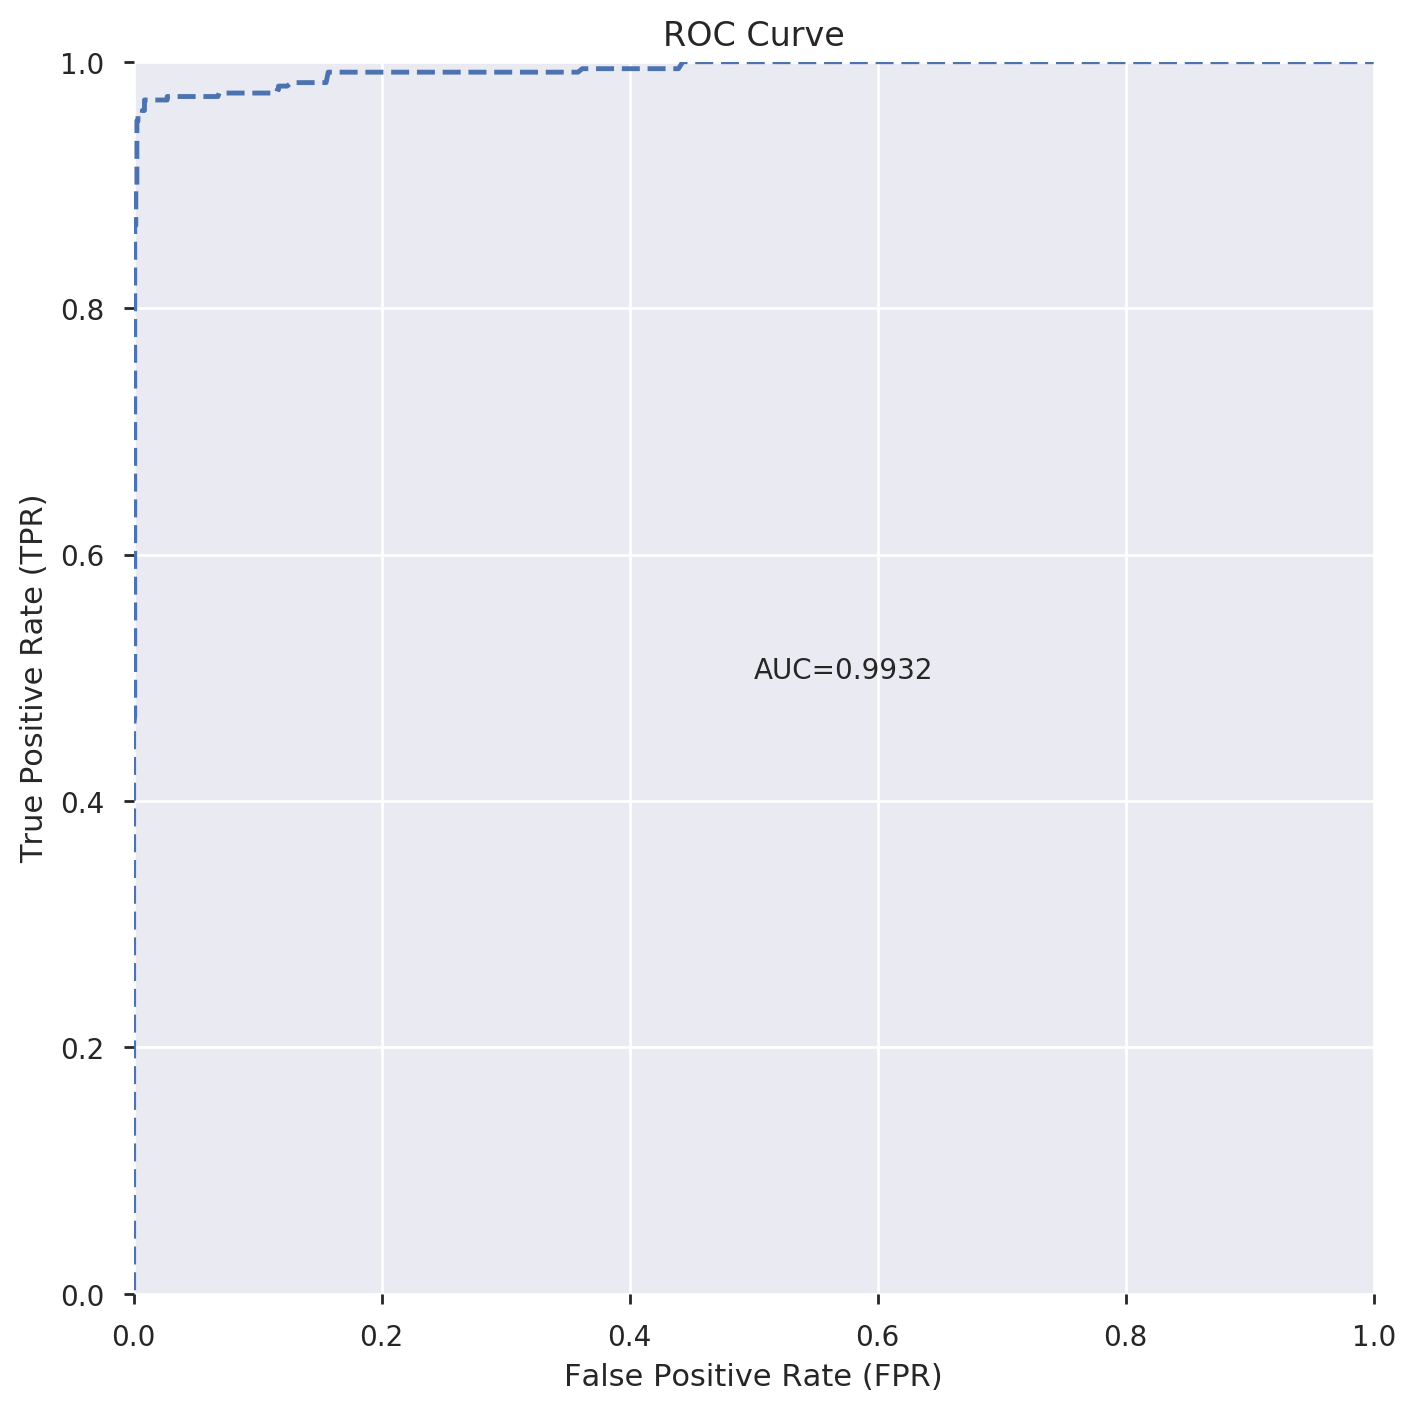

In [160]:
perf.plot()

### Let's compare H2O AutoML output using the pre-processed data (also run in RapidMiner)

In [163]:
# Use the earlier pre-processed data
hr_prep_hx = h2o.H2OFrame(hr)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [169]:
# important to remember to set the 'quit' variable as a categorical feature so H2O AutoML runs classification models
hr_prep_hx['quit'] = hr_prep_hx['quit'].asfactor()

In [170]:
predictors = list(set(hr_prep_hx.names))
predictors.remove('quit')
response = "quit"
predictors

['satisfaction_level',
 'promotion_last_5years',
 'department_support',
 'department_management',
 'time_spend_company',
 'number_project',
 'second_principle_component',
 'first_principle_component',
 'salary_high',
 'third_principle_component',
 'department_product_mng',
 'department_RandD',
 'department_sales',
 'department_IT',
 'salary_low',
 'department_hr',
 'average_monthly_hours',
 'department_technical',
 'last_evaluation',
 'work_accident',
 'department_accounting',
 'department_marketing',
 'salary_medium']

In [171]:
r = hr_prep_hx.runif(seed = 42)
train_prep = hr_prep_hx[r  < 0.8]                 ## 80% for training
valid_prep = hr_prep_hx[(r >= 0.8) & (r < 0.9)]   ## 10% for early stopping (only enabled by default for Deep Water)
test_prep  = hr_prep_hx[r  >= 0.9]                ## 10% for final testing
print(train_prep.dim)
print(valid_prep.dim)
print(test_prep.dim)

[12042, 24]
[1457, 24]
[1501, 24]


In [172]:
compareML = H2OAutoML(max_models = 18, seed = 42, max_runtime_secs = 400)
compareML.train(x = predictors, y = response, training_frame = hr_prep_hx)

compareML.leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190215_100037_model_2,0.99306,0.0543043,0.0211019,0.106156,0.011269
GBM_4_AutoML_20190215_100037,0.993016,0.0551281,0.0205071,0.105362,0.0111012
GBM_2_AutoML_20190215_100037,0.99286,0.0563073,0.0233417,0.109663,0.0120259
GBM_3_AutoML_20190215_100037,0.992822,0.0552835,0.0206734,0.107326,0.011519
GBM_1_AutoML_20190215_100037,0.992816,0.0570572,0.0223445,0.111107,0.0123447
GBM_5_AutoML_20190215_100037,0.992709,0.0650114,0.0338401,0.12512,0.0156551
XGBoost_1_AutoML_20190215_100037,0.992155,0.0714148,0.0358439,0.132881,0.0176575
StackedEnsemble_AllModels_AutoML_20190215_100037,0.991672,0.0552314,0.0211195,0.105161,0.0110588
StackedEnsemble_BestOfFamily_AutoML_20190215_100037,0.991623,0.0559714,0.0221605,0.106321,0.0113042
XGBoost_2_AutoML_20190215_100037,0.991372,0.0765949,0.040638,0.138205,0.0191007


In [173]:
compareML.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_20190215_100037_model_2


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0021176747024890087
RMSE: 0.046018199687612824
LogLoss: 0.013077090319884152
Mean Per-Class Error: 0.0011286888532556771
AUC: 0.9999764213434637
pr_auc: 0.9792055890847192
Gini: 0.9999528426869273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2487867468615756: 


,0,1,Error,Rate
0,11415.0,13.0,0.0011,(13.0/11428.0)
1,4.0,3568.0,0.0011,(4.0/3572.0)
Total,11419.0,3581.0,0.0011,(17.0/15000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2487867,0.9976234,203.0
max f2,0.2487867,0.9983771,203.0
max f0point5,0.5068131,0.9971847,178.0
max accuracy,0.2487867,0.9988667,203.0
max precision,0.9987270,1.0,0.0
max recall,0.1263304,1.0,226.0
max specificity,0.9987270,1.0,0.0
max absolute_mcc,0.2487867,0.9968807,203.0
max min_per_class_accuracy,0.2487867,0.9988624,203.0
max mean_per_class_accuracy,0.2487867,0.9988713,203.0


Gains/Lift Table: Avg response rate: 23.81 %, avg score: 23.81 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9985328,4.1993281,4.1993281,1.0,0.9986567,1.0,0.9986567,0.0419933,0.0419933,319.9328108,319.9328108
,2,0.02,0.9983901,4.1993281,4.1993281,1.0,0.9984632,1.0,0.9985599,0.0419933,0.0839866,319.9328108,319.9328108
,3,0.0300667,0.9982741,4.1993281,4.1993281,1.0,0.9983392,1.0,0.9984860,0.0422732,0.1262598,319.9328108,319.9328108
,4,0.0401333,0.9981321,4.1993281,4.1993281,1.0,0.9982016,1.0,0.9984147,0.0422732,0.1685330,319.9328108,319.9328108
,5,0.0500667,0.9978993,4.1993281,4.1993281,1.0,0.9980273,1.0,0.9983378,0.0417133,0.2102464,319.9328108,319.9328108
,6,0.1001333,0.9969429,4.1993281,4.1993281,1.0,0.9972840,1.0,0.9978109,0.2102464,0.4204927,319.9328108,319.9328108
,7,0.1501333,0.9957827,4.1993281,4.1993281,1.0,0.9965049,1.0,0.9973759,0.2099664,0.6304591,319.9328108,319.9328108
,8,0.2,0.9859009,4.1993281,4.1993281,1.0,0.9921547,1.0,0.9960741,0.2094065,0.8398656,319.9328108,319.9328108
,9,0.3,0.0156867,1.6013438,3.3333333,0.3813333,0.3610406,0.7937778,0.7843963,0.1601344,1.0,60.1343785,233.3333333
,10,0.4,0.0072390,0.0,2.5,0.0,0.0103397,0.5953333,0.5908821,0.0,1.0,-100.0,150.0




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.011269014596091318
RMSE: 0.10615561500029717
LogLoss: 0.054304310953230184
Mean Per-Class Error: 0.02064706398813776
AUC: 0.9930603910514675
pr_auc: 0.9745076369035337
Gini: 0.986120782102935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4443800660543168: 


,0,1,Error,Rate
0,11400.0,28.0,0.0025,(28.0/11428.0)
1,142.0,3430.0,0.0398,(142.0/3572.0)
Total,11542.0,3458.0,0.0113,(170.0/15000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4443801,0.9758179,168.0
max f2,0.3561246,0.9673515,182.0
max f0point5,0.5924860,0.9855936,151.0
max accuracy,0.4443801,0.9886667,168.0
max precision,0.9991078,1.0,0.0
max recall,0.0011959,1.0,393.0
max specificity,0.9991078,1.0,0.0
max absolute_mcc,0.4443801,0.9686367,168.0
max min_per_class_accuracy,0.0496014,0.9694849,281.0
max mean_per_class_accuracy,0.3561246,0.9793529,182.0


Gains/Lift Table: Avg response rate: 23.81 %, avg score: 23.30 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9988312,4.1993281,4.1993281,1.0,0.9989814,1.0,0.9989814,0.0419933,0.0419933,319.9328108,319.9328108
,2,0.02,0.9985893,4.1993281,4.1993281,1.0,0.9987092,1.0,0.9988453,0.0419933,0.0839866,319.9328108,319.9328108
,3,0.03,0.9984036,4.1993281,4.1993281,1.0,0.9984932,1.0,0.9987279,0.0419933,0.1259798,319.9328108,319.9328108
,4,0.04,0.9982647,4.1993281,4.1993281,1.0,0.9983348,1.0,0.9986297,0.0419933,0.1679731,319.9328108,319.9328108
,5,0.0500667,0.9981299,4.1993281,4.1993281,1.0,0.9981993,1.0,0.9985431,0.0422732,0.2102464,319.9328108,319.9328108
,6,0.1,0.9973934,4.1825084,4.1909295,0.9959947,0.9977562,0.998,0.9981502,0.2088466,0.4190929,318.2508369,319.0929451
,7,0.15,0.9958451,4.1993281,4.1937290,1.0,0.9967070,0.9986667,0.9976691,0.2099664,0.6290594,319.9328108,319.3729003
,8,0.2,0.9863278,4.1769317,4.1895297,0.9946667,0.9925696,0.9976667,0.9963942,0.2088466,0.8379059,317.6931691,318.9529675
,9,0.3,0.0165122,1.3997760,3.2596118,0.3333333,0.3114903,0.7762222,0.7680929,0.1399776,0.9778835,39.9776036,225.9611795
,10,0.4,0.0068930,0.1231803,2.4755039,0.0293333,0.0104636,0.5895,0.5786856,0.0123180,0.9902016,-87.6819709,147.5503919



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9888667,0.0010812,0.9893333,0.9866667,0.991,0.9876667,0.9896666
auc,0.9931024,0.0008302,0.9942795,0.9923842,0.9943976,0.9912832,0.9931675
err,0.0111333,0.0010812,0.0106667,0.0133333,0.009,0.0123333,0.0103333
err_count,33.4,3.243455,32.0,40.0,27.0,37.0,31.0
f0point5,0.9850883,0.0015306,0.9873345,0.9824258,0.9863753,0.9825014,0.9868044
f1,0.9762667,0.0023424,0.9772080,0.97151,0.9809457,0.9737029,0.9779673
f2,0.9676089,0.0034464,0.9672871,0.960834,0.9755755,0.9650606,0.9692871
lift_top_group,4.19933,0.0020357,4.2016807,4.195804,4.195804,4.2016807,4.2016807
logloss,0.0543043,0.0036044,0.0531904,0.0623507,0.0472566,0.0570314,0.0516924
max_per_class_error,0.0380745,0.0042173,0.0392157,0.0461538,0.0279720,0.0406162,0.0364146


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-02-15 10:06:08,16.062 sec,0.0,0.4259411,0.5489187,0.5,0.0,1.0,0.7618667
,2019-02-15 10:06:08,16.107 sec,5.0,0.3406089,0.3860517,0.9946731,0.9881909,4.1941945,0.0164
,2019-02-15 10:06:08,16.157 sec,10.0,0.2749849,0.2896817,0.9964445,0.9919555,4.1993281,0.0125333
,2019-02-15 10:06:08,16.207 sec,15.0,0.2259599,0.2257960,0.9970580,0.9926204,4.1993281,0.0110667
,2019-02-15 10:06:08,16.258 sec,20.0,0.1892101,0.1802152,0.9973630,0.9932733,4.1993281,0.0101333
---,---,---,---,---,---,---,---,---,---
,2019-02-15 10:06:09,17.520 sec,140.0,0.0518589,0.0156113,0.9999570,0.9763435,4.1993281,0.0016667
,2019-02-15 10:06:09,17.566 sec,145.0,0.0509811,0.0151138,0.9999599,0.9749532,4.1993281,0.0016667
,2019-02-15 10:06:09,17.621 sec,150.0,0.0485927,0.0141204,0.9999689,0.9551052,4.1993281,0.0014667
,2019-02-15 10:06:09,17.667 sec,155.0,0.0461768,0.0131718,0.9999765,0.9814455,4.1993281,0.0012



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
satisfaction_level,9893.8916016,1.0,0.3936422
time_spend_company,4924.0771484,0.4976886,0.1959112
number_project,4080.7346191,0.4124499,0.1623577
average_monthly_hours,2772.4252930,0.2802159,0.1103048
last_evaluation,2623.4814453,0.2651617,0.1043788
---,---,---,---
department_hr,22.7934113,0.0023038,0.0009069
department_management,20.4431305,0.0020662,0.0008134
promotion_last_5years,19.9906693,0.0020205,0.0007954
department_marketing,18.5777512,0.0018777,0.0007391



See the whole table with table.as_data_frame()


In [174]:
# Evaluate performance on a test set
perf_prep = compareML.leader.model_performance(test_prep)
perf_prep


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.0017148190764285593
RMSE: 0.04141037401942368
LogLoss: 0.012102248483563009
Mean Per-Class Error: 0.00043591979075852105
AUC: 0.9999926115289701
pr_auc: 0.9943263089683714
Gini: 0.9999852230579402
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3660687375036274: 


,0,1,Error,Rate
0,1146.0,1.0,0.0009,(1.0/1147.0)
1,0.0,354.0,0.0,(0.0/354.0)
Total,1146.0,355.0,0.0007,(1.0/1501.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3660687,0.9985896,131.0
max f2,0.3660687,0.9994353,131.0
max f0point5,0.6557449,0.9982935,127.0
max accuracy,0.3660687,0.9993338,131.0
max precision,0.9987918,1.0,0.0
max recall,0.3660687,1.0,131.0
max specificity,0.9987918,1.0,0.0
max absolute_mcc,0.3660687,0.9981552,131.0
max min_per_class_accuracy,0.3660687,0.9991282,131.0
max mean_per_class_accuracy,0.3660687,0.9995641,131.0


Gains/Lift Table: Avg response rate: 23.58 %, avg score: 23.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0106596,0.9985618,4.2401130,4.2401130,1.0,0.9986830,1.0,0.9986830,0.0451977,0.0451977,324.0112994,324.0112994
,2,0.0206529,0.9984003,4.2401130,4.2401130,1.0,0.9984595,1.0,0.9985748,0.0423729,0.0875706,324.0112994,324.0112994
,3,0.0306462,0.9982549,4.2401130,4.2401130,1.0,0.9983132,1.0,0.9984895,0.0423729,0.1299435,324.0112994,324.0112994
,4,0.0413058,0.9981630,4.2401130,4.2401130,1.0,0.9981927,1.0,0.9984129,0.0451977,0.1751412,324.0112994,324.0112994
,5,0.0506329,0.9980251,4.2401130,4.2401130,1.0,0.9980794,1.0,0.9983515,0.0395480,0.2146893,324.0112994,324.0112994
,6,0.1005996,0.9969843,4.2401130,4.2401130,1.0,0.9973472,1.0,0.9978527,0.2118644,0.4265537,324.0112994,324.0112994
,7,0.1505663,0.9958909,4.2401130,4.2401130,1.0,0.9965264,1.0,0.9974126,0.2118644,0.6384181,324.0112994,324.0112994
,8,0.2005330,0.9840797,4.2401130,4.2401130,1.0,0.9924368,1.0,0.9961728,0.2118644,0.8502825,324.0112994,324.0112994
,9,0.3004664,0.0154798,1.4981733,3.3281596,0.3533333,0.3397093,0.7849224,0.7778368,0.1497175,1.0,49.8173258,232.8159645
,10,0.4003997,0.0070369,0.0,2.4975042,0.0,0.0094236,0.5890183,0.5860531,0.0,1.0,-100.0,149.7504160


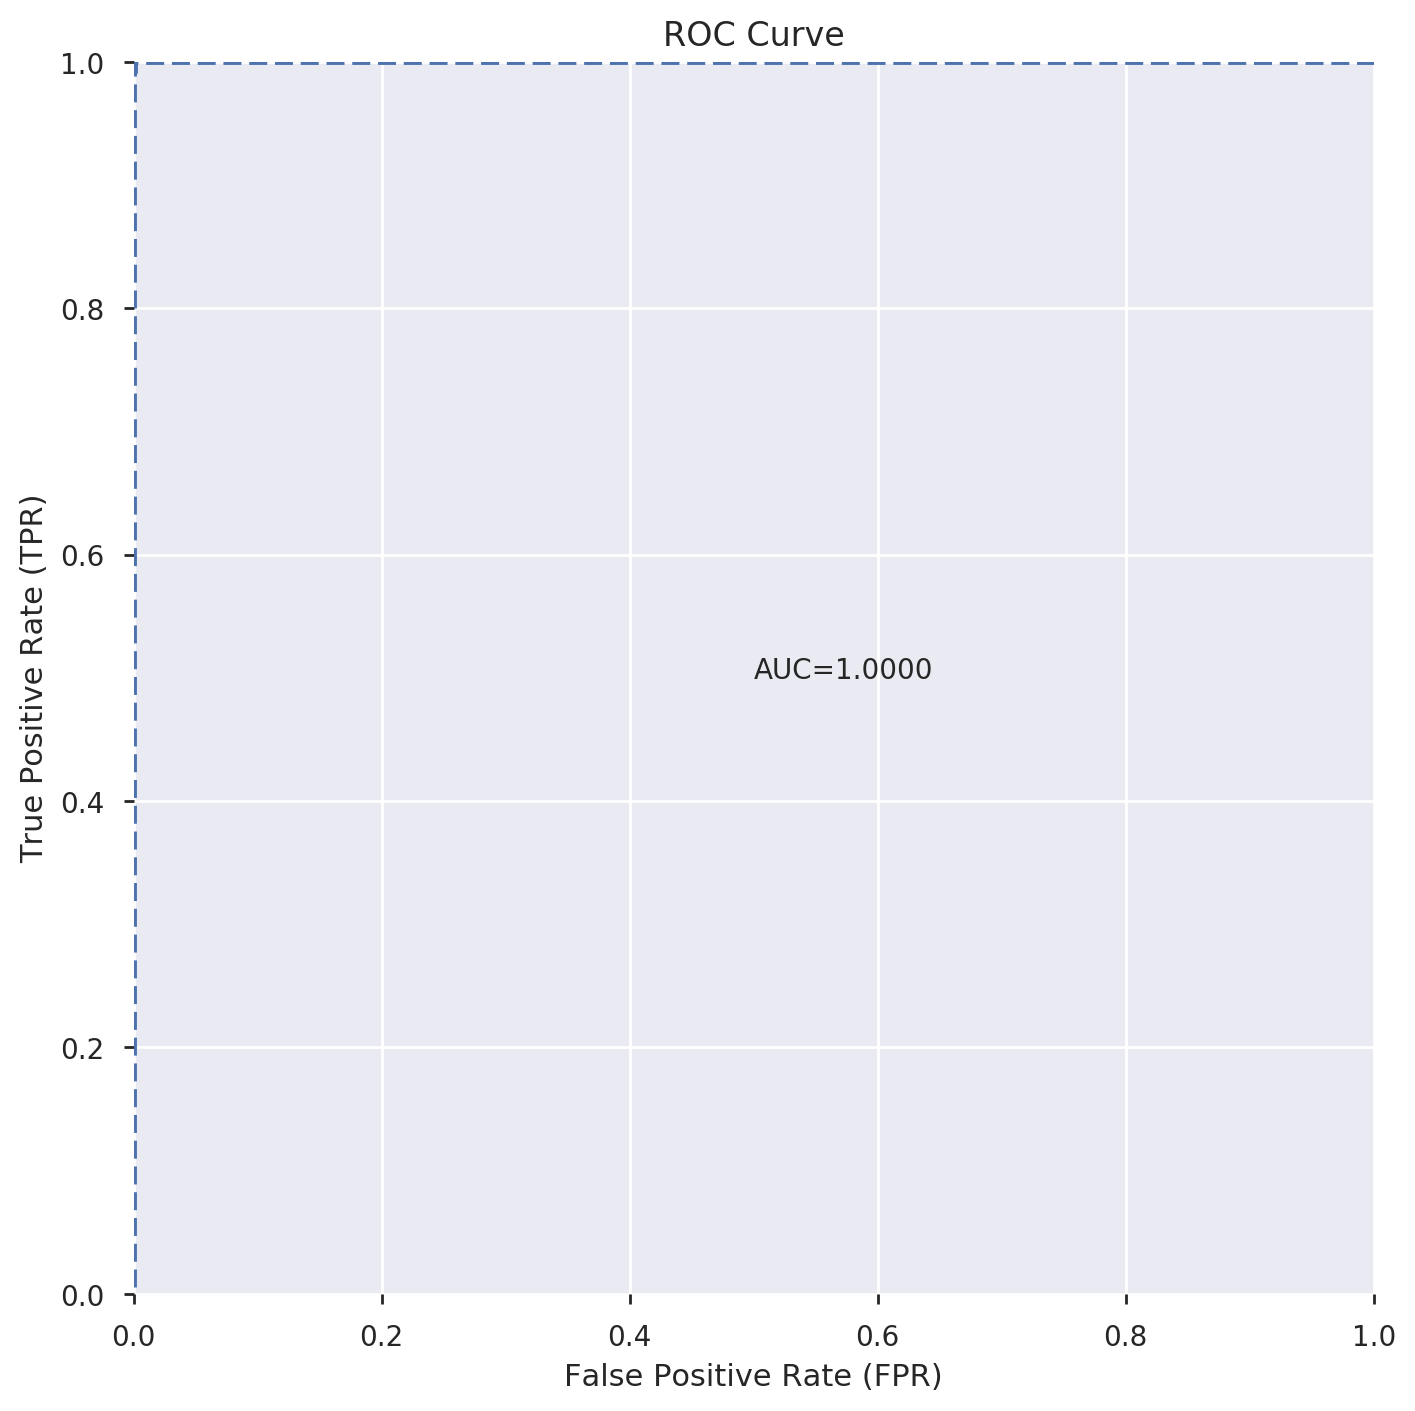

In [175]:
perf_prep.plot()

In [243]:
h2o.cluster().shutdown()